# **0. 라이브러리 및 데이터 불러오기**

**column description**
<br>
https://www.kaggle.com/kerneler/starter-airbnb-new-york-city-with-106-8a08c927-b/data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
import xgboost
from itertools import product
import datetime as dt
from xgboost import XGBRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/머신러닝 딥러닝/airbnbmark1.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (27,61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
data.shape

(153254, 106)

In [ ]:
data.head(20)

id  ... reviews_per_month
0   2595  ...              0.39
1   3831  ...              4.69
2   5099  ...              0.59
3   5121  ...              0.38
4   5178  ...              3.53
5   5203  ...              0.93
6   5238  ...              1.27
7   5441  ...              1.58
8   5803  ...              1.34
9   6021  ...              0.94
10  6090  ...              0.21
11  6848  ...              1.34
12  7097  ...              1.79
13  7322  ...              2.32
14  7726  ...              4.37
15  7750  ...               NaN
16  7801  ...              0.07
17  8024  ...              1.16
18  8110  ...              0.63
19  8490  ...              0.86

[20 rows x 106 columns]

# **1. 데이터 전처리(완료)**

### **(0) 상관관계 분포도**

**전체 변수 상관관계 분포**

범주형 변수들이 대거 제외가 된 것을 확인할 수 있음(전처리 해주지 않는 이상 원래 값에 대해서는 상관관계 측정이 불가능)

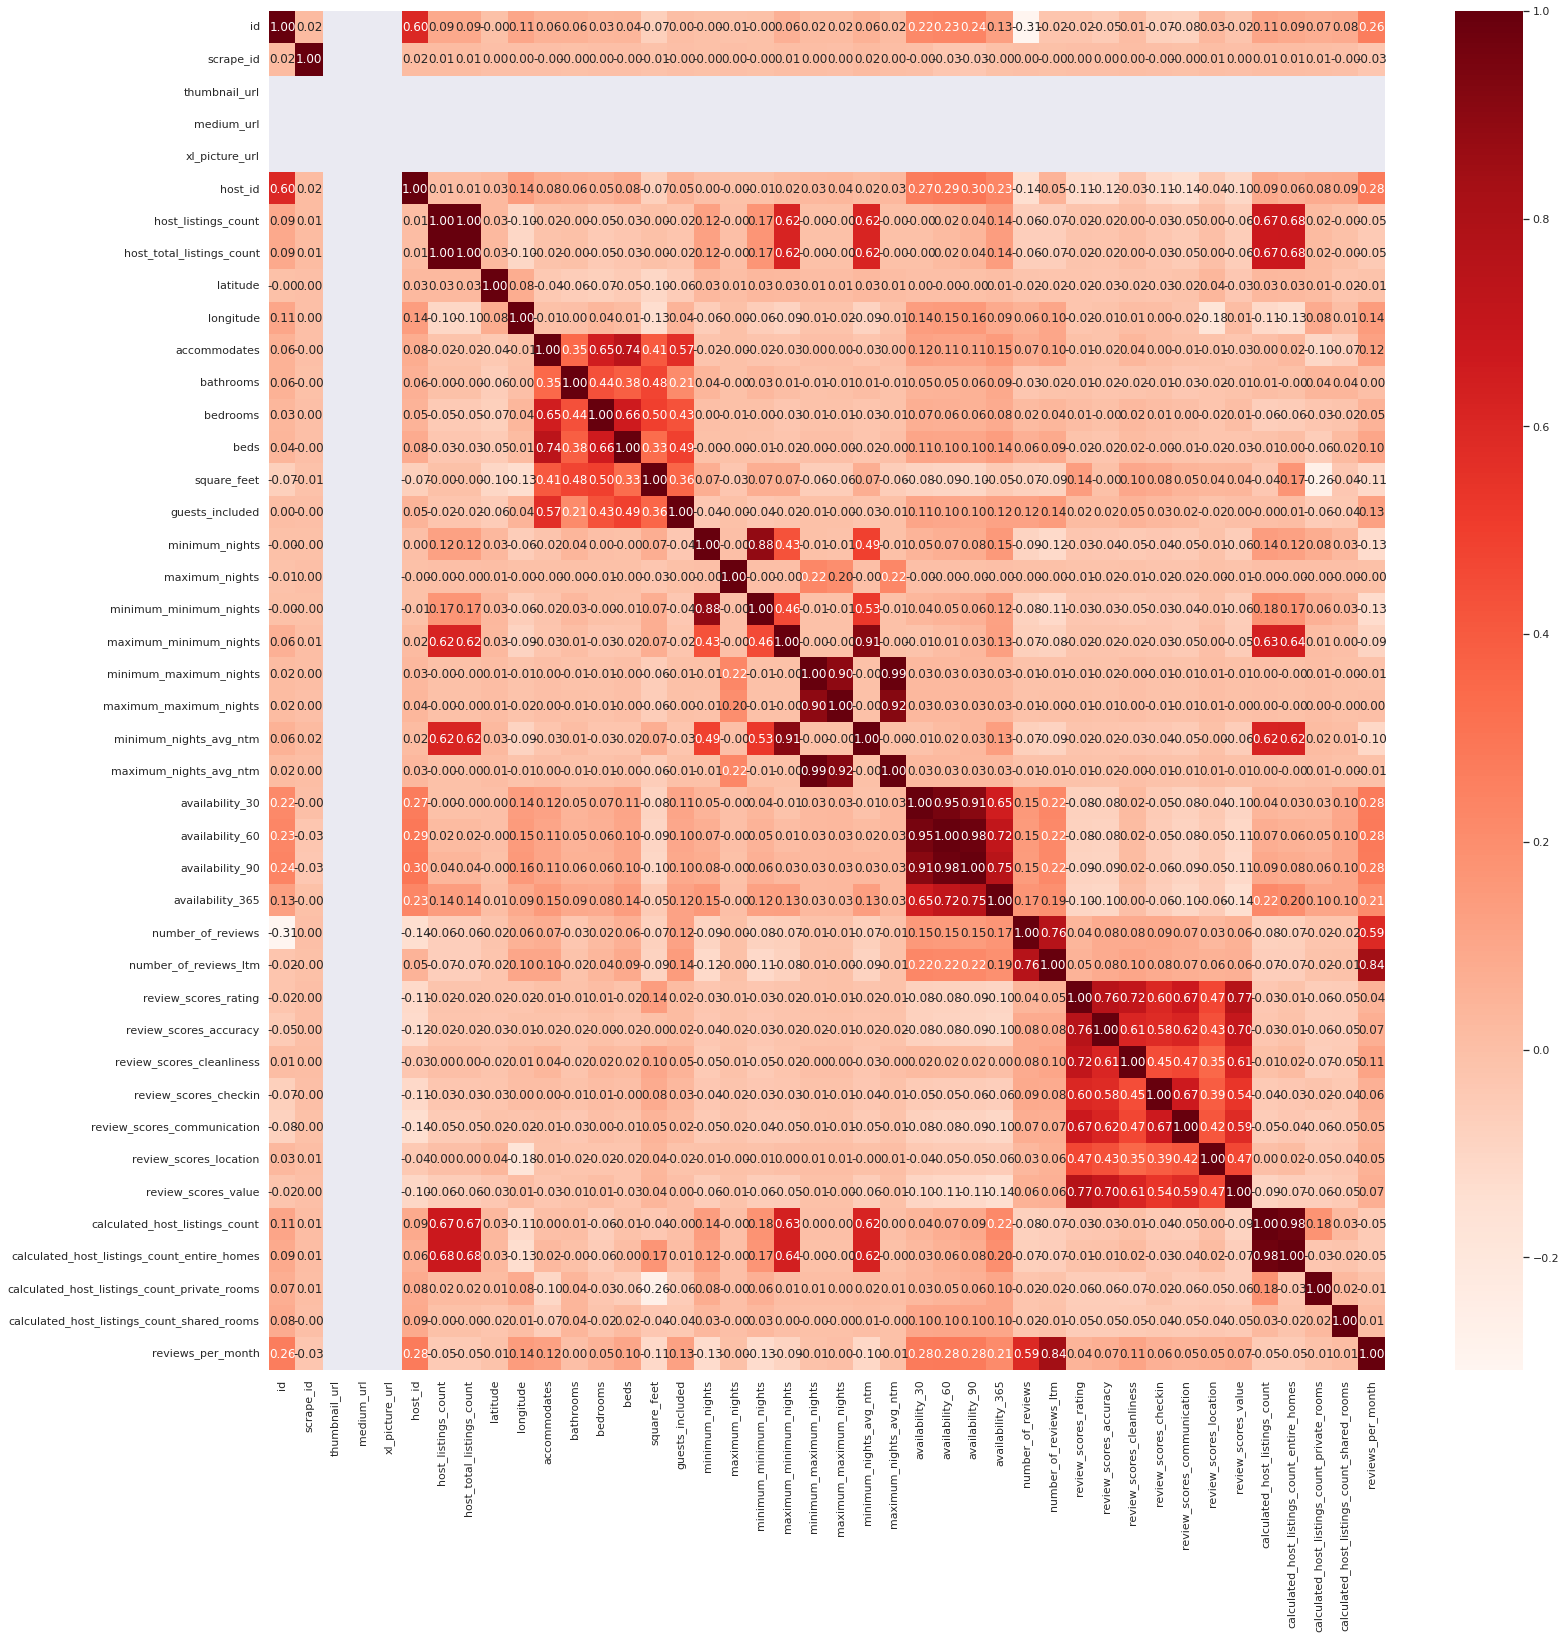

In [ ]:
sns.set(rc = {'figure.figsize':(25,25)})
sns.heatmap(data.loc[:,:].corr(), fmt = '.2f', cmap = 'Reds',annot=True)

### **(1) 변수 확인**
모든 변수 탐색
<br>
데이터가 어떤 형태이고 어떤 값이 들어있는지 확인하는 작업

**column은 총 106개**

In [ ]:
data_columns_list = pd.DataFrame(data.columns)

In [ ]:
data_columns_list

0
0                                              id
1                                     listing_url
2                                       scrape_id
3                                    last_scraped
4                                            name
..                                            ...
101                calculated_host_listings_count
102   calculated_host_listings_count_entire_homes
103  calculated_host_listings_count_private_rooms
104   calculated_host_listings_count_shared_rooms
105                             reviews_per_month

[106 rows x 1 columns]

##### **id**
다른 파일과 결합할 수 있는 식별자로 사용되는 값, **item id value**로 생각하면 될 것 같음.(primary key), But, Unique Key는 아님

In [ ]:
data['id'].value_counts()

2595        3
28101926    3
28104307    3
28104895    3
28105301    3
           ..
31073576    1
31057185    1
31056015    1
31035022    1
42892717    1
Name: id, Length: 57379, dtype: int64

In [ ]:
len(data['id'])

153254

전체 153254개의 변수에서 unique 값을 확인해보면 다른 것을 확인할 수 있음

In [ ]:
len(data['id'].unique())

바로 뒤에 나오는 listing_url의 경우도 unique value 크기가 57379로 동일함. 이후 index 정렬을 하는 데 있어 해당 값들을 사용을 해도 괜찮을 것 같음

##### **listing_url**
airbnb site 내 url 연결 링크

In [ ]:
len(data['listing_url'])

In [ ]:
len(data['listing_url'].unique())

##### **scrape_id**

스크랩 식별자
<br>
(필요 없어 보임)

In [ ]:
data['scrape_id'].head(30)

In [ ]:
len(data['scrape_id'])

In [ ]:
len(data['scrape_id'].unique())

##### **last_scraped**
해당 data가 최근에 스크랩된 날짜에 대한 변수
<br>(필요 없어 보임)

In [ ]:
data['last_scraped'].head(30)

##### **name**
상품 이름

In [ ]:
len(data['name'])

In [ ]:
len(data['name'].unique())

name도 unique value이지만 겹치는 이름이 존재하는 것 같음

##### **summary**
상품에 대한 요약된 설명
<br>(필요 없어 보임)

In [ ]:
data['summary'].head(30)

##### **space**
장소에 대한 설명
<br>(필요해 보이기도 하고 아닌 것 같기도 하고)

In [ ]:
data['space'].head(30)

##### **description**
전반적인 설명
(필요해 보이기도 하고 아닌 것 같기도 하고)

In [ ]:
data['description'].head(30)

summary, space, description 모두 비슷한 역할을 담당함

##### **experiences_offered**
설명에는 experiences offered라 나와 있는데 자의적인 해석이 안됨... 안에 들어 있는 값들도 None Value가 100%라 버려도 무방할 것 같음

In [ ]:
data['experiences_offered'].head(30)

In [ ]:
data['experiences_offered'].value_counts()

##### **Neighborhood_overview**
숙소 근방에 대한 전반적인 설명이 들어있는 변수
<br>(필요해 보이기도 하고 아닌 것 같기도 하고..)

In [ ]:
data['neighborhood_overview'].head(30)

##### **notes**
상품 내 판매자가 게시해 놓은 추가 정보? 같은 느낌의 변수.<br>
실제로 예약을 할 경우 언제까지 결제를 해야하는 지 등의 정보들이 있는 것을 확인할 수 있음
<br>(필요 없어 보임)

In [ ]:
data['notes'].head(30)

##### **Transit**
숙소와 관련된 교통 정보가 포함된 항목
<br>(필요해 보이기도 하고 아닌 것 같기도 하고)

In [ ]:
data['transit'].head(30)

##### **Access**
숙소에서 구매자가 행사할 수 있는 권리 같은 것들을 담아 둔 변수.<br>kitchen, bathroom 등 편의 시설 등을 사용할 수 있는 지에 대한 정보 같은 것들이 담겨 있음.
<br>
(필요한 것 같기도 하고 아닌 것 같기도 하고)

In [ ]:
data['access'].head(30)

##### **Interaction**
판매자와 구매자와의 interaction에 대한 정보가 담겨 있는 변수.<br>Ex : 숙소 내 판매자의 가족들이 있는지, 판매자의 숙소 거주 여부 등 판매자와 구매자와 상호 작용할 수 있는 전반적인 정보들이 들어있음.
<br>(필요해보이기도 하고 아닌 것 같기도 하고)

In [ ]:
data['interaction'].head(30)

##### **Thumbnail_url, Medium_url, Picture_url, xl_picture_url**
상품과 관련된 url인데 필요 없어 보임.
<br> xl_picture_url의 경우 결측치가 100%임

In [ ]:
data['thumbnail_url'].head(30)

In [ ]:
data['thumbnail_url'].value_counts()

In [ ]:
data['medium_url'].head(30)

In [ ]:
data['medium_url'].value_counts()

In [ ]:
data['picture_url'].head(30)

In [ ]:
data['xl_picture_url'].head(30)

In [ ]:
data['xl_picture_url'].value_counts()

##### **host_id**
host id
<br>(필요 없어 보임)

In [ ]:
data['host_id'].head(30)

##### **host_url**
host에 대한 정보가 들어 있는 url link
<br>(필요 없어 보임)

In [ ]:
data['host_url'].head(30)

##### **host_since**
host가 언제부터 해당 아이템(숙소)에서 숙박업을 했는지에 대한 정보
<br>(필요한지 아닌지 모르겠음)

In [ ]:
data['host_since'].head(30)

##### **host_location**
host가 거주하고 있는 곳인지 host가 운영하고 있는 숙소의 장소인지 헷갈림(전자일 확률 95%이긴 함.)
<br> (필요한지 아닌지 모르겠음)

In [ ]:
data['host_location'].head(30)

In [ ]:
data['host_location'].value_counts()

##### **host_about**
host에 대한 정보
<br>(필요 없어 보임)

In [ ]:
data['host_about'].head(30)

##### **host_response_time**
host에게 상품 문의를 했을 때 답변이 오기까지 걸린 시간
<br>(필요한지 아닌지 모르겠음)

In [ ]:
data['host_response_time'].head(30)

##### **host_response_time**
문의에 대한 답변이 잘 오는지에 대한 척도

In [ ]:
data['host_response_rate'].head(30)

In [ ]:
data['host_response_rate'].value_counts()

##### **host_acceptance_rate**
설명이 없는데 자의적인 해석도 안되는 변수
<br>(필요한지 아닌지 모르겠음)

In [ ]:
data['host_acceptance_rate'].head(30)

In [ ]:
data['host_acceptance_rate'].value_counts()

##### **host_is_superhost**
호스트의 super host 여부에 대한 변수(super host가 뭐지?)

In [ ]:
data['host_is_superhost'].head(30)

true, false의 형태로 값이 들어있음

In [ ]:
data['host_is_superhost'].value_counts()

##### **host_thumbnail_url, host_picture_url**
unique value
<br>(필요 없어 보임)

In [ ]:
data['host_thumbnail_url'].head(30)

In [ ]:
data['host_picture_url'].head(30)

##### **host_neighbourhood**
숙소의 주변을 가리키는 변수인지 host가 실제 거주하고 있는 주변을 가리키고 있는지 헷갈리지만 전자일 가능성 98%퍼라 생각함.

실제로 뉴욕 시내 주요 도시들이 변수로 담겨 있는 것을 확인할 수 있음

In [ ]:
data['host_neighbourhood'].head(30)

##### **host_listings_count**
설명 X, 지금까지 host가 유치해온 고객의 수에 대한 정보인 것 같음(아닐 수 있음)

In [ ]:
data['host_listings_count'].head(30)

In [ ]:
data['host_listings_count'].value_counts()

##### **host_total_listings_count**
host_listings_count와 똑같은 설명 변수

In [ ]:
data['host_total_listings_count'].head(30)

In [ ]:
tmp_arr = data['host_listings_count'].to_numpy() - data['host_total_listings_count'].to_numpy()

In [ ]:
tmp_arr_df = pd.DataFrame(tmp_arr)

In [ ]:
tmp_arr_df.describe()

In [ ]:
tmp_arr_df.value_counts()

##### **host_verifications**
설명 X, 변수 내에는 email, phone, review 등의 변수들이 들어 있는 것을 확인

In [ ]:
data['host_verifications'].head(30)

##### **host_has_profile_pic**
설명 X, 필요 없는 변수라 생각됨(t/f)

In [ ]:
data['host_has_profile_pic'].head(30)

In [ ]:
data['host_has_profile_pic'].value_counts()

##### **host_identity_verified**
호스트의 신분 증빙 여부에 대한 설명 변수
<br> 이전 조에서는 이 변수를 설명 변수로 추가해서 사용함

In [ ]:
data['host_identity_verified'].head(30)

In [ ]:
data['host_identity_verified'].value_counts()

##### **street**
설명 X, 숙소 근처 장소에 대한 설명 변수인 것 같음

In [ ]:
data['street'].head(30)

In [ ]:
data['street'].value_counts()

##### **neighbourhood**
설명 X, 지역에 대한 설명 변수 인 것 같음

In [ ]:
data['neighbourhood'].head(30)

In [ ]:
data['neighbourhood'].value_counts()

##### **neighbourhood_cleansed**
뉴욕 시 상세 주소라 나와 있음(이전 조 pdf 참조).
<br>이전 조에서는 설명 변수로 채택해서 사용

In [ ]:
data['neighbourhood_cleansed'].head(30)

In [ ]:
data['neighbourhood_cleansed'].value_counts()

##### **neighbourhood_group_cleansed**
뉴욕시 행정 단위(5개)
<br>이전 조에서는 해당 변수를 설명 변수로 채택해서 사용

In [ ]:
data['neighbourhood_group_cleansed'].head(30)

In [ ]:
data['neighbourhood_group_cleansed'].value_counts()

##### **City**
설명 X, 숙소가 위치한 City에 대한 변수인 것 같음

In [ ]:
data['city'].head(30)

In [ ]:
data['city'].value_counts()

##### **state**
설명 X, 숙소가 위치한 state인 것 같음. NY가 거의 100%

In [ ]:
data['state'].head(30)

In [ ]:
data['state'].value_counts()

##### **Zipcode**
설명 X, 우편 번호에 대한 설명 변수인 것 같음.

In [ ]:
data['zipcode'].head(30)

In [ ]:
len(data['zipcode'].unique())

##### **market**
설명 X, 무슨 변수인지 모르겠음..
<br> 뉴욕말고도 전세계 유명도시들이 포함되어 있는 것을 확인할 수 있음

In [ ]:
data['market'].head(30)

In [ ]:
data['market'].value_counts()

##### **smart_location**
설명 X, location에 대한 설명 변수인 것 같음.

In [ ]:
data['smart_location'].head(30)

In [ ]:
data['smart_location'].value_counts()

##### **country_code, country**
설명 X, item에 속한 국가를 가리키는 것 같음

In [ ]:
data['country_code'].head(30)

In [ ]:
data['country_code'].value_counts()

In [ ]:
data['country'].head(30)

In [ ]:
data['country'].value_counts()

##### **latitude, longitude**
설명 X, 위도, 경도에 대한 변수인 것 같음

In [ ]:
data['latitude'].head(30)

In [ ]:
data['longitude'].head(30)

##### **is_location_exist**
위치 정확도 여부에 대한 설명 변수
<br>이전 조에서는 이 변수를 설명 변수로 채택해서 사용
<br> True/False

In [ ]:
data['is_location_exact'].head(30)

In [ ]:
data['is_location_exact'].value_counts()

##### **property_type, room_type**
property_type : 숙소 종류
<br>room_type : 방 종류(전체 아파트, 개별 방 등)
<br>이전 조에서는 해당 변수를 설명 변수로 채택해서 사용

In [ ]:
data['property_type'].head(30)

In [ ]:
data['room_type'].head(30)

In [ ]:
data['property_type'].value_counts()

In [ ]:
data['room_type'].value_counts()

##### **accommodates**
숙박 가능 인원에 대한 설명 변수
<br>이전 조에서는 해당 변수를 설명 변수로 채택해서 사용

In [ ]:
data['accommodates'].head(30)

In [ ]:
data['accommodates'].value_counts()

##### **bathrooms, bedrooms**
이전 조에서는 bedrooms만 설명 변수로 채택해서 사용

In [ ]:
data['bathrooms'].head(30)

In [ ]:
data['bedrooms'].head(30)

In [ ]:
data['bathrooms'].value_counts()

In [ ]:
data['bedrooms'].value_counts()

##### **beds**
침대 개수
<br>이전 조에서는 해당 변수를 설명 변수로 채택해서 사용

In [ ]:
data['beds'].head(30)

In [ ]:
data['beds'].value_counts()

##### **bed_type**
침대 종류에 대한 설명
<br>이전 조에서는 해당 변수를 설명 변수로 채택해서 사용

In [ ]:
data['bed_type'].head(30)

**Real Bed**가 99% 가까이 차지

In [ ]:
data['bed_type'].value_counts()

##### **amenities**
편의 시설에 대한 설명 변수
<br>이전 조에서는 해당 변수를 설명 변수로 채택해서 사용

In [ ]:
data['amenities'].head(30)

##### **square_feet**
설명 X, 결측치가 99% 가까이 되서 사용 불가능

In [ ]:
data['square_feet'].head(30)

In [ ]:
data['square_feet'].isnull().sum()

##### **price**
종속 변수로 활용

In [ ]:
data['price'].describe()

In [ ]:
data['price'].head(30)

float로 형변환 후 사용해야 할 것 같음

##### **weekly_price, monthly_price**
설명 X, 주/월당 지불 금액에 대한 정보인 것 같음.
<br>이전 조에서는 채택 X

In [ ]:
data['weekly_price'].head(30)

In [ ]:
data['monthly_price'].head(30)

##### **security deposit**
보증금에 대한 설명 변수

In [ ]:
data['security_deposit'].head(30)

결측치 처리를 어떻게 해야할 지 논의해볼 필요성 존재
<br>대략 33~34%가 결측치 임을 확인할 수 있음

In [ ]:
data['security_deposit'].describe()

##### **cleaning fee**
설명 X, 청소 비용?
<br>이전 조에서는 해당 변수를 설명 변수로 채택해서 사용

In [ ]:
data['cleaning_fee'].head(30)

In [ ]:
data['cleaning_fee'].isnull().sum()

31923

In [ ]:
data['cleaning_fee'].value_counts()

만약 사용한다고 하면 결측치 처리를 어떻게 할지 논의해볼 필요성 존재

##### **guests_included**
설명 X, 현재 해당 숙소에 머물고 있는 사람 수?에 대한 정보 같음.

In [ ]:
data['guests_included'].head(30)

In [ ]:
data['guests_included'].value_counts()

##### **extra_people**
사람이 추가될 경우 발생하는 비용에 대한 변수
<br>이전 조는 해당 변수를 설명 변수로 채택해서 사용

In [ ]:
data['extra_people'].head(30)

In [ ]:
data['extra_people'].value_counts()

##### **minimum_nights**
설명 X, 최소 숙박일수?에 대한 정보 같음

In [ ]:
data['minimum_nights'].head(30)

In [ ]:
data['minimum_nights'].value_counts()

##### **maximum nights**
설명 X, 최대 머물 수 있는 기간에 대한 설명 같음

In [ ]:
data['maximum_nights'].head(30)

In [ ]:
data['maximum_nights'].value_counts()

##### **minimum_minimum_nights, maximum_minimum_nights, maximum_maximum_nights, minimum_maximum_nights**
설명 X, 무슨 변수인지 감이 안잡힘

In [ ]:
data['minimum_minimum_nights'].head(30)

In [ ]:
data['minimum_minimum_nights'].value_counts()

In [ ]:
data['minimum_maximum_nights'].head(30)

In [ ]:
data['minimum_maximum_nights'].value_counts()

In [ ]:
data['maximum_minimum_nights'].head(30)

In [ ]:
data['maximum_minimum_nights'].value_counts()

In [ ]:
data['maximum_maximum_nights'].head(30)

In [ ]:
data['maximum_maximum_nights'].value_counts()

4개 다 결측치는 없음
<br>필요할지는 잘 모르겠음. 만약 사용한다면 왜 사용해야 하는지 변수에 대한 의미를 제대로 파악해야 할 듯

##### **minimum_nights_avg_ntm, maximum_nights_avg_ntm**
설명 X, 파생 변수의 느낌이 강하게 듬

In [ ]:
data['minimum_nights_avg_ntm'].head(30)

In [ ]:
data['maximum_nights_avg_ntm'].head(30)

##### **calendar_updated**
설명 X, 어떤 변수인지 파악이 안 됨...

In [ ]:
data['calendar_updated'].head(30)

In [ ]:
data['calendar_updated'].value_counts()

##### **has_availability**
이용가능한 지에 대한 변수

In [ ]:
data['has_availability'].value_counts()

##### **availability_x**
x일 안에 숙박할 수 있는 일수에 대한 설명 변수
<br>이전 조에서는 해당 변수 중 availability_30, availability_365 변수만 채택해서 사용

In [ ]:
data['availability_30'].head(30)

In [ ]:
data['availability_30'].value_counts()

In [ ]:
data['availability_365'].head(30)

In [ ]:
data['availability_365'].value_counts()

In [ ]:
data['availability_60'].head(30)

In [ ]:
data['availability_60'].value_counts()

In [ ]:
data['availability_90'].head(30)

In [ ]:
data['availability_90'].value_counts()

##### **calendar_last_scraped**
설명 X, 무슨 변수인지 감이 안 잡힘..

In [ ]:
data['calendar_last_scraped'].head(30)

In [ ]:
data['calendar_last_scraped'].value_counts()

##### **number_of_reviews, number_of_review_Itm**
number_of_reviews : 리뷰 개수
<br>number_of_review_Itm : 최근 1년간 리뷰 개수
<br>이전 조는 number_of_review_Itm 변수를 설명 변수로 채택해서 사용

In [ ]:
data['number_of_reviews'].head(30)

In [ ]:
data['number_of_reviews'].value_counts()

In [ ]:
data['number_of_reviews_ltm'].head(30)

In [ ]:
data['number_of_reviews_ltm'].value_counts()

##### **first_review, last_review**
첫 번째 리뷰 및 마지막 리뷰에 대한 설명 변수 인 것 같음.

In [ ]:
data['first_review'].head(30)

In [ ]:
data['last_review'].head(30)

##### **review_scores_rating, review_scores_accuracy**
review_scores_rating : 방문객이 남긴 총 리뷰 점수(100점 만점 기준)
<br>review_scores_accuracy : 설명 X, 리뷰 정확성?
<br>이전 조는 review_scores_rating 변수를 설명 변수로 채택 후 사용 

In [ ]:
data['review_scores_rating'].head(30)

In [ ]:
data['review_scores_rating'].value_counts()

In [ ]:
data['review_scores_accuracy'].head(30)

In [ ]:
data['review_scores_accuracy'].value_counts()

두 개 변수 모두 결측치 존재. 설명 변수로 사용한다면 결측치 처리 어떻게 할 지 논의해볼 필요성 존재

In [ ]:
data['review_scores_rating'].isnull().sum()

In [ ]:
data['review_scores_accuracy'].isnull().sum()

##### **review 관련 정보들**
review_scores_cleanliness : 설명 X
<br>review_scores_checkin : 설명 X
<br>review_scores_communication : 설명 X
<br>review_scores_location : 설명 X
<br>review_scores_value : 설명 X
<br>관련된 자료가 없다 보니 파생 변수인지 설명 변수인지 감이 안 잡힘


##### **requires_license**
license 획득 여부에 대한 변수
<br>false : 100%

In [ ]:
data['requires_license'].head(30)

In [ ]:
data['requires_license'].value_counts()

##### **license**
license에 관한 정보
<br> 거의 대다수가 Null Value(NaN)

In [ ]:
data['license'].head(30)

In [ ]:
data['license'].value_counts()

In [ ]:
data['license'].isnull().sum()

##### **jurisdiction_names**
관할구역명에 대한 설명 변수, 결측치가 거의 100%


In [ ]:
data['jurisdiction_names'].head(30)

In [ ]:
data['jurisdiction_names'].value_counts()

In [ ]:
data['jurisdiction_names'].isnull().sum()

##### **instant_bookable**
즉시 예약이 되는 숙소인지에 대한 여부를 알려주는 설명 변수(True/False)

In [ ]:
data['instant_bookable'].head(30)

In [ ]:
data['instant_bookable'].value_counts()

In [ ]:
data['instant_bookable'].isnull().sum()

##### **is_business_travel_ready**
설명 X, 출장 여부?
<br>True/False
<br>False가 100%(결측치 제로)

In [ ]:
data['is_business_travel_ready'].head(30)

In [ ]:
data['is_business_travel_ready'].value_counts()

In [ ]:
data['is_business_travel_ready'].isnull().sum()

##### **cancellation_policy**
취소 정책 관련 설명 변수
<br>이전 조에서는 해당 변수를 설명 변수로 채택

In [ ]:
data['cancellation_policy'].head(30)

In [ ]:
data['cancellation_policy'].value_counts()

In [ ]:
data['cancellation_policy'].isnull().sum()

##### **require_guest_profile_picture, require_guest_phone_verification**
손님에게 요구하는 정보?에 대한 설명 변수인 것 같음.
<br>True/False 값이 들어 있음(결측치 X)

In [ ]:
data['require_guest_phone_verification'].head(30)

In [ ]:
data['require_guest_profile_picture'].head(30)

In [ ]:
data['require_guest_phone_verification'].value_counts()

In [ ]:
data['require_guest_profile_picture'].value_counts()

In [ ]:
data['require_guest_phone_verification'].isnull().sum()

In [ ]:
data['require_guest_profile_picture'].isnull().sum()

##### **calculated_host_listings_count, calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, calculated_host_listings_count_shared_rooms**
calculated_host_listings_count : host가 airbnb에서 운영 중인 숙소의 개수<br>
calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, calculated_host_listings_count_shared_rooms : 설명 X
<br>
이전 조에서는 calculated_host_listings_count 변수를 설명 변수로 채택해서 사용
<br>
calculated_host_listing_count는 나머지 3개 변수 합한 거에 거의 근사하는 것을 확인할 수 있음 따라서 파생 변수로 간주하고 사용하면 될 것 같음

In [ ]:
all = data['calculated_host_listings_count'].to_numpy()
private_rooms = data['calculated_host_listings_count_private_rooms'].to_numpy()
shared_rooms = data['calculated_host_listings_count_shared_rooms'].to_numpy()
entire_homes = data['calculated_host_listings_count_entire_homes'].to_numpy()
all = all - private_rooms - shared_rooms - entire_homes

In [ ]:
all

In [ ]:
all_df = pd.DataFrame(all)
all_df.value_counts()

##### **reviews_per_month**
월별 리뷰 수(평균 값에 해당하는 것 같음)
<br>이전 조는 해당 변수를 설명 변수로 채택해서 사용

In [ ]:
data['reviews_per_month'].head(30)

만약에 설명변수로 사용한다면 **누락된 결측값**에 대해서 어떻게 처리를 할 지 논의해볼 필요성 존재

### **(2) 전처리**


#### **작년에 사용한 변수 list**

In [ ]:
previous_val_list = ['accommodates', 'amenities', 'availability_30', 'availability_365', 'bed_type', 'bedrooms', 'beds', 'calculated_host_listings_count', 
                'cancellation_policy', 'extra_people', 'host_identity_verified', 'host_is_superhost', 'host_response_time', 'is_location_exact', 'last_scraped', 'last_review',
                'cleaning_fee', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'number_of_reviews_ltm', 'property_type', 'review_scores_rating', 'reviews_per_month',
                'room_type', 'security_deposit', 'price']

In [ ]:
prev_data_df = data[previous_val_list]

#### **Modeling에 사용하기로 한 변수**
**사용변수**
<br>host_is_superhost, neighbourhood_group_cleansed, latitude, longitude, property_type(중간 전처리 작업 추가), room_type,
accommodates, bathrooms(결측치 처리), bedrooms(결측치 처리), beds(결측치 처리), amenities(**one hot encoding**), price, cleaning_fee(결측치 처리), guests_included, minimum_nights, availability_30, availability_365, number_of_reviews_ltm, review_scores_rating, cancellation_policy, reviews_per_month

#### **변수 한 개씩 전처리 작업**

In [ ]:
import copy
tmp_data = copy.deepcopy(data)

**전처리 작업**
<br>**1. 결측치 처리**
<br>(1) 변수 내 결측치가 있는지 확인
<br>(2) 결측치가 있는 경우 해당 변수가 연속형 변수인지 범주형 변수인지에 따라 결측치 처리 방식이 달라질 수 있으니 **변수 타입에 맞춰 결측치 처리 진행**
<br>(3) 연속형 변수인 경우 이상치에 따라 중앙값, 또는 평균을 넣는 방식을 토대로 결측치 처리를 진행
<br>(4) 범주형 변수인 경우 결측치 처리를 따로 진행 X(결측치가 있는 범주형 변수를 설명 변수로 사용하지 않음)
<br>(5) 총 데이터의 30~40% 이상의 데이터가 결측치인 경우 해당 column을 삭제해도 된다 판단이 된다면 삭제 처리 진행
<br><br>
**2. 이상치 처리**
<br>(1) 기본적으로 데이터 내 이상치가 있어도 특별한 사유가 있지 않는 이상 이상치 제거 작업을 진행하지 않기로 결정함
<br>(2) 하지만 정말 의미 없는 이상치가 발견 되는 경우 해당 값을 삭제하는 방식으로 전처리
<br><br>
**3. 범주형 변수**
<br>(1) 기본적으로 **One hot encoding 기법**을 토대로 범주형 변수를 전처리


#####**id**
상품(item)에 대한 id value
<br>price와 직접적인 연관성이 없다 판단해 설명 변수로 채택 X

In [ ]:
# 실행
tmp_data.drop('id', axis=1, inplace=True)

KeyError: ignored

##### **listing_url**
상품에 대한 url
<br>id와 마찬가지로 price에 미치는 영향력이 없다 판단해 설명 변수로 채택 X

In [ ]:
#실행
tmp_data.drop('listing_url', axis=1, inplace=True)

##### **scrape_id**
마찬가지로 price에 미치는 영향력이 없다 판단해 설명 변수로 채택 X

In [ ]:
#실행
tmp_data.drop('scrape_id', axis=1, inplace=True)

##### **last_scraped**
데이터가 수집된 날짜,
EDA 이후 설명 변수 채택 X

In [ ]:
#실행
tmp_data['last_scraped'].head(30)

0     2020-02-12
1     2020-02-13
2     2020-02-12
3     2020-02-12
4     2020-02-13
5     2020-02-12
6     2020-02-12
7     2020-02-12
8     2020-02-13
9     2020-02-13
10    2020-02-12
11    2020-02-13
12    2020-02-13
13    2020-02-12
14    2020-02-13
15    2020-02-12
16    2020-02-13
17    2020-02-13
18    2020-02-13
19    2020-02-12
20    2020-02-12
21    2020-02-13
22    2020-02-12
23    2020-02-12
24    2020-02-12
25    2020-02-12
26    2020-02-12
27    2020-02-13
28    2020-02-12
29    2020-02-13
Name: last_scraped, dtype: object

DataTime 변수임을 확인할 수 있음
<br>다음으로 결측치가 있는지 Check

In [ ]:
#실행
tmp_data['last_scraped'].isnull().sum()

0

결측치가 없음을 확인할 수 있음<br>
DateTime형 변수이기 때문에 범주형 변수로 처리를 해야 함

In [ ]:
#실행
tmp_data['last_scraped'].value_counts()

2020-03-14    50795
2020-02-12    30414
2020-01-04    25980
2020-01-03    25372
2020-02-13    20683
2020-01-05        8
2020-01-06        1
2020-03-15        1
Name: last_scraped, dtype: int64

**EDA 결과 필요 없는 변수로 판정이 되어 삭제 처리**

In [ ]:
#실행
tmp_data.drop('last_scraped', axis=1, inplace=True)

##### **name**
상품 이름에 대한 변수<br>
price에 미치는 영향력 없다 판단해서 설명 변수에서 제외

In [ ]:
#실행
tmp_data.drop('name', axis=1, inplace=True)

##### **summary**
상품에 대한 요약 설명 역할 담당
<br>채택 X

결측치가 미세하게 존재함

In [ ]:
#실행
tmp_data['summary'].isnull().sum()

7281

In [ ]:
#실행
tmp_data.drop('summary', axis=1, inplace=True)

##### **space, description**
설명 변수로 채택 X

In [ ]:
#실행
tmp_data.drop(['space', 'description'], axis=1, inplace=True)

##### **experiences_offered**
experiences_offered 내 들어 있는 모든 변수가 none이기 때문에 종속 변수 price와 관련이 없다 생각했고 설명 변수에서 제외함

In [ ]:
#실행
tmp_data['experiences_offered'].value_counts()

none    153254
Name: experiences_offered, dtype: int64

In [ ]:
#실행
tmp_data.drop('experiences_offered', axis=1, inplace=True)

##### **neighborhood_overview**
앞서 지운 space, description과 마찬가지의 이유로 설명 변수에서 제거

In [ ]:
#실행
tmp_data.drop(['neighborhood_overview'], axis=1, inplace=True)

##### **notes**
host가 등록한 상품에 대한 메모 역할을 담당하는 변수<br>
종속 변수와 상관이 없다 판단해 설명 변수에서 삭제 진행

In [ ]:
#실행
tmp_data.drop('notes', axis=1, inplace=True)

##### **transit**
숙소(item)에 오는 교통편에 대한 정보를 담은 변수<br>
충분히 영향을 줄 수 있는 변수라 생각하지만 결측치 비율이 34%<br>transit 변수가 범주형 변수이기 때문에 설명 변수에서 제외하기로 결정

In [ ]:
#실행
tmp_data['transit'].isnull().sum()

52735

In [ ]:
#실행
tmp_data.drop('transit', axis=1, inplace=True)

##### **access**
사용자가 숙소(item)내에서 물품 및 시설을 사용할 수 있는 권한에 대한 정보를 담은 변수<br>
결측치가 47%이며 범주형 변수이기 때문에 결측치 처리가 어려운 상황<br>
설명 변수에서 삭제 처리

In [ ]:
#실행
tmp_data['access'].isnull().sum()

72049

In [ ]:
#실행
tmp_data.drop('access', axis=1, inplace=True)

##### **interaction**
host가 item 이용자들과 어떻게 상호작용하는지에 대한 정보를 담은 변수<br>
결측치가 40%이며 범주형 변수이기 때문에 결측치 처리를 하는데 있어 어려움이 있음<br>
설명 변수에서 삭제 처리

In [ ]:
#실행
tmp_data['interaction'].isnull().sum()

61865

In [ ]:
#실행
tmp_data.drop('interaction', axis=1, inplace=True)

##### **house_rules**
사용자들이 숙소(item)에서 지켜야 될 규칙을 담은 정보
<br>결측치가 40%이며 범주형 변수이기 때문에 결측치 처리를 하는 데 있어 어려움이 있음
<br>설명 변수에서 삭제 처리

In [ ]:
#실행
tmp_data['house_rules'].isnull().sum()

59676

In [ ]:
#실행
tmp_data.drop('house_rules', axis=1, inplace=True)

##### **thumbnail_url, medium_url, picture_url, xl_picture_url**
price에 영향을 미치지 않는다 판단해서 설명 변수에서 삭제 처리

In [ ]:
#실행
tmp_data['thumbnail_url'].isnull().sum()

153254

In [ ]:
#실행
tmp_data['medium_url'].isnull().sum()

153254

**medium_url과 thumbnail_url**의 경우 결측치 100%

In [ ]:
#실행
tmp_data.drop(['thumbnail_url','medium_url','picture_url','xl_picture_url'], axis=1, inplace=True)

##### **host_id, host_url, host_name, host_since, host_location, host_about**
host와 관련된 전반적인 정보들을 담은 변수<br>
price와 연관되어 있지 않다 판단함<br>설명 변수에서 삭제

In [ ]:
#실행
tmp_data.drop(['host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about'], axis=1, inplace=True)

##### **host_response_time, host_response_rate, host_acceptance_rate, host_thumbnail_url, host_picture_url, host_neighbourhood, host_listings_count, host_total_listings_counts, host_verifications, host_has_profile_pic, host_identity_verified**
airbnb 사이트 내에서 superhost의 경우 host와 관련된 특징들을 토대로 결정한다고 나와 있음<br> 따라서 superhost와 관련된 정보 및 host의 개인 정보들의 경우 설명 변수로서 역할을 할 수 없다 판단해서 제거함

In [ ]:
#실행
tmp_data.drop(['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_thumbnail_url',
               'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count',
               'host_verifications', 'host_has_profile_pic', 'host_identity_verified'], axis=1, inplace=True)

superhost 여부에 대한 변수인 host_is_superhost만 설명 변수로 채택<br>
one hot encoding로 범주형 변수 전처리

In [ ]:
#실행
tmp_data = pd.get_dummies(tmp_data, columns=['host_is_superhost'])

##### **street, neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, city, state, zipcode, market, smart_location, country_code, country**
item이 속한 주소(또는 국가)와 관련된 설명 변수 list<br>
국가와 관련된 설명 변수는 필요 없다 판단(애초에 뉴욕 지역 내 에어비앤비 가격 예측을 진행하기 때문)<br>
지역 주소를 설명하는 변수의 경우 너무 많은 구역(207개)으로 나누는 neighbourhood 보다는 neighbourhood_group_cleansed가 더 설득력 있을 것이라 판단되어 neighbourhood_group_cleansed 변수 채택

In [ ]:
#실행
tmp_data.drop(['street', 'neighbourhood_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location',
               'country_code', 'country'], axis=1, inplace=True)

범주형 변수 전처리

In [ ]:
#실행
tmp_data['neighbourhood'].value_counts()

Brooklyn              32630
Manhattan             30374
Queens                 9326
Bedford-Stuyvesant     5739
Williamsburg           5434
                      ...  
New Dorp                  1
Gerritsen Beach           1
Co-op City                1
Willowbrook               1
Greenridge                1
Name: neighbourhood, Length: 206, dtype: int64

**neighbourhood의 unique value : 207개**<br>
너무 많다 판단되어 일단 삭제

In [ ]:
#실행
tmp_data.drop('neighbourhood', axis=1, inplace=True)

In [ ]:
#실행
tmp_data = pd.get_dummies(tmp_data, columns=['neighbourhood_group_cleansed'])

##### **latitude, longitude**
위도, 경도에 해당하는 변수이고 상품에 대한 위치를 나타내는 매우 중요한 정보이기 때문에 설명 변수로 남김<br>작년의 경우 해당 변수를 토대로 사후 변수를 제작했는데 이는 설명력을 더 하락시킬 수 있는 요인이라 생각했기에 원본 데이터 그대로 사용하기로 결정

In [ ]:
#실행
tmp_data['latitude'].head(30)

0     40.75362
1     40.68514
2     40.74767
3     40.68688
4     40.76489
5     40.80178
6     40.71344
7     40.76076
8     40.66829
9     40.79826
10    40.73530
11    40.70837
12    40.69169
13    40.74192
14    40.67592
15    40.79685
16    40.71842
17    40.68069
18    40.68001
19    40.68371
20    40.86754
21    40.86482
22    40.72920
23    40.82245
24    40.81305
25    40.82130
26    40.68310
27    40.66869
28    40.70186
29    40.63702
Name: latitude, dtype: float64

In [ ]:
#실행
tmp_data['longitude'].head(30)

0    -73.98377
1    -73.95976
2    -73.97500
3    -73.95596
4    -73.98493
5    -73.96723
6    -73.99037
7    -73.98867
8    -73.98779
9    -73.96113
10   -74.00525
11   -73.95352
12   -73.97185
13   -73.99501
14   -73.94694
15   -73.94872
16   -73.95718
17   -73.97706
18   -73.97865
19   -73.94028
20   -73.92639
21   -73.92106
22   -73.98542
23   -73.95104
24   -73.95466
25   -73.95318
26   -73.95473
27   -73.98780
28   -73.92745
29   -73.96327
Name: longitude, dtype: float64

##### **is_location_exact**
상품이 해당 위치에 정확하게 있는지에 대한 정보를 담은 변수
<br>위치 정보는 위도, 경도만 사용하기로 했기 때문에 설명 변수에서 삭제

In [ ]:
#실행
tmp_data.drop('is_location_exact', axis=1, inplace=True)

##### **property_type, room_type**
숙소 및 방 종류에 대한 정보를 담은 변수<br>
가격에 영향을 줄 수 있는 정보들이기에 설명 변수로 사용

결측치 확인

In [ ]:
#실행
tmp_data['property_type'].isnull().sum()

0

In [ ]:
#실행
tmp_data['room_type'].isnull().sum()

0

결측치가 없는 것을 확인할 수 있음
<br>범주형 변수이기 때문에 추후 one hot encoding 작업을 통해 전처리 진행할 예정

In [ ]:
#실행
tmp_data['property_type'].value_counts()

Apartment                 119923
House                      12582
Townhouse                   5182
Condominium                 5091
Loft                        4186
Serviced apartment          1360
Guest suite                 1289
Boutique hotel              1209
Hotel                        820
Other                        287
Guesthouse                   226
Resort                       226
Hostel                       161
Bed and breakfast            161
Bungalow                      98
Villa                         97
Tiny house                    68
Camper/RV                     54
Aparthotel                    47
Boat                          25
Earth house                   24
Cottage                       24
Tent                          17
Casa particular (Cuba)        12
Cave                          12
Houseboat                      9
Castle                         7
Barn                           7
Bus                            6
Cabin                          6
Yurt      

EDA 후 Apartment, House, Townhouse, Condominium, Loft 그리고 나머지는 Others로 변수 전처리 진행하기로 결정

In [ ]:
#실행
tmp_data['property_type'] = np.where((tmp_data['property_type'] == 'Apartment' ) | (tmp_data['property_type'] == 'House')|
                                          (tmp_data['property_type'] == 'Townhouse') | (tmp_data['property_type'] == 'Condominium') |
                                          (tmp_data['property_type'] == 'Loft'), tmp_data['property_type'], 'Others')

In [ ]:
#실행
tmp_data['property_type'].value_counts()

Apartment      119923
House           12582
Others           6290
Townhouse        5182
Condominium      5091
Loft             4186
Name: property_type, dtype: int64

In [ ]:
#실행
tmp_data['room_type'].value_counts()

Entire home/apt    79377
Private room       68946
Shared room         3729
Hotel room          1202
Name: room_type, dtype: int64

In [ ]:
#실행
tmp_data = pd.get_dummies(tmp_data, columns=['room_type', 'property_type'])

In [ ]:
tmp_data.head(10)

host_is_superhost  ... property_type_Yurt
0                 f  ...                  0
1                 f  ...                  0
2                 f  ...                  0
3                 f  ...                  0
4                 f  ...                  0
5                 f  ...                  0
6                 t  ...                  0
7                 t  ...                  0
8                 t  ...                  0
9                 f  ...                  0

[10 rows x 315 columns]

##### **accommodates**
숙박 가능 인원 수에 대한 정보를 담은 변수<br>
가격에 충분히 영향을 미칠 수 있는 정보이기에 설명 변수로 채택

결측치 확인

In [ ]:
#실행
tmp_data['accommodates'].isnull().sum()

0

결측치가 없는 것을 확인<br>
해당 변수는 연속형 변수로 간주해서 사용해야 함<br>
이상치 있는지 boxplot method를 토대로 확인

[]

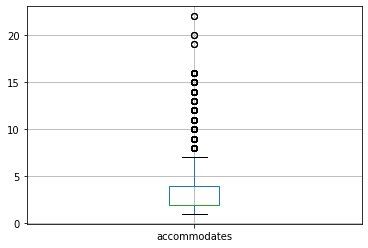

In [ ]:
#실행
boxplot = tmp_data.boxplot(column='accommodates')
boxplot.plot()

이상치가 있는 것을 확인할 수 있음<br>
But 제거할 타당한 이유가 없기 때문에 이상치 제거 작업 없이 그대로 사용 예정

##### **bathrooms, bedrooms**
숙소(item)내 bathrooms bedrooms 개수에 대한 정보를 담은 변수<br>
가격과 연결될 수 있는 정보이기 때문에 설명 변수로 추가

결측치 확인

In [ ]:
#실행
tmp_data['bathrooms'].isnull().sum()

150

In [ ]:
#실행
tmp_data['bedrooms'].isnull().sum()

220

결측치가 정말 적다는 것을 확인할 수 있음. 연속형 변수이기 때문에 결측치 처리를 어떻게 하면 좋을지 describe method와 boxplot을 토대로 확인(중앙값을 넣을지, 평균값을 넣을지)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


[]

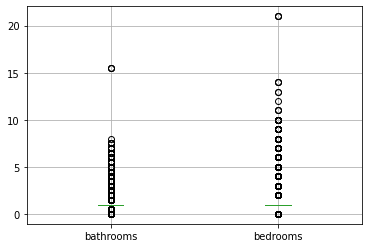

In [ ]:
#실행
boxplot = tmp_data.boxplot(column=['bathrooms','bedrooms'])
boxplot.plot()

In [ ]:
#실행
tmp_data['bathrooms'].describe()

count    153104.000000
mean          1.146626
std           0.426746
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          15.500000
Name: bathrooms, dtype: float64

In [ ]:
#실행
tmp_data['bedrooms'].describe()

count    153034.000000
mean          1.180666
std           0.757619
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          21.000000
Name: bedrooms, dtype: float64

이상치 존재로 인해 중앙값을 넣는 것이 더 합리적이라고 판단됨. 따라서 결측치는 중앙값을 넣어서 전처리를 진행할 예정

In [ ]:
#실행
tmp_data['bedrooms'] = tmp_data['bedrooms'].fillna(tmp_data['bedrooms'].median())

In [ ]:
#실행
tmp_data['bedrooms'].isnull().sum()

0

In [ ]:
#실행
tmp_data['bathrooms'] = tmp_data['bathrooms'].fillna(tmp_data['bathrooms'].median())

In [ ]:
#실행
tmp_data['bathrooms'].isnull().sum()

0

##### **beds**

In [ ]:
tmp_data['beds']

0         1.0
1         4.0
2         1.0
3         1.0
4         1.0
         ... 
153249    1.0
153250    0.0
153251    1.0
153252    NaN
153253    3.0
Name: beds, Length: 153254, dtype: float64

In [ ]:
tmp_data['beds'].isnull().sum()

1033

[]

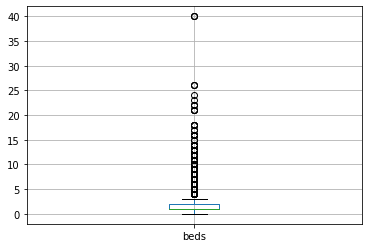

In [ ]:
boxplot = tmp_data.boxplot(column=['beds'])
boxplot.plot()

In [ ]:
tmp_data['beds'].describe()

count    152221.000000
mean          1.544432
std           1.132657
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          40.000000
Name: beds, dtype: float64

In [ ]:
#실행
tmp_data['beds'] = tmp_data['beds'].fillna(tmp_data['beds'].median())

In [ ]:
#실행
tmp_data['beds'].isnull().sum()

0

##### **bed_type**
bed type과 관련된 변수이지만 Real Bed가 차지하는 비율이 99%가 넘어감<br>따라서 설명 변수로 사용하기에는 적절치 않다는 결론이 나와 설명 변수에서 삭제 처리

In [ ]:
#실행
tmp_data['bed_type'].value_counts()

Real Bed         151082
Futon               812
Pull-out Sofa       692
Airbed              470
Couch               198
Name: bed_type, dtype: int64

In [ ]:
#실행
tmp_data.drop('bed_type', axis=1, inplace=True)

#####**amenities**
편의 시설에 대한 정보<br>
가격에 영향을 미칠 수 있는 변수라 판단되어 설명 변수로 사용

In [ ]:
#실행
tmp_data['amenities'].isnull().sum()

0

결측치 없음을 확인

**편의 서비스 및 항목**에 대한 설명 변수

In [ ]:
#실행
tmp_data['amenities']

0         {TV,Wifi,"Air conditioning",Kitchen,"Paid park...
1         {TV,"Cable TV",Internet,Wifi,"Air conditioning...
2         {TV,"Cable TV",Internet,Wifi,"Air conditioning...
3         {Wifi,"Air conditioning",Kitchen,"Pets live on...
4         {TV,Wifi,"Air conditioning","Paid parking off ...
                                ...                        
153249    {Wifi,"Air conditioning",Kitchen,Heating,"Smok...
153250    {Wifi,"Air conditioning",Kitchen,Heating,"Smok...
153251    {Wifi,"Air conditioning",Kitchen,"Pets allowed...
153252    {TV,Wifi,"Air conditioning",Kitchen,"Free park...
153253                                {TV,Wifi,"Hot water"}
Name: amenities, Length: 153254, dtype: object

**변수 내 들어있는 중괄호{}를 없애기 위해 str 메소드 사용**

In [ ]:
#실행
tmp_data['amenities'] = tmp_data['amenities'].str[1:-1]

In [ ]:
#실행
tmp_data['amenities']

0         TV,Wifi,"Air conditioning",Kitchen,"Paid parki...
1         TV,"Cable TV",Internet,Wifi,"Air conditioning"...
2         TV,"Cable TV",Internet,Wifi,"Air conditioning"...
3         Wifi,"Air conditioning",Kitchen,"Pets live on ...
4         TV,Wifi,"Air conditioning","Paid parking off p...
                                ...                        
153249    Wifi,"Air conditioning",Kitchen,Heating,"Smoke...
153250    Wifi,"Air conditioning",Kitchen,Heating,"Smoke...
153251    Wifi,"Air conditioning",Kitchen,"Pets allowed"...
153252    TV,Wifi,"Air conditioning",Kitchen,"Free parki...
153253                                  TV,Wifi,"Hot water"
Name: amenities, Length: 153254, dtype: object

**one hot encoding**을 위해 amenities column 내 값들 list로 전처리

In [ ]:
#실행
amenities_list = tmp_data['amenities'].tolist()

In [ ]:
amenities_list

['TV,Wifi,"Air conditioning",Kitchen,"Paid parking off premises","Free street parking",Heating,"Family/kid friendly","Smoke detector","Carbon monoxide detector","Fire extinguisher",Essentials,"Lock on bedroom door","Hair dryer",Iron,"Laptop friendly workspace","Self check-in",Keypad,"Private living room",Bathtub,"Hot water","Bed linens","Extra pillows and blankets","Ethernet connection","Coffee maker",Refrigerator,"Dishes and silverware","Cooking basics",Oven,Stove,"Luggage dropoff allowed","Long term stays allowed","Cleaning before checkout"',
 'TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,"Pets allowed","Free street parking",Heating,"Family/kid friendly","Smoke detector","Carbon monoxide detector","Fire extinguisher",Essentials,Shampoo,"Lock on bedroom door","24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in",Lockbox,Bathtub,"High chair","Stair gates","Children’s books and toys","Pack ’n Play/travel crib","Hot water",Microwave,"Coffee ma

**amenities column** 내 어떤 값들이 unique하게 있는지 확인하기 위해 만든 make_list1 method(중복된 값 제거)
<br>return : amenities column 내 들어 있는 모든 값들을 반환(중복된 값 제외 -> set으로 처리)

In [ ]:
#실행
def make_list1(list_):
  tmp_list = []
  for j in range(len(list_)):
    tmp_val = list_[j].split(sep=',')
    for k in range(len(tmp_val)):
      if "\'" in tmp_val[k] or "\"" in tmp_val[k]:
        if "\'" == tmp_val[k][-1] or "\"" == tmp_val[k][-1]:
          tmp_val[k] = tmp_val[k][1:-1]
      tmp_list.append(tmp_val[k])
  tmp_list = list(set(tmp_list))
  return tmp_list

In [ ]:
#실행
final_list = make_list1(amenities_list)

In [ ]:
final_list

['',
 'Wifi',
 'Children’s dinnerware',
 'Mobile hoist',
 'Bath towel',
 'Flat path to guest entrance',
 'Beach essentials',
 'Kitchenette',
 'translation missing: en.hosting_amenity_49',
 'Doorman',
 'Mini bar',
 'Barbecue utensils',
 'Wide entrance',
 'Hot water',
 'Kitchen',
 'Elevator',
 'Bed linens',
 'Shower chair',
 'Pool with pool hoist',
 'Cooking basics',
 '24-hour check-in',
 'Air purifier',
 'Cable TV',
 'Air conditioning',
 'Table corner guards',
 'Bathtub with bath chair',
 'Dog(s)',
 'Accessible-height bed',
 'Wheelchair accessible',
 'Well-lit path to entrance',
 'Luggage dropoff allowed',
 'Toilet paper',
 'Wide entryway',
 'Beachfront',
 'Handheld shower head',
 '"Fixed grab bars for shower',
 'Hot water kettle',
 'Bottled water',
 'Laptop friendly workspace',
 'Full kitchen',
 'No stairs or steps to enter',
 'Smart lock',
 'Hangers',
 'Bedroom comforts',
 'Turndown service',
 'Lock on bedroom door',
 'Buzzer/wireless intercom',
 'Free street parking',
 'Bathtub',
 'E

In [ ]:
len(final_list)

152

amenities column에 대한 **one hot encoding**을 위한 사용자 정의 함수 선언

In [ ]:
#실행
def one_hot_encoding_(df, all_amen_list):
  for i in all_amen_list:
    amen_nm = "amenities_" + i
    df[amen_nm] = np.where(df['amenities'].str.contains(i), 1, 0)

In [ ]:
#실행
one_hot_encoding_(tmp_data, final_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


In [ ]:
tmp_data.head(30)

host_is_superhost  ... amenities_Keypad
0                  f  ...                1
1                  f  ...                0
2                  f  ...                0
3                  f  ...                0
4                  f  ...                0
5                  f  ...                0
6                  t  ...                0
7                  t  ...                0
8                  t  ...                0
9                  f  ...                0
10                 f  ...                0
11                 f  ...                0
12                 t  ...                0
13                 t  ...                0
14                 f  ...                0
15                 f  ...                0
16                 f  ...                0
17                 f  ...                0
18                 f  ...                0
19                 f  ...                0
20                 f  ...                0
21                 f  ...                0
22                 t  ...                0
23                 f  ...                0
24                 f  ...                0
25                 f  ...                0
26                 f  ...                0
27                 t  ...                0
28                 f  ...                0
29                 f  ...                0

[30 rows x 466 columns]

In [ ]:
#실행
tmp_data.drop(['amenities', 'amenities_'], axis=1, inplace=True)

##### **square_feet**
평수에 대한 정보<br>결측치가 너무 많아 사용 불가능

In [ ]:
#실행
tmp_data['square_feet'].isnull().sum()

152103

In [ ]:
#실행
tmp_data.drop('square_feet', axis=1, inplace=True)

##### **weekly_price, monthly_price**
종속 변수 price에서 파생된 변수라 판단<br>
결측치 비율이 90%이기 때문에 변수 삭제 처리

In [ ]:
#실행
tmp_data['weekly_price'].isnull().sum()

136803

In [ ]:
#실행
tmp_data['monthly_price'].isnull().sum()

138972

In [ ]:
tmp_data.drop(['weekly_price', 'monthly_price'], axis=1, inplace=True)

##### **security_deposit**
보증금에 대한 변수<br>
airbnb의 경우 예약을 하는데 있어 보증금을 포함<br>
그렇기에 price에 영향을 미칠 수 있는 변수라 생각했지만 결측치도 많고(34%) 이를 처리할 수 있는 수단이 없기 때문에 삭제 처리 진행

In [ ]:
#실행
tmp_data['security_deposit'].isnull().sum()

52623

In [ ]:
#실행
tmp_data.drop('security_deposit', axis=1, inplace=True)

##### **cleaning_fee**
청소 비용에 대한 정보를 담은 변수이며 airbnb의 경우 청소 비용을 price에 포함한다고 함<br>
따라서 필요한 변수라 판단해서 설명 변수로 사용할 예정

결측치는 대략 21%정도 됨

In [ ]:
#실행
tmp_data['cleaning_fee'].isnull().sum()

31923

data가 object형태  

In [ ]:
#실행
tmp_data['cleaning_fee'].head(30)

0      $95.00
1         NaN
2     $125.00
3       $0.00
4      $15.00
5         NaN
6      $40.00
7       $0.00
8      $67.00
9      $80.00
10    $150.00
11     $90.00
12     $30.00
13      $0.00
14     $70.00
15        NaN
16    $120.00
17     $15.00
18     $10.00
19     $90.00
20     $25.00
21     $30.00
22    $100.00
23     $15.00
24     $50.00
25     $15.00
26        NaN
27     $69.00
28     $50.00
29        NaN
Name: cleaning_fee, dtype: object

$와 ,를 제거하는 작업을 거친 후 float형으로 형변환 진행

In [ ]:
#실행
tmp_data['cleaning_fee'] = tmp_data['cleaning_fee'].str[1:]

In [ ]:
#실행
tmp_data['cleaning_fee'] = tmp_data['cleaning_fee'].str.replace(',','').astype('float')

In [ ]:
#실행
tmp_data['cleaning_fee'].head(30)

0      95.0
1       NaN
2     125.0
3       0.0
4      15.0
5       NaN
6      40.0
7       0.0
8      67.0
9      80.0
10    150.0
11     90.0
12     30.0
13      0.0
14     70.0
15      NaN
16    120.0
17     15.0
18     10.0
19     90.0
20     25.0
21     30.0
22    100.0
23     15.0
24     50.0
25     15.0
26      NaN
27     69.0
28     50.0
29      NaN
Name: cleaning_fee, dtype: float64

[]

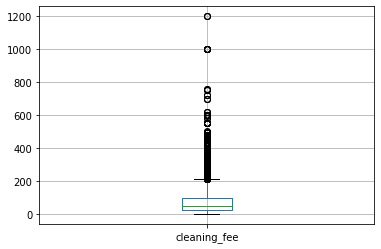

In [ ]:
#실행
boxplot = tmp_data.boxplot(column='cleaning_fee')
boxplot.plot()

In [ ]:
#실행
tmp_data['cleaning_fee'].describe()

count    121331.000000
mean         68.623682
std          61.555977
min           0.000000
25%          25.000000
50%          50.000000
75%         100.000000
max        1200.000000
Name: cleaning_fee, dtype: float64

이상치가 존재하기 때문에 결측치를 중앙값으로 대체하는 것이 좋아 보임

In [ ]:
#실행
tmp_data['cleaning_fee'] = tmp_data['cleaning_fee'].fillna(tmp_data['cleaning_fee'].median())

In [ ]:
#실행
tmp_data['cleaning_fee'].isnull().sum()

0

##### **guests_included**
기존 숙소에 guest가 얼머나 있는 지에 대한 변수<br>
price에 영향을 줄 수 있다 판단해서 설명 변수로 채택

결측치 확인

In [ ]:
#실행
tmp_data['guests_included'].isnull().sum()

0

In [ ]:
#실행
tmp_data['guests_included'].value_counts()

1     110233
2      27896
4       7252
3       3881
6       1751
5       1251
8        412
7        177
10       156
12        80
16        70
9         47
14        17
15        14
11        13
13         4
Name: guests_included, dtype: int64

결측치도 없을 분더러 해당 변수는 연속형 변수의 개념으로 사용하면 좋을 것 같음

##### **extra_people**
추가 인원 당 발생하는 비용<br>
추가 비용에 대한 개념이고 사후 변수라 판단함.

In [ ]:
#실행
tmp_data['extra_people'].isnull().sum()

0

혹시 몰라서 float으로 형변환 시켜놨습니다.(상관계수 확인 용도)

In [ ]:
tmp_data['extra_people'] = tmp_data['extra_people'].str[1:]
tmp_data['extra_people'] = tmp_data['extra_people'].str.replace(',','').astype('float')

**설명 변수로 채택 X 삭제 처리**

In [ ]:
#실행
tmp_data.drop('extra_people', axis=1, inplace=True)

##### **minimum_nights**
최소 숙박 일수에 대한 변수<br>
최소한의 숙박 일수가 커질수록 가격도 증가한다 판단되어 설명 변수로 사용하기로 결정

결측치 확인

In [ ]:
#실행
tmp_data['minimum_nights'].isnull().sum()

0

[]

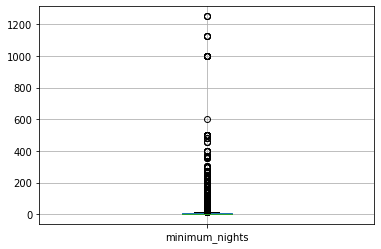

In [ ]:
#실행
boxplot = tmp_data.boxplot(column='minimum_nights')
boxplot.plot()

In [ ]:
#실행
tmp_data['minimum_nights'].describe()

count    153254.000000
mean          7.463838
std          21.631525
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        1250.000000
Name: minimum_nights, dtype: float64

연속된 정수형 변수의 개념으로 사용하면 좋을 것 같음

##### **maximum_nights**
설명 변수에서 제외<br>
이유 : 들쭉날쭉한 변수 분포, 큰 범위 내에서 왔다 갔다 하는 형태를 보여줌(빈약한 설명이라 생각)

In [ ]:
#실행
tmp_data['maximum_nights'].isnull().sum()

0

[]

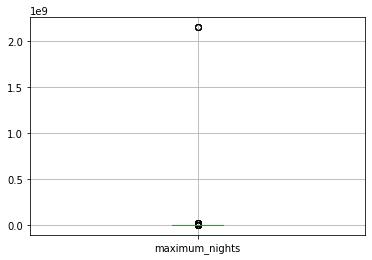

In [ ]:
#실행
boxplot = tmp_data.boxplot(column='maximum_nights')
boxplot.plot()

In [ ]:
#실행
tmp_data['maximum_nights'].describe()

count    1.532540e+05
mean     5.743367e+04
std      1.097179e+07
min      1.000000e+00
25%      2.900000e+01
50%      9.990000e+02
75%      1.125000e+03
max      2.147484e+09
Name: maximum_nights, dtype: float64

In [ ]:
#실행
tmp_data.drop('maximum_nights', axis=1, inplace=True)

##### **minimum_minumum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm**
minumum_nights, maximum_nights에서 파생된 변수들 목록(상관계수 관련 heatmap 참조)<br>
설명력이 떨어진다 판단되어 삭제 처리

In [ ]:
#실행
tmp_data.drop(['minimum_maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

##### **calendar_updated**
예약 유무를 판별할 수 있는 calendar를 update한 시기에 대한 정보가 담긴 변수<br>
price를 설명하는 데 있어 설명력이 떨어진다 판단해서 삭제 처리 진행 

In [ ]:
#실행
tmp_data.drop('calendar_updated', axis=1, inplace=True)

##### **has_availability**
이용 가능 여부<br>
안에 들어 있는 값이 전부 true라서 설명력이 떨어진다 판단함<br>
변수 삭제 처리

In [ ]:
#실행
tmp_data['has_availability'].isnull().sum()

0

결측치도 없을 분더러 전부 true 값만 들어있는 것을 확인할 수 있었음 

In [ ]:
#실행
tmp_data['has_availability'].value_counts()

t    153254
Name: has_availability, dtype: int64

In [ ]:
#실행
tmp_data.drop('has_availability', axis=1, inplace=True)

##### **availability_30, availability_60, availability_90, availability_365**
해당 일수 안에 숙박을 할 수 있는 기간에 대한 정보가 담긴 변수<br>
가격에 충분히 미칠 수 있는 변수라 판단되어 설명 변수로 채택

In [ ]:
#실행
tmp_data['availability_30'].isnull().sum()

0

In [ ]:
#실행
tmp_data['availability_60'].isnull().sum()

0

In [ ]:
#실행
tmp_data['availability_90'].isnull().sum()

0

In [ ]:
#실행
tmp_data['availability_365'].isnull().sum()

0

모두 결측치가 없는 것을 확인<br>연속형 변수(정수)로 사용하면 좋을 것 같음<br>
60, 90의 경우 30과 상관계수 값이 0.9를 넘어감 따라서 삭제 처리

In [ ]:
#실행
tmp_data.drop(['availability_60', 'availability_90'], axis=1, inplace=True)

##### **calendar_last_scraped**
calendar 스크랩과 관련된 정보<br>
가격과는 전혀 무관한 변수라 판단되어 설명 변수에서 삭제 처리

In [ ]:
#실행
tmp_data.drop('calendar_last_scraped', axis=1, inplace=True)

##### **number_of_reviews, number_of_reviews_ltm**
총 리뷰 개수와 가장 최근 1년간 리뷰 개수를 나타내는 변수<br>
가장 최근 1년간 리뷰 개수를 가리키는 number_of_reviews_ltm을 설명 변수로 채택해서 사용


In [ ]:
#실행
tmp_data.drop('number_of_reviews', axis=1, inplace=True)

결측치 확인

In [ ]:
tmp_data['number_of_reviews_ltm'].isnull().sum()

0

(정수)연속형 변수 개념으로 사용하면 좋을 것 같음

##### **first_review, last_review**
첫 리뷰 및 가장 최근 리뷰가 작성된 날짜에 대한 변수<br>
가격을 설명하는 데 있어 설득력이 떨어진다 판단되어 변수 삭제 처리

In [ ]:
#실행
tmp_data.drop(['first_review', 'last_review'], axis=1, inplace=True)

##### **review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value**
review 내에서 파생된 변수(상관계수가 높은 편)이기 때문에 대표 변수 하나(review_scores_ratings)를 선정해서 사용하려고 함<br>나머지 변수들은 전부 삭제 처리

In [ ]:
#실행
tmp_data.drop(['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'], axis=1, inplace=True)

##### **review_scores_ratings**
사용자들이 남긴 점수 리뷰이며 review score 관련된 변수 중 제일 설명력이 높다 생각해서 설명 변수로 채택

결측치 확인

In [ ]:
tmp_data['review_scores_rating'].isnull().sum()

33881

결측치가 대략 20% 정도 되는 것을 확인

[]

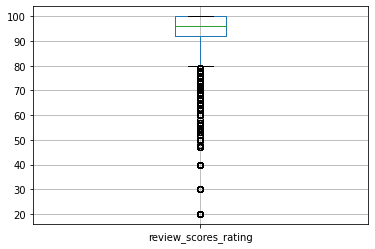

In [ ]:
boxplot = tmp_data.boxplot(column='review_scores_rating')
boxplot.plot()

In [ ]:
#실행
tmp_data['review_scores_rating'].describe()

count    119373.000000
mean         93.868454
std           8.794081
min          20.000000
25%          92.000000
50%          96.000000
75%         100.000000
max         100.000000
Name: review_scores_rating, dtype: float64

이상치가 존재하기 때문에 결측값들을 중앙값으로 대체해도 괜찮을 것 같음

In [ ]:
#실행
tmp_data['review_scores_rating'] = tmp_data['review_scores_rating'].fillna(tmp_data['review_scores_rating'].median())

In [ ]:
tmp_data['review_scores_rating'].isnull().sum()

0

##### **requires_license**
변수 내 하나의 값만 들어 있음<br>
설명력이 부족하다 판단되어 삭제 처리

In [ ]:
#실행
tmp_data['requires_license'].isnull().sum()

0

In [ ]:
#실행
tmp_data['requires_license'].value_counts()

f    153254
Name: requires_license, dtype: int64

In [ ]:
#실행
tmp_data.drop('requires_license',axis=1,inplace=True)

##### **license**
license 관련 정보가 담긴 변수<br>
마찬가지로 null value가 거의 100%이기 때문에 설명력이 떨어진다 판단했고 삭제 처리함

In [ ]:
#실행
tmp_data['license'].isnull().sum()

153168

In [ ]:
#실행
tmp_data['license'].value_counts()

81-1092926                   12
46-4091213                   11
35-2593481                    9
83-2444556                    9
20-5909724                    9
20-5163086                    8
47-3886130                    6
11-3461723                    6
20-0976501                    6
HUTB-162541                   3
City registration pending     3
47-4365717                    2
83-1780849                    2
Name: license, dtype: int64

In [ ]:
#실행
tmp_data.drop('license', axis=1, inplace=True)

##### **jurisdiction_name**
관할 구역 명에 대한 정보가 담긴 변수<br>
이 변수에서도 데이터 분포가 불균형을 보임(null -> 거의 100%)<br>변수 삭제 처리 진행

In [ ]:
#실행
tmp_data['jurisdiction_names'].isnull().sum()

153201

In [ ]:
#실행
tmp_data['jurisdiction_names'].value_counts()

{"Connecticut State"}                      25
{"Westchester County"," NY"}               11
{"New Jersey State"}                        4
{"Rensselaer County"," NY"}                 3
{"South Carolina State"}                    3
{"SAN FRANCISCO"}                           3
{"New Jersey State"," Elizabeth"," NJ"}     2
{"Florida State"}                           1
{"Georgia State"}                           1
Name: jurisdiction_names, dtype: int64

In [ ]:
#실행
tmp_data.drop('jurisdiction_names',axis=1,inplace=True)

##### **instant_bookable**
즉각적인 예약이 가능한 지에 대한 변수<br>
가격에 크게 미치는 변수인지는 잘 모르겠음(애매함)<br> 

결측치 확인

In [ ]:
tmp_data['instant_bookable'].isnull().sum()

0

In [ ]:
tmp_data['instant_bookable'].value_counts()

f    95103
t    58151
Name: instant_bookable, dtype: int64

In [ ]:
#실행
tmp_data.drop('instant_bookable', axis=1, inplace=True)

##### **is_business_travel_ready**
결측치 zero, But 데이터 분포가 일방적인 형태임(False:100%)<br>해당 변수 삭제 처리

In [ ]:
#실행
tmp_data['is_business_travel_ready'].isnull().sum()

0

In [ ]:
#실행
tmp_data['is_business_travel_ready'].value_counts()

f    153254
Name: is_business_travel_ready, dtype: int64

In [ ]:
#실행
tmp_data.drop('is_business_travel_ready', axis=1, inplace=True)

##### **cancellation_policy**
취소 정책에 관한 정보가 담긴 변수<br>
취소 정책은 가격과 직결되는 경우가 많음<br>따라서 설명력이 있을 것이라 판단해 설명 변수로 채택

결측치 확인

In [ ]:
#실행
tmp_data['cancellation_policy'].isnull().sum()

0

범주형 변수 임을 확인할 수 있음
<br>one hot encoding 작업을 통해 해당 변수를 전처리할 예정

In [ ]:
#실행
tmp_data['cancellation_policy'].value_counts()

strict_14_with_grace_period    70025
flexible                       46508
moderate                       36171
super_strict_60                  293
strict                           186
super_strict_30                   71
Name: cancellation_policy, dtype: int64

비슷한 범주는 묶는 작업이 좋을 것 같아 numpy를 토대로 공통된 특성을 가진 변수들을 묶는 작업 진행

In [ ]:
#실행
tmp_data['cancellation_policy'] = np.where((tmp_data['cancellation_policy'] == 'super_strict_60') | (tmp_data['cancellation_policy'] == 'super_strict_30'), 'super_strict', tmp_data['cancellation_policy'])

In [ ]:
#실행
tmp_data['cancellation_policy'] = np.where((tmp_data['cancellation_policy'] == 'strict_14_with_grace_period') | (tmp_data['cancellation_policy'] == 'strict'), 'strict', tmp_data['cancellation_policy'])

In [ ]:
tmp_data['cancellation_policy'].value_counts()

strict          70211
flexible        46508
moderate        36171
super_strict      364
Name: cancellation_policy, dtype: int64

범주형 변수이기 때문에 one hot encoding 진행

In [ ]:
#실행
tmp_data = pd.get_dummies(tmp_data, columns=['cancellation_policy'])

##### **require_guest_profile_picture, require_guest_phone_verification**
사용자의 개인 정보 요구에 대한 변수<br>
가격을 설명하는 데 있어 설명력이 떨어진다 판단되어 삭제 처리

In [ ]:
#실행
tmp_data.drop(['require_guest_profile_picture', 'require_guest_phone_verification'], axis=1, inplace=True)

##### **calculated_host_listing_count, calculated_host_listing_count_entire_homes, calculated_host_listing_count_private_homes, calculated_host_listing_count_shared_homes**
현재 host가 운영하고 있는 item의 수와 관련된 정보 <br>calculated_host_listing_count 변수 만으로도 나머지 3개의 변수를 충분히 설명할 수 있음(상관계수가 매우 높음)<br>4개 변수 모두 가격을 설명하는 데 있어 설명력이 떨어진다 판단되어 삭제 처리

In [ ]:
#실행
tmp_data.drop(['calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_shared_rooms', 
               'calculated_host_listings_count', 'calculated_host_listings_count_private_rooms'], axis=1, inplace=True)

##### **reviews_per_month**
월 평균 리뷰 개수<br>
가격에 영향을 줄 수 있는 항목이라 생각해 설명 변수로 채택

결측치 존재 여부

In [ ]:
tmp_data['reviews_per_month'].isnull().sum()

30965

[]

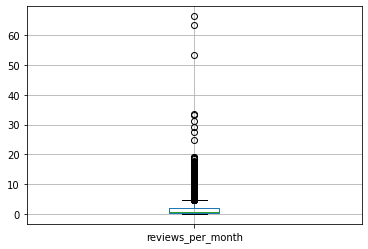

In [ ]:
boxplot = tmp_data.boxplot(column='reviews_per_month')
boxplot.plot()

In [ ]:
tmp_data['reviews_per_month'].describe()

count    122289.000000
mean          1.336353
std           1.648065
min           0.000000
25%           0.190000
50%           0.690000
75%           2.000000
max          66.360000
Name: reviews_per_month, dtype: float64

float형 연속형 변수로 변환<br>
결측값 처리는 중앙값으로 하는 것이 좋아보임

In [ ]:
#실행
tmp_data['reviews_per_month'] = tmp_data['reviews_per_month'].fillna(tmp_data['reviews_per_month'].median())

In [ ]:
tmp_data['reviews_per_month'].isnull().sum()

0

##### **남아 있는 변수 확인**

price의 float 형변환
<br>-> $와 , 기호를 없애기 위한 작업 진행

In [ ]:
#실행
tmp_data['price'] = data['price'].str[1:]
tmp_data['price'] = tmp_data['price'].str.replace(',','').astype('float')

In [ ]:
tmp_data['price'].head(30)

0     225.0
1      89.0
2     200.0
3      60.0
4      79.0
5      79.0
6     150.0
7      99.0
8      89.0
9      85.0
10    120.0
11    140.0
12    199.0
13    140.0
14     99.0
15    190.0
16    299.0
17    115.0
18     32.0
19    120.0
20     80.0
21     44.0
22    175.0
23     50.0
24     52.0
25     50.0
26     70.0
27     89.0
28     85.0
29    150.0
Name: price, dtype: float64

In [ ]:
tmp_data.head(10)

latitude  ...  neighbourhood_group_cleansed_Staten Island
0  40.75362  ...                                           0
1  40.68514  ...                                           0
2  40.74767  ...                                           0
3  40.68688  ...                                           0
4  40.76489  ...                                           0
5  40.80178  ...                                           0
6  40.71344  ...                                           0
7  40.76076  ...                                           0
8  40.66829  ...                                           0
9  40.79826  ...                                           0

[10 rows x 441 columns]

**최종적으로 남은 변수 list**
<br>
'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'cleaning_fee',
 'guests_included',
 'minimum_nights',
 'availability_30',
 'availability_365',
 'number_of_reviews_ltm',
 'review_scores_rating',
 'reviews_per_month',
 'host_is_superhost_f',
 'host_is_superhost_t',
 'neighbourhood_group_cleansed_Bronx',
 'neighbourhood_group_cleansed_Brooklyn',
 'neighbourhood_group_cleansed_Manhattan',
 'neighbourhood_group_cleansed_Queens',
 'neighbourhood_group_cleansed_Staten Island',
 'room_type_Entire home/apt',
 'room_type_Hotel room',
 'room_type_Private room',
 'room_type_Shared room',
 'property_type_Apartment',
 'property_type_Condominium',
 'property_type_House',
 'property_type_Loft',
 'property_type_Others',
 'property_type_Townhouse',
 'amenities_ 관련 더미 변수',
 'cancellation_policy 더미변수'

In [ ]:
#실행
final_col_list = tmp_data.columns.tolist()

In [ ]:
#실행
final_col_list

['latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'cleaning_fee',
 'guests_included',
 'minimum_nights',
 'availability_30',
 'availability_365',
 'number_of_reviews_ltm',
 'review_scores_rating',
 'reviews_per_month',
 'host_is_superhost_f',
 'host_is_superhost_t',
 'neighbourhood_group_cleansed_Bronx',
 'neighbourhood_group_cleansed_Brooklyn',
 'neighbourhood_group_cleansed_Manhattan',
 'neighbourhood_group_cleansed_Queens',
 'neighbourhood_group_cleansed_Staten Island',
 'room_type_Entire home/apt',
 'room_type_Hotel room',
 'room_type_Private room',
 'room_type_Shared room',
 'property_type_Apartment',
 'property_type_Condominium',
 'property_type_House',
 'property_type_Loft',
 'property_type_Others',
 'property_type_Townhouse',
 'amenities_Body soap',
 'amenities_Beachfront',
 'amenities_Pack ’n Play/travel crib',
 'amenities_BBQ grill',
 'amenities_Bathrobes',
 'amenities_Ski-in/Ski-out',
 'amenities_Cat(s)',
 'amenities_Accessible-height

# **2. EDA(완료)**

### **(1) 변수 시각화**

##### **last_scraped**

**One Hot Encoding을 토대로 나온 변수**
<br>'last_scraped_2020-01-03'<br>
 'last_scraped_2020-01-04'<br>
 'last_scraped_2020-01-05'<br>
 'last_scraped_2020-01-06'<br>
 'last_scraped_2020-02-12'<br>
 'last_scraped_2020-02-13'<br>
 'last_scraped_2020-03-14'<br>
 'last_scraped_2020-03-15'

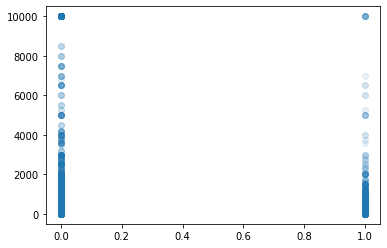

In [ ]:
plt.scatter(tmp_data['last_scraped_2020-01-03'], tmp_data['price'], alpha=0.1)

In [ ]:
tmp_data.groupby(tmp_data['last_scraped_2020-01-03']==1)['price'].describe()

count        mean  ...    75%      max
last_scraped_2020-01-03                        ...                
False                    127882.0  164.927746  ...  175.0  10000.0
True                      25372.0  151.288704  ...  175.0  10000.0

[2 rows x 8 columns]

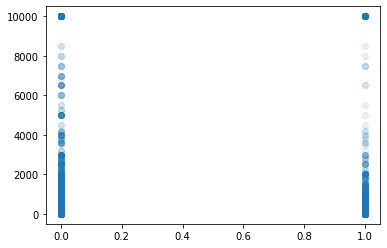

In [ ]:
plt.scatter(tmp_data['last_scraped_2020-01-04'], tmp_data['price'], alpha=0.1)

In [ ]:
tmp_data.groupby(tmp_data['last_scraped_2020-01-04']==1)['price'].describe()

count        mean  ...    75%      max
last_scraped_2020-01-04                        ...                
False                    127274.0  160.867656  ...  175.0  10000.0
True                      25980.0  171.497960  ...  175.0  10000.0

[2 rows x 8 columns]

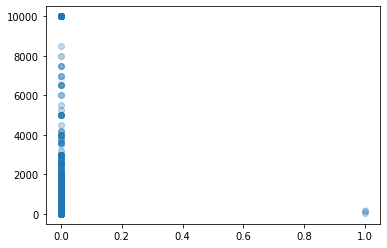

In [ ]:
plt.scatter(tmp_data['last_scraped_2020-01-05'], tmp_data['price'], alpha=0.1)

In [ ]:
tmp_data.groupby(tmp_data['last_scraped_2020-01-05']==1)['price'].describe()

count        mean  ...     75%      max
last_scraped_2020-01-05                        ...                 
False                    153246.0  162.671965  ...  175.00  10000.0
True                          8.0  119.875000  ...  159.25    200.0

[2 rows x 8 columns]

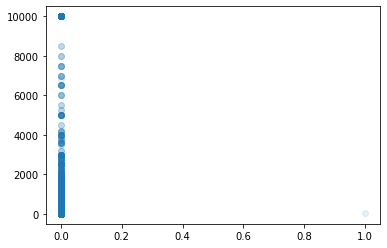

In [ ]:
plt.scatter(tmp_data['last_scraped_2020-01-06'], tmp_data['price'], alpha=0.1)

In [ ]:
tmp_data.groupby(tmp_data['last_scraped_2020-01-06']==1)['price'].describe()

count        mean  ...    75%      max
last_scraped_2020-01-06                        ...                
False                    153253.0  162.670382  ...  175.0  10000.0
True                          1.0   63.000000  ...   63.0     63.0

[2 rows x 8 columns]

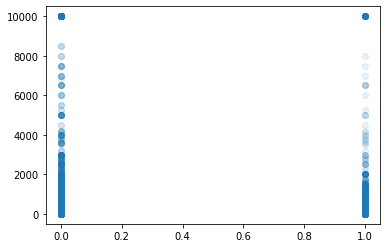

In [ ]:
plt.scatter(tmp_data['last_scraped_2020-02-12'], tmp_data['price'], alpha=0.1)

In [ ]:
tmp_data.groupby(tmp_data['last_scraped_2020-02-12']==1)['price'].describe()

count        mean  ...    75%      max
last_scraped_2020-02-12                        ...                
False                    122840.0  161.755275  ...  175.0  10000.0
True                      30414.0  166.363155  ...  184.0  10000.0

[2 rows x 8 columns]

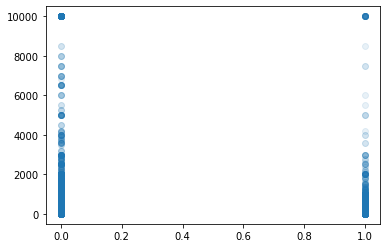

In [ ]:
plt.scatter(tmp_data['last_scraped_2020-02-13'], tmp_data['price'], alpha=0.1)

In [ ]:
tmp_data.groupby(tmp_data['last_scraped_2020-02-13']==1)['price'].describe()

count        mean  ...    75%      max
last_scraped_2020-02-13                        ...                
False                    132571.0  164.453365  ...  178.0  10000.0
True                      20683.0  151.237248  ...  159.0  10000.0

[2 rows x 8 columns]

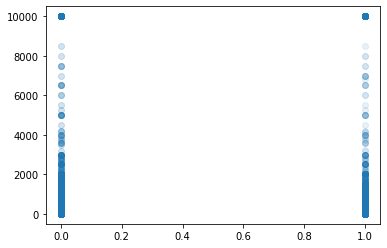

In [ ]:
plt.scatter(tmp_data['last_scraped_2020-03-14'], tmp_data['price'], alpha=0.1)

In [ ]:
tmp_data.groupby(tmp_data['last_scraped_2020-03-14']==1)['price'].describe()

count        mean  ...    75%      max
last_scraped_2020-03-14                        ...                
False                    102459.0  160.874047  ...  175.0  10000.0
True                      50795.0  166.291820  ...  175.0  10000.0

[2 rows x 8 columns]

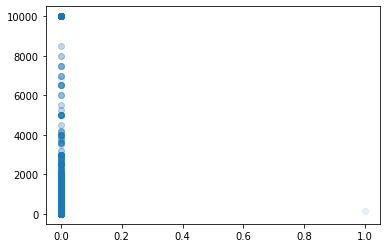

In [ ]:
plt.scatter(tmp_data['last_scraped_2020-03-15'], tmp_data['price'], alpha=0.1)

In [ ]:
tmp_data.groupby(tmp_data['last_scraped_2020-03-15']==1)['price'].describe()

count       mean         std  ...    50%    75%      max
last_scraped_2020-03-15                                   ...                       
False                    153253.0  162.66982  401.015654  ...  105.0  175.0  10000.0
True                          1.0  149.00000         NaN  ...  149.0  149.0    149.0

[2 rows x 8 columns]

분포도로나 mean값을 확인해도 큰 차이가 없으므로 의미 없는 데이터로 보임
또한, 해당 데이터를 scraped 한 것만으로 각각의 숙소에 대한 주말 및 평일, 비수기, 성수기에 대한 가격 예측이 어려울 것이라 생각

##### **host_is_superhost**
'host_is_superhost_f'<br>
 'host_is_superhost_t'

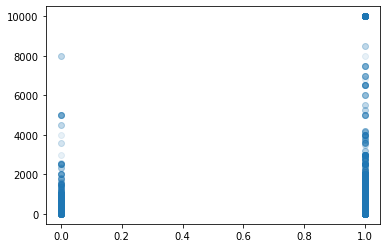

In [ ]:
plt.scatter(tmp_data['host_is_superhost_f'], tmp_data['price'], alpha=0.1)

In [ ]:
tmp_data.groupby(tmp_data['host_is_superhost_f']==1)['price'].describe()

count        mean         std  ...    50%    75%      max
host_is_superhost_f                                    ...                       
False                 30149.0  148.953929  191.601366  ...  110.0  175.0   8000.0
True                 123105.0  166.028797  437.205586  ...  104.0  175.0  10000.0

[2 rows x 8 columns]

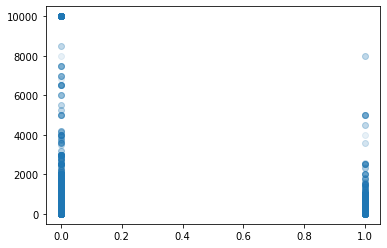

In [ ]:
plt.scatter(tmp_data['host_is_superhost_t'], tmp_data['price'], alpha=0.1)

In [ ]:
tmp_data.groupby(tmp_data['host_is_superhost_t']==1)['price'].describe()

count        mean         std  ...    50%    75%      max
host_is_superhost_t                                    ...                       
False                123309.0  166.024134  436.955896  ...  104.0  175.0  10000.0
True                  29945.0  148.856804  191.197349  ...  110.0  175.0   8000.0

[2 rows x 8 columns]

꽤나 의미있는 분포를 보여줌<br> 추가 전처리 없이 one hot encoding을 토대로 설명 변수로 사용하면 좋을 것 같음

##### **longitude, latitude**


Text(0.5, 0, 'price')

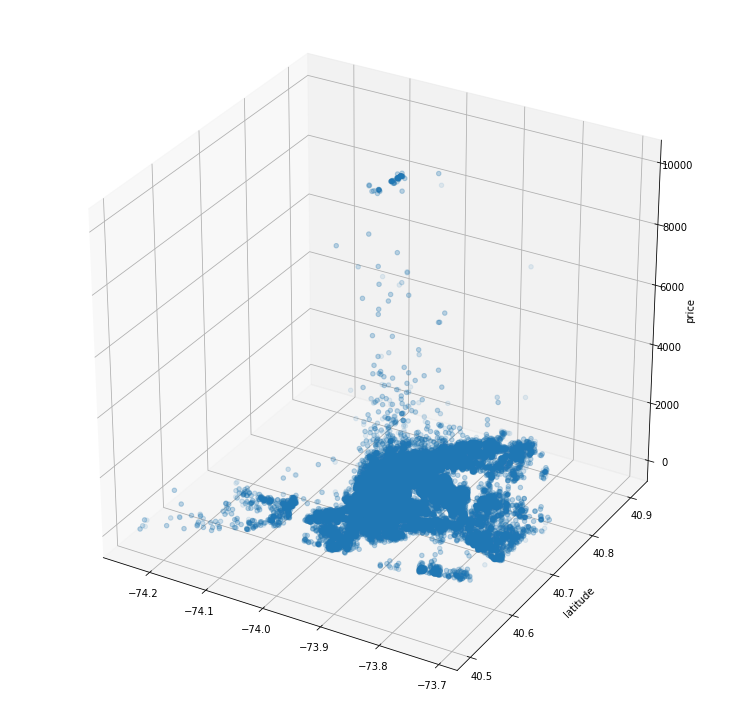

In [ ]:
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tmp_data['longitude'],tmp_data['latitude'], tmp_data['price'],alpha=0.1)
ax.set_ylabel('latitude')
ax.set_zlabel('price')

위도, 경도 별로 고르게 분포되어 있는 모습을 확인할 수 있음<br> 추가 전처리 없이 설명 변수로 사용

##### **accommodates**


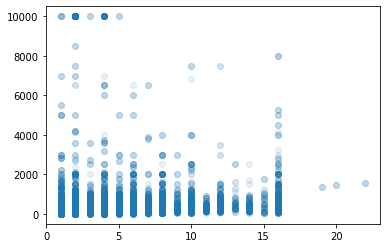

In [ ]:
plt.scatter(tmp_data['accommodates'], tmp_data['price'], alpha=0.1)

값에 따라 다양한 분포를 보이고 있음<br>설명 변수로 사용하는 데 있어 적절해 보임

##### **bathrooms**

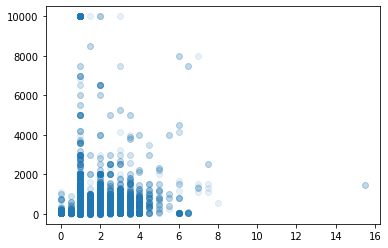

In [ ]:
plt.scatter(tmp_data['bathrooms'], tmp_data['price'], alpha=0.1)

##### **bedrooms**

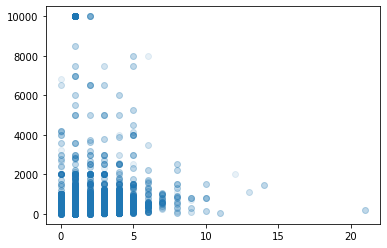

In [ ]:
plt.scatter(tmp_data['bedrooms'], tmp_data['price'], alpha=0.1)

##### **beds**

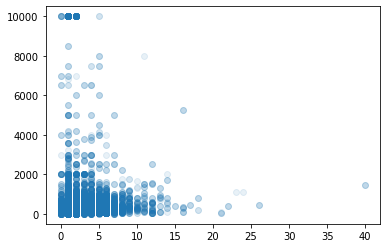

In [ ]:
plt.scatter(tmp_data['beds'], tmp_data['price'], alpha=0.1)

##### **cleaning_fee**

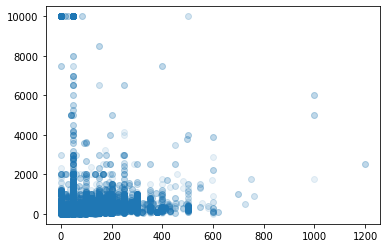

In [ ]:
plt.scatter(tmp_data['cleaning_fee'], tmp_data['price'], alpha=0.1)

##### **guesets_included**

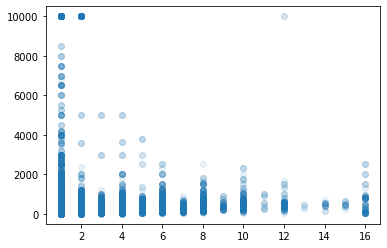

In [ ]:
plt.scatter(tmp_data['guests_included'], tmp_data['price'], alpha=0.1)

##### **minimum_nights**

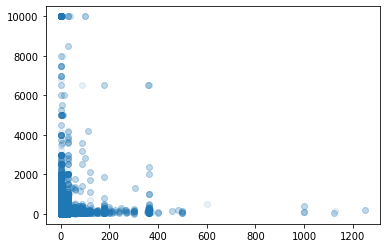

In [ ]:
plt.scatter(tmp_data['minimum_nights'], tmp_data['price'], alpha=0.1)

##### **availability_30, availability_60, availability_90, availability_365**

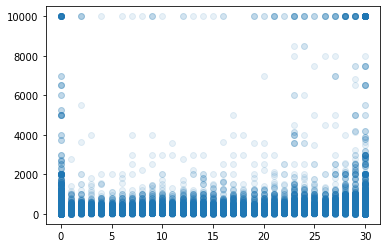

In [ ]:
plt.scatter(tmp_data['availability_30'], tmp_data['price'], alpha=0.1)

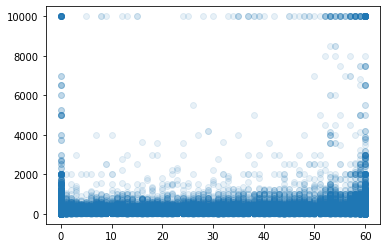

In [ ]:
plt.scatter(tmp_data['availability_60'], tmp_data['price'], alpha=0.1)

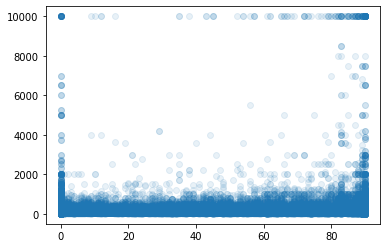

In [ ]:
plt.scatter(tmp_data['availability_90'], tmp_data['price'], alpha=0.1)

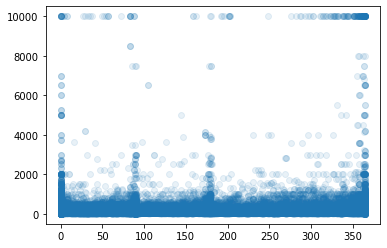

In [ ]:
plt.scatter(tmp_data['availability_365'], tmp_data['price'], alpha=0.1)

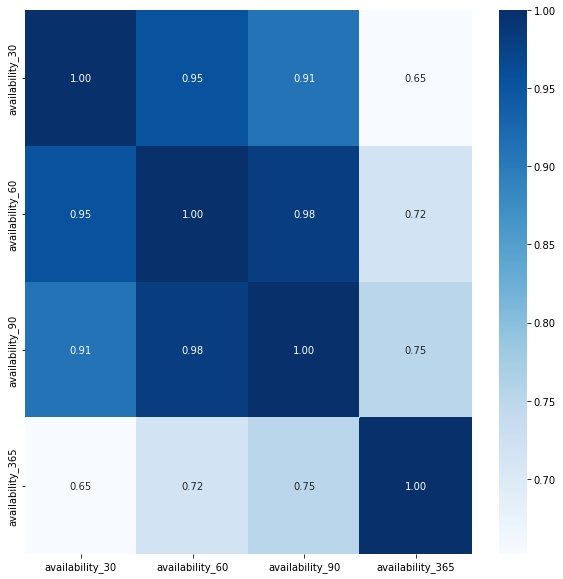

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(tmp_data.loc[:,['availability_30','availability_60','availability_90','availability_365']].corr(), fmt = '.2f', cmap = 'Blues',annot=True)

상관관계를 보았을 때 availability30과 availability365 2개만 사용해도 될 것으로 보임.

##### **number_of_reviews_ltm**

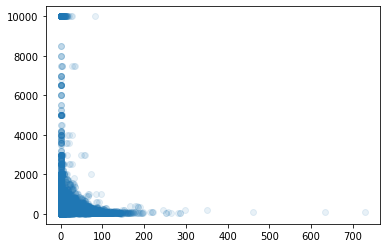

In [ ]:
plt.scatter(tmp_data['number_of_reviews_ltm'], tmp_data['price'], alpha=0.1)

##### **review_scores_rating**

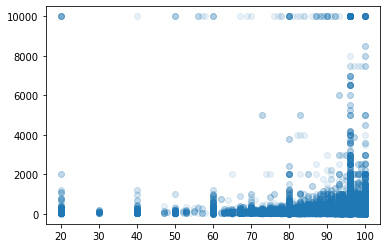

In [ ]:
plt.scatter(tmp_data['review_scores_rating'], tmp_data['price'], alpha=0.1)

##### **review_per_month**

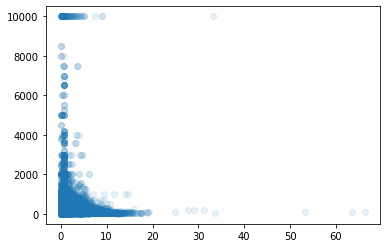

In [ ]:
plt.scatter(tmp_data['reviews_per_month'], tmp_data['price'], alpha=0.1)

##### **room_type**

'room_type_Entire home/apt'<br>
 'room_type_Hotel room'<br>
 'room_type_Private room'<br>
 'room_type_Shared room'<br>

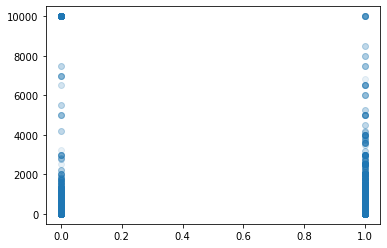

In [ ]:
plt.scatter(tmp_data['room_type_Entire home/apt'], tmp_data['price'], alpha=0.1)

In [ ]:
tmp_data.groupby(tmp_data['room_type_Entire home/apt']==1)['price'].describe()

count       mean  ...    75%      max
room_type_Entire home/apt                      ...                
False                      73877.0  112.81503  ...   95.0  10000.0
True                       79377.0  209.07002  ...  225.0  10000.0

[2 rows x 8 columns]

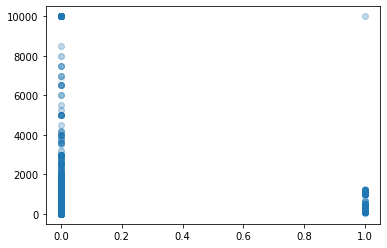

In [ ]:
plt.scatter(tmp_data['room_type_Hotel room'], tmp_data['price'], alpha=0.1)

In [ ]:
tmp_data.groupby(tmp_data['room_type_Hotel room']==1)['price'].describe()

count        mean         std  ...    50%    75%      max
room_type_Hotel room                                    ...                       
False                 152052.0  161.682937  399.521547  ...  105.0  175.0  10000.0
True                    1202.0  287.498336  544.540566  ...  179.0  300.0  10000.0

[2 rows x 8 columns]

Hotel의 경우 가격이 높은 경우(이상치)가 존재

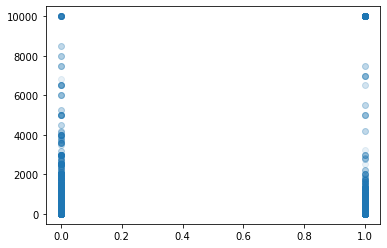

In [ ]:
plt.scatter(tmp_data['room_type_Private room'], tmp_data['price'], alpha=0.1)

In [ ]:
tmp_data.groupby(tmp_data['room_type_Private room']==1)['price'].describe()

count        mean         std  ...    50%    75%      max
room_type_Private room                                   ...                       
False                   84308.0  204.670921  288.485691  ...  152.0  225.0  10000.0
True                    68946.0  111.310170  500.895420  ...   70.0   95.0  10000.0

[2 rows x 8 columns]

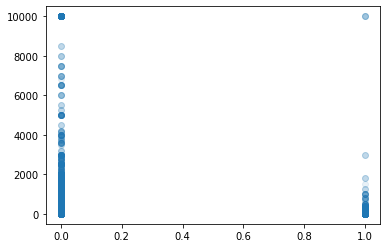

In [ ]:
plt.scatter(tmp_data['room_type_Shared room'], tmp_data['price'], alpha=0.1)

In [ ]:
tmp_data.groupby(tmp_data['room_type_Shared room']==1)['price'].describe()

count        mean         std  ...    50%    75%      max
room_type_Shared room                                    ...                       
False                  149525.0  164.623407  401.157143  ...  110.0  178.0  10000.0
True                     3729.0   84.331456  387.259252  ...   45.0   70.0  10000.0

[2 rows x 8 columns]

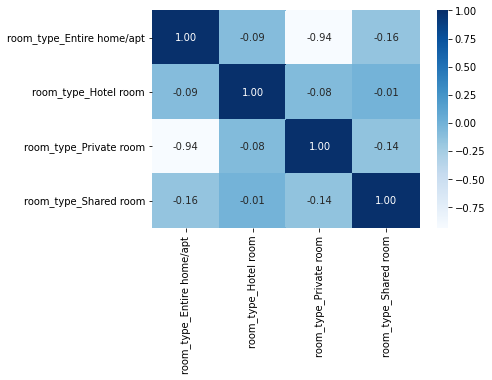

In [ ]:
sns.heatmap(tmp_data.loc[:,['room_type_Entire home/apt', 'room_type_Hotel room','room_type_Private room','room_type_Shared room']].corr(), fmt = '.2f', cmap = 'Blues',annot=True)
#sns.heatmap(tmp_data.loc[:,['room_type_Entire home/apt','room_type_Private room','room_type_Shared room','room_type_Hotel room']].corr(), fmt = '.2f', cmap = 'Blues',annot=True)

room_type의 데이터 현황을 살펴보면

In [ ]:
data['room_type'].value_counts()

Entire home/apt    79377
Private room       68946
Shared room         3729
Hotel room          1202
Name: room_type, dtype: int64

In [ ]:
len(data['room_type'])

153254

##### **cancellation_policy**

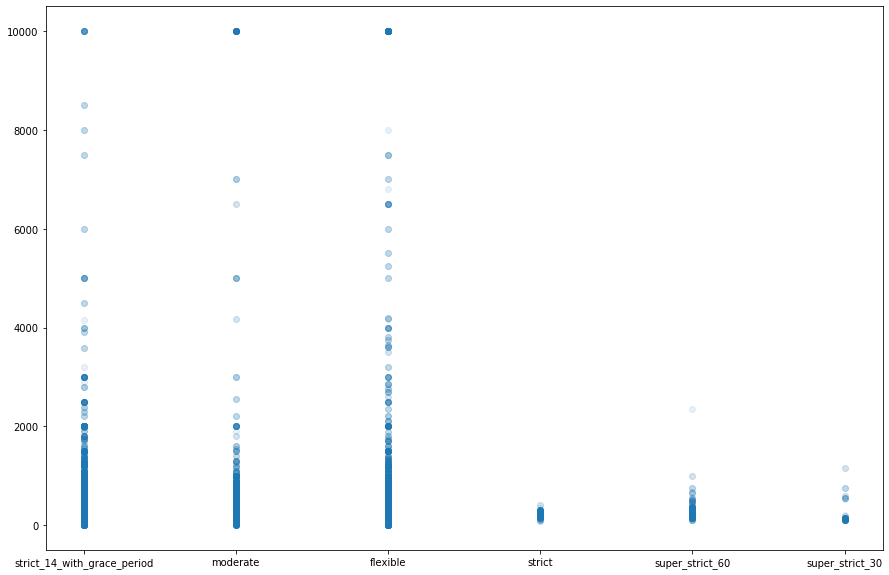

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(data['cancellation_policy'], tmp_data['price'], alpha=0.1)

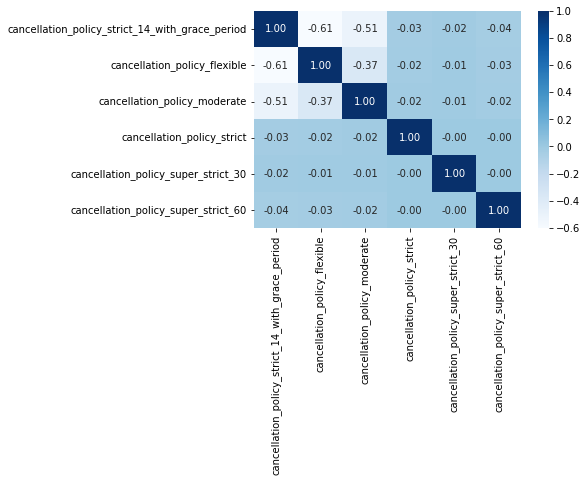

In [ ]:
sns.heatmap(tmp_data.loc[:,['cancellation_policy_strict_14_with_grace_period','cancellation_policy_flexible','cancellation_policy_moderate','cancellation_policy_strict','cancellation_policy_super_strict_30','cancellation_policy_super_strict_60']].corr(), fmt = '.2f', cmap = 'Blues',annot=True)

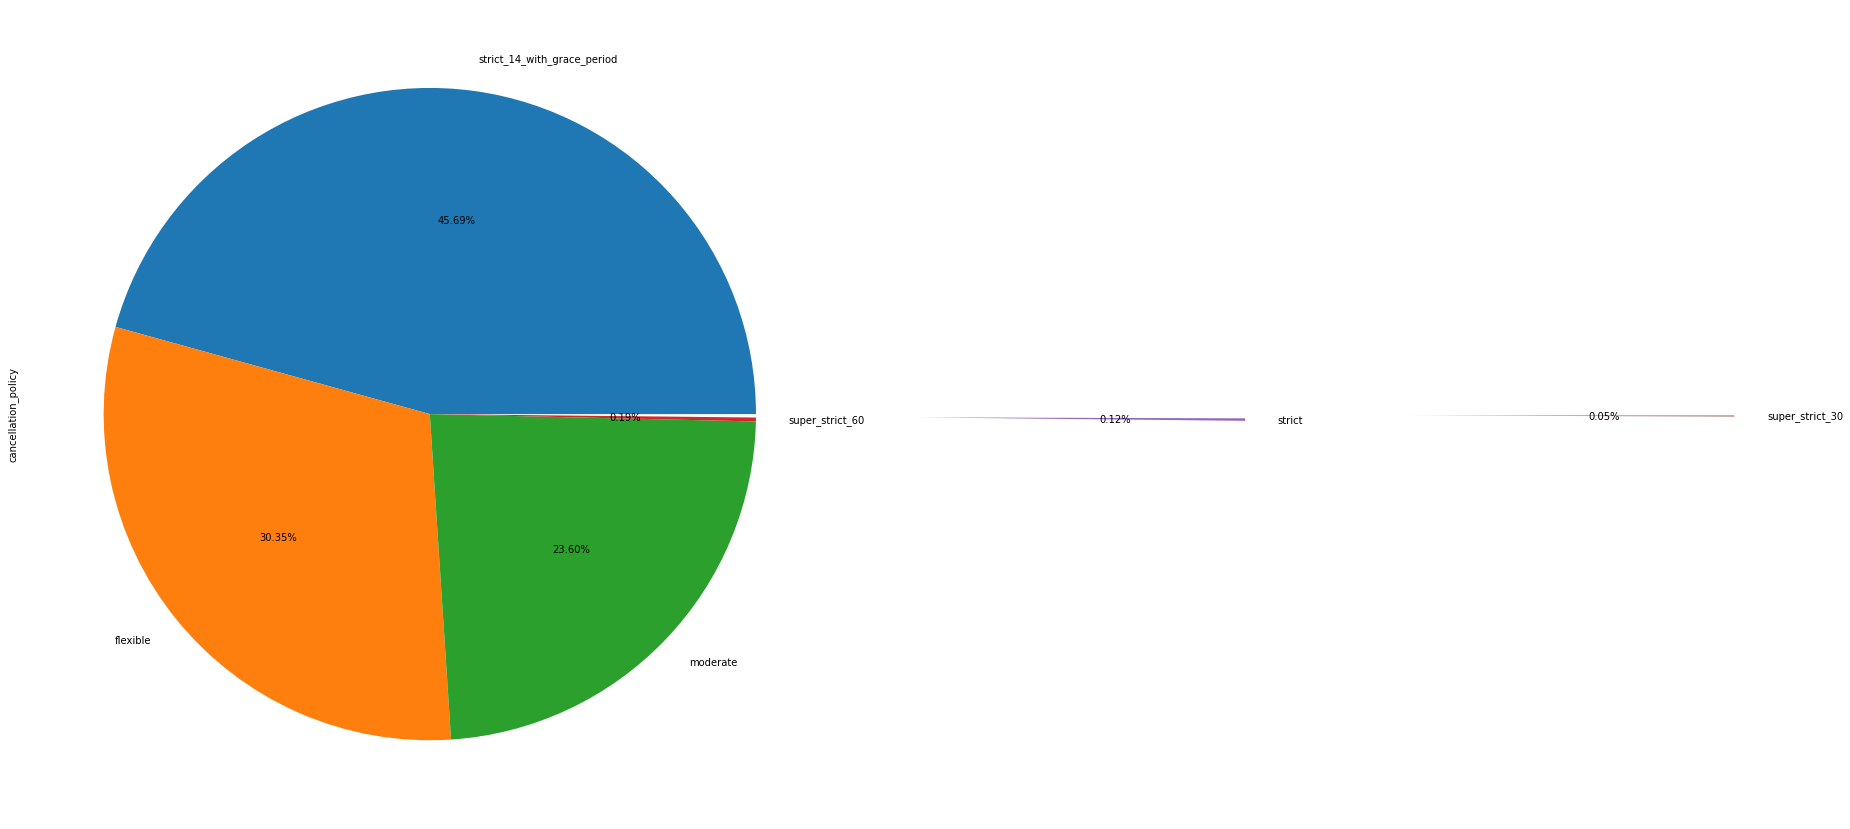

In [ ]:
plt.figure(figsize=(15,15))

data['cancellation_policy'].value_counts().plot.pie(autopct='%1.2f%%', explode=[0, 0, 0, 0, 1.5, 3])

plt.show()

<br> flexible: 게스트는 체크인 24시간 전까지 예약을 취소할 경우 전액 환불 받을 수 있으며, 호스트에게 대금이 지급되지 않음
<br>
<br> moderate: 게스트가 체크인 5일 전까지 예약을 취소할 경우 전액 환불 받을 수 있으며, 호스트에게 대금이 지급되지 않음
<br>
<br> strict: 게스트는 예약 후 48시간 이내에 취소하고 체크인까지 14일 이상 남은 경우에만 전액 환불을 받을 수 있음
<br> 체크인까지 7~14일까지 남은 경우 숙박비 50%가 호스트에게 지급되고, 그 후에 취소하는 경우, 전액이 호스트에게 지급 (strict과 strict_14_with_grace_period의 차이에 대한 설명이 따로 없음, 유사하다고 생각되고 strict이 전체 cancellation policy에 차지하는 비율이 매우 적으므로 합쳐도 된다고 생각함)
<br>
<br>super_strict_30, super_strict_60 : 해당 정책들은 특정한 경우에 초대받은 호스트만 적용할 수 있음. 게스트가 체크인까지 각각 30일 60일 이상 남은 시점에 취소하면, 숙박 대금의 50%가 환불되며 그 후에 취소하면 전액 호스트에게 지급. (서로 상관관계는 0이지만 정책 내용이 유사하고 해당 변수가 전체 cancellation policy에 대해 차지하고 있는 비율이 현저히 적으므로 합쳐도 괜찮다고 생각)
<br>
**일단 테스트 용으로 4개 범주로 통합 예정**<br>
flexible, moderate, strict_14_with_grace_period, others

##### **property_type**

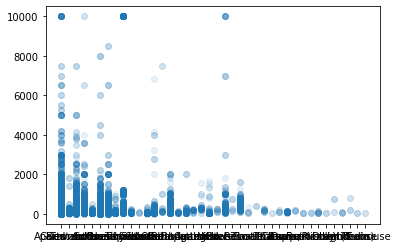

In [ ]:
plt.scatter(tmp_data['property_type'], tmp_data['price'], alpha=0.1)

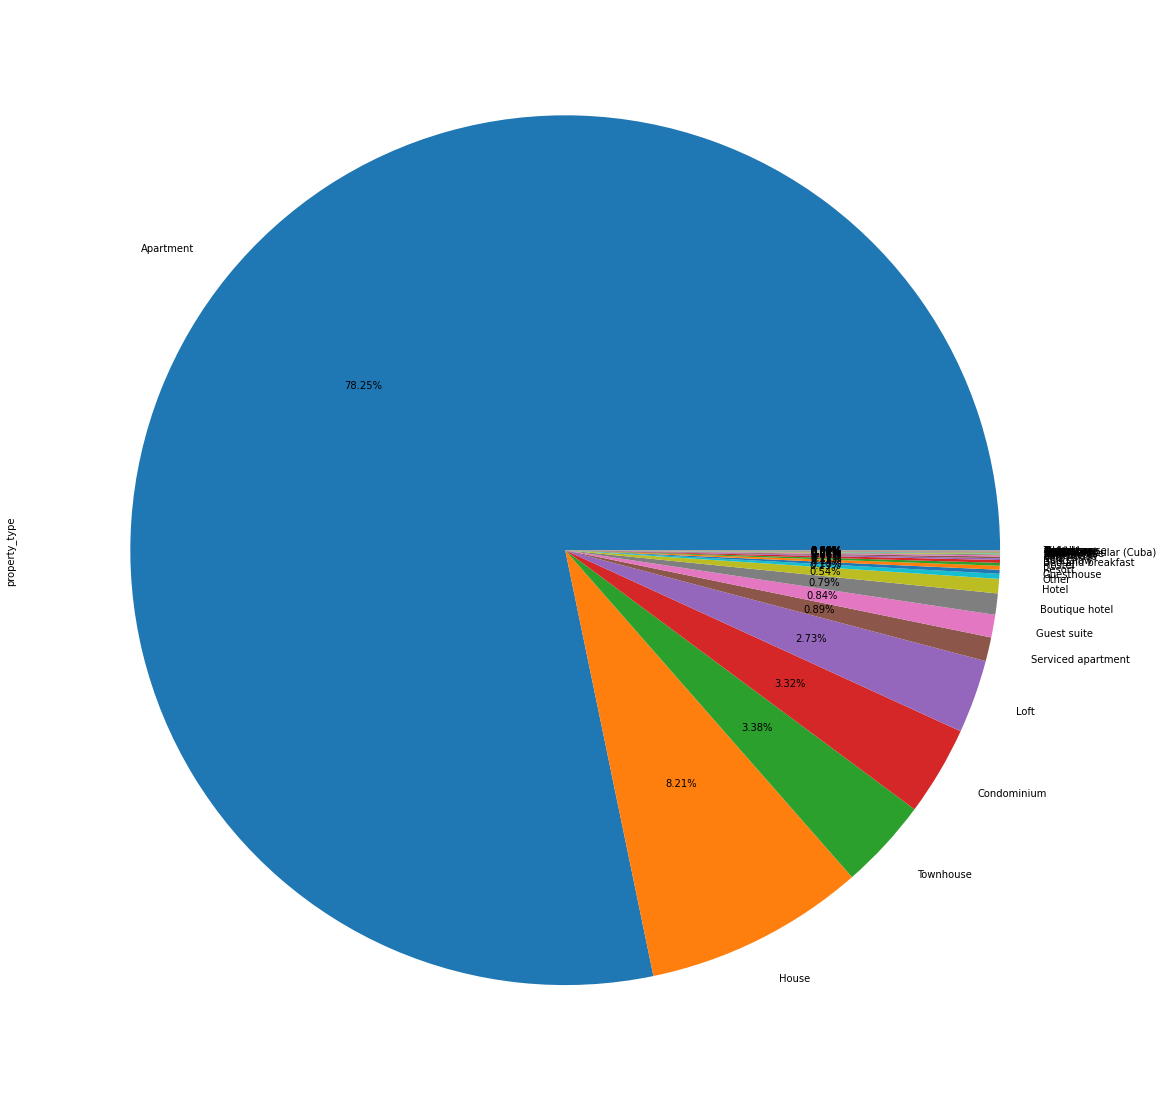

In [ ]:
plt.figure(figsize=(20,20))
data['property_type'].value_counts().plot.pie(autopct='%1.2f%%')

plt.show()

Apartment가 전체의 78.25%차지하고 그 뒤로 House(8.21%), Townhouse(3.38%), Condominium(3.32%), Loft(2.73%) 순이다. 나머지는 약 4%의 비중을 차지하고 있으므로 others로 분류해도 괜찮다고 생각. 

In [ ]:
len(data['neighbourhood_group_cleansed'].unique())

5

##### **neighbourhood, neighbourhood_group_cleansed**
**neighbourhood** : 총 207개<br>
**neighbourhood_group_cleansed** : 총 5개
<br>
'neighbourhood_group_cleansed_Bronx',
 'neighbourhood_group_cleansed_Brooklyn',
 'neighbourhood_group_cleansed_Manhattan',
 'neighbourhood_group_cleansed_Queens',
 'neighbourhood_group_cleansed_Staten Island' 



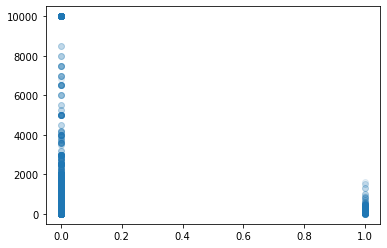

In [ ]:
plt.scatter(tmp_data['neighbourhood_group_cleansed_Bronx'], tmp_data['price'], alpha=0.1)

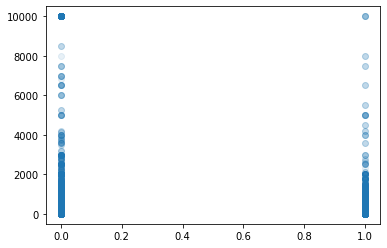

In [ ]:
plt.scatter(tmp_data['neighbourhood_group_cleansed_Brooklyn'], tmp_data['price'], alpha=0.1)

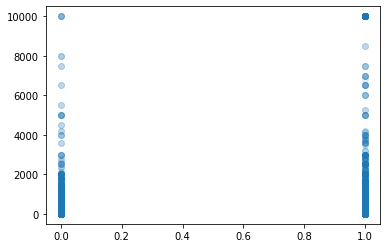

In [ ]:
plt.scatter(tmp_data['neighbourhood_group_cleansed_Manhattan'], tmp_data['price'], alpha=0.1)

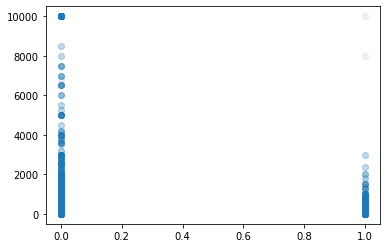

In [ ]:
plt.scatter(tmp_data['neighbourhood_group_cleansed_Queens'], tmp_data['price'], alpha=0.1)

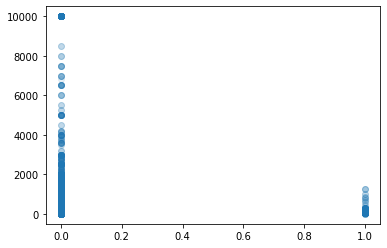

In [ ]:
plt.scatter(tmp_data['neighbourhood_group_cleansed_Staten Island'], tmp_data['price'], alpha=0.1)

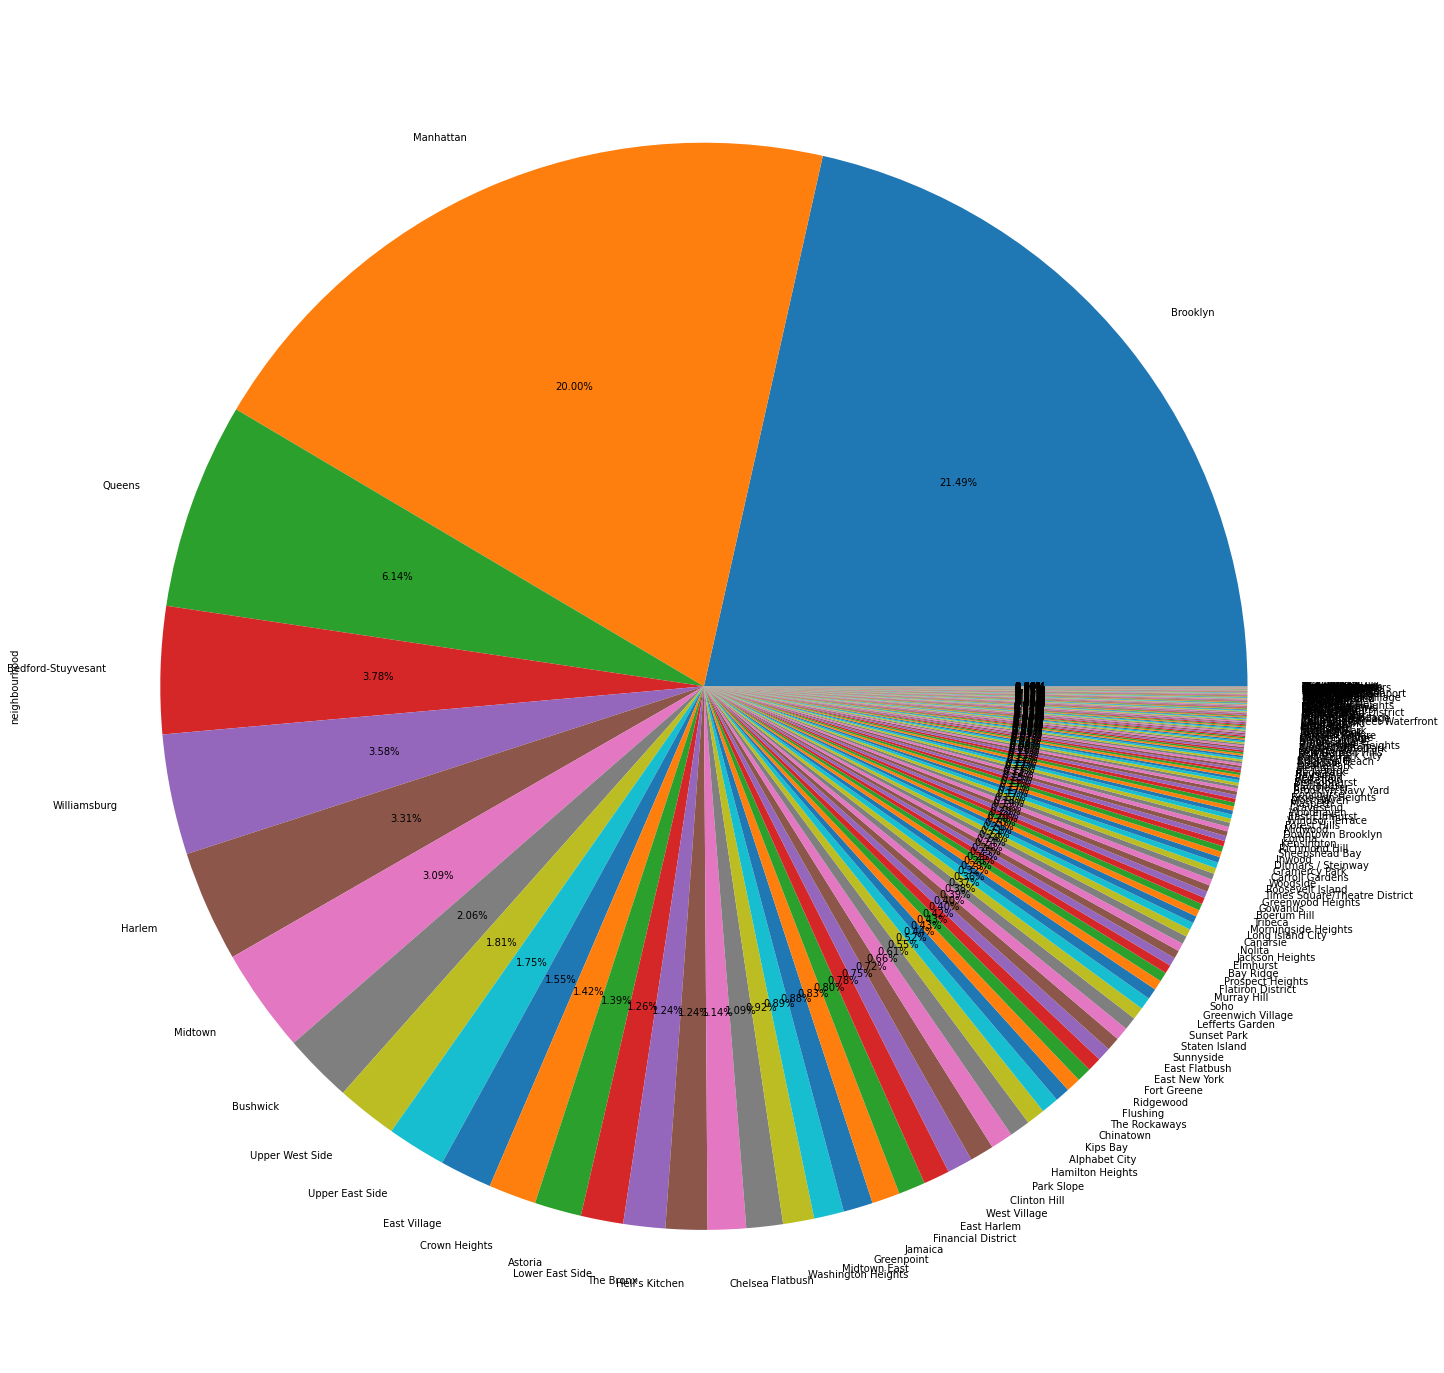

In [ ]:
plt.figure(figsize=(25,25))
data['neighbourhood'].value_counts().plot.pie(autopct='%1.2f%%')

plt.show()

##### **amenities**
편의 시설은 많으면 많을 수록 좋다 생각함<br>
그래서 지금 생각 중인 방향은 
1. amenities의 개수를 담은 파생 변수를 하나 생성할 지<br>
2. 실내 amenities, 실외 amenities로 분류해서 파생 변수를 제작할 지<br>
3. 그냥 one hot encoding만 해서 amenities를 각각 따로따로 볼 지<br>

# **3. Modeling(하이퍼 파라미터 조작 X)**

###**(0). Train/Test Set Split**

**모델링을 위한 tmp_data 복사**

In [ ]:
#실행
model_df = copy.deepcopy(tmp_data)

train, validation, test set을 6:2:2의 비율로 분할 

In [ ]:
#실행
from sklearn.model_selection import train_test_split

train, test = train_test_split(model_df, test_size=0.4, random_state=1234)
val, test = train_test_split(test, test_size=0.5, random_state=1234)

In [ ]:
#실행
train_x, train_y = train.drop(['price'], axis=1), train['price']
val_x, val_y = val.drop(['price'], axis=1), val['price']
test_x, test_y = test.drop(['price'], axis=1), test['price']

In [ ]:
#실행
def adj_r2_score(y, y_pred, x):
  p = x.shape[1]
  return 1-(1-r2_score(y, y_pred))*(len(y)-1)/(len(y)-p-1)

##### **다중공선성(VIF) 사용 X**
$$VIF\;=\;1/(1-R^2)$$

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
model_df_x = model_df.drop('price', axis=1)

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    model_df_x.values, i) for i in range(model_df_x.shape[1])]
vif["features"] = model_df_x.columns
vif

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


VIF Factor                          features
0      2.954882                          latitude
1      2.984019                         longitude
2      3.514916                      accommodates
3      1.396572                         bathrooms
4      2.279010                          bedrooms
..          ...                               ...
181    1.202537   amenities_Wheelchair accessible
182         inf      cancellation_policy_flexible
183         inf      cancellation_policy_moderate
184         inf        cancellation_policy_strict
185         inf  cancellation_policy_super_strict

[186 rows x 2 columns]

In [ ]:
vif

VIF Factor                          features
0      2.954882                          latitude
1      2.984019                         longitude
2      3.514916                      accommodates
3      1.396572                         bathrooms
4      2.279010                          bedrooms
..          ...                               ...
181    1.202537   amenities_Wheelchair accessible
182         inf      cancellation_policy_flexible
183         inf      cancellation_policy_moderate
184         inf        cancellation_policy_strict
185         inf  cancellation_policy_super_strict

[186 rows x 2 columns]

In [ ]:
model_df

latitude  ...  cancellation_policy_super_strict
0       40.753620  ...                                 0
1       40.685140  ...                                 0
2       40.747670  ...                                 0
3       40.686880  ...                                 0
4       40.764890  ...                                 0
...           ...  ...                               ...
153249  40.814840  ...                                 0
153250  40.769807  ...                                 0
153251  40.736252  ...                                 0
153252  40.663870  ...                                 0
153253  40.677520  ...                                 0

[153254 rows x 187 columns]

###**(1) Linear Regression**

**별다른 Parameter 조작 없이** 회귀 모델 생성

In [ ]:
#실행
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
#실행
lr = LinearRegression()
lr.fit(train_x, train_y)

LinearRegression()

In [ ]:
#실행
lr_pred = lr.predict(test_x)

In [ ]:
#실행
r2_lr = lr.score(test_x, test_y)

In [ ]:
#실행
mse_lr_test = mean_squared_error(test_y, lr_pred)

In [ ]:
#실행
rmse_lr_test = mse_lr_test**(0.5)

In [ ]:
#실행
mae_lr_test = mean_absolute_error(test_y, lr_pred)
print('linear regression \nR-square : %.6f \nRMSE : %.6f \nMAE : %.6f'%(r2_lr, rmse_lr_test,mae_lr_test))

linear regression 
R-square : 0.114293 
RMSE : 358.730709 
MAE : 103.745335


In [ ]:
#실행
n = len(test_x)
p = len(test_x.columns)

adj_r2_lr = 1-((n-1)*(1-r2_lr))/(n-p-1)
print('adj r2', adj_r2_lr)

adj r2 0.10888553589978622


### **(2) Decision Tree** 

**max_depth, max_features** parameter를 조작
<br>de_results Dataframe에 조작된 Parameter 별 모델의 성능을 저장

In [ ]:
# GridSearch 방식
# 실행
depth = pd.DataFrame({'max_depth': range(5,81,5)})
depth['key'] = 1
feature = pd.DataFrame({'max_features':range(5,81,5)})
feature['key'] = 1
params = pd.merge(depth, feature, on ='key').drop("key", 1)
de_results = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])

for i in params.index :
  max_dep, max_feat = params.iloc[i]
  tree_reg = DecisionTreeRegressor( criterion='mse',max_depth=max_dep, max_features=max_feat, 
                                   min_samples_split=2, min_samples_leaf=1, random_state=1234)
  tree_reg.fit(train_x, train_y)
  tree_reg_pred_train = tree_reg.predict(train_x)
  tree_reg_pred_val = tree_reg.predict(val_x)
  tree_reg_r2 = r2_score(val_y, tree_reg_pred_val)
  mse_tree_reg_train = mean_squared_error(train_y, tree_reg_pred_train)
  rmse_tree_reg_train = mse_tree_reg_train**(0.5)
  mse_tree_reg_val = mean_squared_error(val_y, tree_reg_pred_val)
  rmse_tree_reg_val = mse_tree_reg_val**(0.5)
  mae_tree_reg_train = mean_absolute_error(train_y, tree_reg_pred_train)
  mae_tree_reg_val = mean_absolute_error(val_y, tree_reg_pred_val)
  hyper_params = 'max_depth : %s, max_features : %s '%(max_dep, max_feat)
  new_row = {'R2' : tree_reg_r2, 'RMSE(train)': rmse_tree_reg_train, 'RMSE(val)': rmse_tree_reg_val, 
             'MAE(train)': mae_tree_reg_train , 'MAE(val)' : mae_tree_reg_val, 'hyper_params' : hyper_params}
  de_results = de_results.append(new_row, ignore_index = True)

de_results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was d

R2  RMSE(train)  ...   MAE(val)                        hyper_params
0    0.112549   381.069129  ...  95.058146    max_depth : 5, max_features : 5 
1    0.043200   390.102170  ...  94.750744   max_depth : 5, max_features : 10 
2    0.098131   375.524860  ...  87.133404   max_depth : 5, max_features : 15 
3    0.168214   373.186892  ...  84.099916   max_depth : 5, max_features : 20 
4    0.086759   390.319512  ...  88.418777   max_depth : 5, max_features : 25 
..        ...          ...  ...        ...                                 ...
251  0.631546     0.687568  ...  29.241787  max_depth : 80, max_features : 60 
252  0.635135     0.687568  ...  28.876905  max_depth : 80, max_features : 65 
253  0.575638     0.687568  ...  28.222293  max_depth : 80, max_features : 70 
254  0.597117     0.687568  ...  27.824524  max_depth : 80, max_features : 75 
255  0.750265     0.687568  ...  26.526900  max_depth : 80, max_features : 80 

[256 rows x 6 columns]

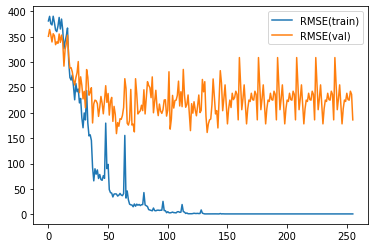

In [ ]:
#실행
de_results.loc[:,["RMSE(train)","RMSE(val)"]].plot()

In [ ]:
#실행
de_results_sorted = de_results.sort_values('RMSE(val)').reset_index()

시각화

In [ ]:
#실행
de_results_sorted.head(5)

index        R2  ...   MAE(val)                        hyper_params
0     57  0.817768  ...  35.761971  max_depth : 20, max_features : 50 
1    133  0.812550  ...  27.247890  max_depth : 45, max_features : 30 
2     72  0.809880  ...  30.310306  max_depth : 25, max_features : 45 
3    119  0.803955  ...  25.952975  max_depth : 40, max_features : 40 
4    102  0.796826  ...  26.090018  max_depth : 35, max_features : 35 

[5 rows x 7 columns]

**R2 value**을 기준으로 parameter 설정

In [ ]:
#실행
tree_reg = DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=50)
tree_reg.fit(train_x, train_y)
tree_reg_pred_test = tree_reg.predict(test_x)
mse_tree_reg_test = mean_squared_error(test_y, tree_reg_pred_test)
tree_reg_r2 = r2_score(test_y, tree_reg_pred_test)
mae_tree_reg_test=mean_absolute_error(test_y, tree_reg_pred_test)
print("R2:",tree_reg_r2)
print("RMSE:",mse_tree_reg_test**(0.5))
print("MAE:",mae_tree_reg_test )

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


R2: 0.6467791511327246
RMSE: 226.54096742458816
MAE: 38.094200644378894


### **(3) Random Forest**

##### **HyperParameter 하나씩 탐색하는 방법**

In [ ]:
#실행
rf_max_depth = [8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
rf_n_estimators = [50, 100, 150, 200, 250, 300]
rf_min_samples_split = [2, 5, 8, 11] 
rf_min_samples_leaf = [1,3,5,7,9,11] 
rf_max_features = [10,20,30,40,50,60]

max_depth만 조절<br>
나머지 HyperParameter는 고정

In [ ]:
#실행
def rmse_variable_max_dep(_param_list):
  result = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
  
  
  for i in _param_list : 
    max_dep = i
    n_est = 100
    min_split = 2
    min_leaf = 3
    max_f = 20
    rf = RandomForestRegressor(n_estimators= n_est, min_samples_split= min_split, max_depth = max_dep, 
                               min_samples_leaf = min_leaf, max_features = max_f, random_state=1234)
    rf.fit(train_x, train_y)
    rf_pred_train = rf.predict(train_x)
    rf_pred_val = rf.predict(val_x)
    rf_r2 = rf.score(val_x, val_y)
    mse_rf_train = mean_squared_error(train_y, rf_pred_train)
    rmse_rf_train = mse_rf_train**(0.5)
    mse_rf_val = mean_squared_error(val_y, rf_pred_val)
    rmse_rf_val = mse_rf_val**(0.5)
    mae_rf_train = mean_absolute_error(train_y, rf_pred_train)
    mae_rf_val = mean_absolute_error(val_y, rf_pred_val)
    hyper_params = 'max_dep : %s'%(max_dep)
    new_row = {'R2' : rf_r2, 'RMSE(train)': rmse_rf_train, 'RMSE(val)': rmse_rf_val, 
             'MAE(train)': mae_rf_train , 'MAE(val)' : mae_rf_val, 'hyper_params': hyper_params}
    result = result.append(new_row, ignore_index = True)
  return result

In [ ]:
max_dep_result = rmse_variable_max_dep(rf_max_depth)

In [ ]:
max_dep_result

R2  RMSE(train)   RMSE(val)  MAE(train)   MAE(val)  hyper_params
0  0.404293   300.360434  287.378683   68.105341  66.890592   max_dep : 8
1  0.542078   247.402780  251.961208   60.225020  61.091172  max_dep : 10
2  0.618719   212.581711  229.911419   53.657252  56.954265  max_dep : 12
3  0.655032   192.868028  218.689405   48.464568  53.674709  max_dep : 14
4  0.674394   182.285576  212.463584   44.498666  51.233278  max_dep : 16
5  0.692419   175.051632  206.499023   40.808267  48.992468  max_dep : 18
6  0.689981   176.719445  207.315768   38.641859  47.886324  max_dep : 20
7  0.695944   173.810659  205.312138   36.417460  46.669509  max_dep : 22
8  0.695275   172.743451  205.538088   35.173513  45.899523  max_dep : 24
9  0.695312   173.215947  205.525459   34.304265  45.439901  max_dep : 26

([<matplotlib.axis.XTick at 0x7f007bb52290>,
 <a list of 10 Text major ticklabel objects>)

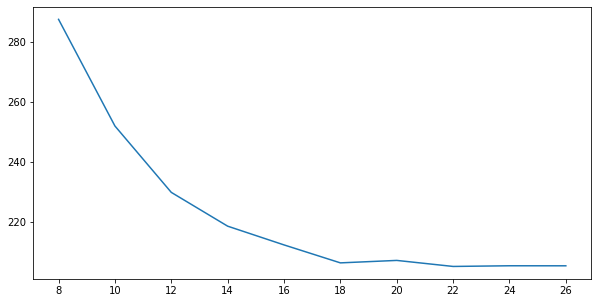

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(rf_max_depth, max_dep_result.loc[:, 'RMSE(val)'])
plt.xticks(rf_max_depth)

max_depth가 22이상 인경우 RMSE(val)의 변화가 없는 것을 확인할 수 있음
<br> max_depth = 22 고정

rmse_variable_n_estimators : n_estimators 변수만 조절, 나머지 HyperParameter는 고정(max_depth=22)

In [ ]:
# 실행
def rmse_variable_n_estimators(_param_list):
  result = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
  
  for i in _param_list : 
    max_dep = 22
    n_est = i
    min_split = 2
    min_leaf = 3
    max_f = 20
    rf = RandomForestRegressor(n_estimators= n_est, min_samples_split= min_split, max_depth = max_dep, 
                               min_samples_leaf = min_leaf, max_features = max_f, random_state=1234)
    rf.fit(train_x, train_y)
    rf_pred_train = rf.predict(train_x)
    rf_pred_val = rf.predict(val_x)
    rf_r2 = rf.score(val_x, val_y)
    mse_rf_train = mean_squared_error(train_y, rf_pred_train)
    rmse_rf_train = mse_rf_train**(0.5)
    mse_rf_val = mean_squared_error(val_y, rf_pred_val)
    rmse_rf_val = mse_rf_val**(0.5)
    mae_rf_train = mean_absolute_error(train_y, rf_pred_train)
    mae_rf_val = mean_absolute_error(val_y, rf_pred_val)
    hyper_params = 'n_estimators : %s'%(n_est)
    new_row = {'R2' : rf_r2, 'RMSE(train)': rmse_rf_train, 'RMSE(val)': rmse_rf_val, 
             'MAE(train)': mae_rf_train , 'MAE(val)' : mae_rf_val, 'hyper_params': hyper_params}
    result = result.append(new_row, ignore_index = True)  

  return result

In [ ]:
#실행
n_estimators_result = rmse_variable_n_estimators(rf_n_estimators)

In [ ]:
#실행
n_estimators_result

R2  RMSE(train)   RMSE(val)  MAE(train)   MAE(val)        hyper_params
0  0.694855   175.082589  205.679688   36.832025  47.227640   n_estimators : 50
1  0.695944   173.810659  205.312138   36.417460  46.669509  n_estimators : 100
2  0.693635   173.179112  206.090342   36.198522  46.416787  n_estimators : 150
3  0.696111   172.553362  205.255762   36.135820  46.274348  n_estimators : 200
4  0.696728   172.648444  205.047245   36.100646  46.212778  n_estimators : 250
5  0.697411   172.460975  204.816488   36.041941  46.148611  n_estimators : 300

([<matplotlib.axis.XTick at 0x7f007bbfee90>,
 <a list of 6 Text major ticklabel objects>)

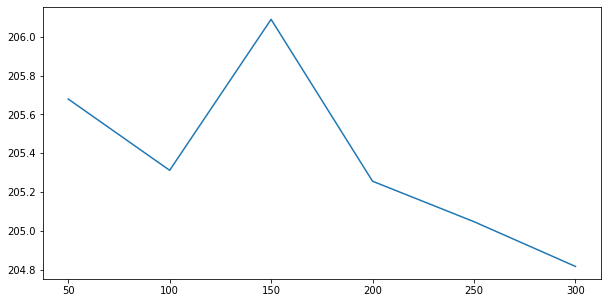

In [ ]:
#실행
plt.figure(figsize=(10,5))
plt.plot(rf_n_estimators, n_estimators_result.loc[:, 'RMSE(val)'])
plt.xticks(rf_n_estimators)

n_estimators는 100으로 고정하는 것이 좋아보임(**150 이상인 경우 Overfitting 우려**)

rmse_variable_min_split : min_samples_split 변수를 조절, 나머지 HyperParameter는 고정(max_depth = 22, n_estimators = 100)

In [ ]:
#실행
def rmse_variable_min_split(_param_list):
  result = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
  
  for i in _param_list : 
    max_dep = 22
    n_est = 100
    min_split = i
    min_leaf = 3
    max_f = 20
    rf = RandomForestRegressor(n_estimators= n_est, min_samples_split= min_split, max_depth = max_dep, 
                               min_samples_leaf = min_leaf, max_features = max_f, random_state=1234)
    rf.fit(train_x, train_y)
    rf_pred_train = rf.predict(train_x)
    rf_pred_val = rf.predict(val_x)
    rf_r2 = rf.score(val_x, val_y)
    mse_rf_train = mean_squared_error(train_y, rf_pred_train)
    rmse_rf_train = mse_rf_train**(0.5)
    mse_rf_val = mean_squared_error(val_y, rf_pred_val)
    rmse_rf_val = mse_rf_val**(0.5)
    mae_rf_train = mean_absolute_error(train_y, rf_pred_train)
    mae_rf_val = mean_absolute_error(val_y, rf_pred_val)
    hyper_params = 'min_samples_split : %s'%(min_split)
    new_row = {'R2' : rf_r2, 'RMSE(train)': rmse_rf_train, 'RMSE(val)': rmse_rf_val, 
             'MAE(train)': mae_rf_train , 'MAE(val)' : mae_rf_val, 'hyper_params': hyper_params}
    result = result.append(new_row, ignore_index = True)  

  return result

In [ ]:
#실행
rf_min_samples_result = rmse_variable_min_split(rf_min_samples_split)

In [ ]:
#실행
rf_min_samples_result

R2  RMSE(train)  ...   MAE(val)            hyper_params
0  0.695944   173.810659  ...  46.669509   min_samples_split : 2
1  0.695944   173.810659  ...  46.669509   min_samples_split : 5
2  0.682487   181.735242  ...  47.548939   min_samples_split : 8
3  0.662832   192.838682  ...  48.957340  min_samples_split : 11

[4 rows x 6 columns]

([<matplotlib.axis.XTick at 0x7f007be3d350>,
 <a list of 4 Text major ticklabel objects>)

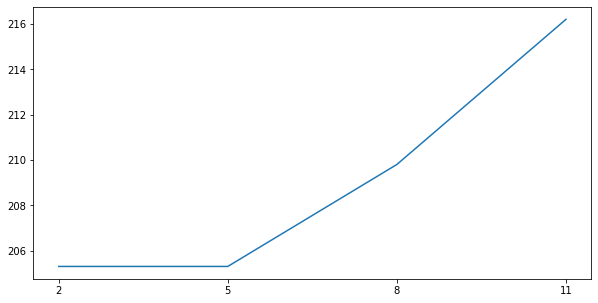

In [ ]:
#실행
plt.figure(figsize=(10,5))
plt.plot(rf_min_samples_split, rf_min_samples_result.loc[:, 'RMSE(val)'])
plt.xticks(rf_min_samples_split)

min_sample_split 값은 2 또는 5에서 최적화하는 걸로

rmse_variable_min_leaf : min_samples_leaf 변수를 조절, 나머지 HyperParameter는 고정(max_depth = 22, n_estimators = 100, min_sample_split = 2 or 5)

In [ ]:
#실행
def rmse_variable_min_leaf(_param_list):
  result = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
  
  for i in _param_list : 
    max_dep = 22
    n_est = 100
    min_split = 2
    min_leaf = i
    max_f = 20
    rf = RandomForestRegressor(n_estimators= n_est, min_samples_split= min_split, max_depth = max_dep, 
                               min_samples_leaf = min_leaf, max_features = max_f, random_state=1234)
    rf.fit(train_x, train_y)
    rf_pred_train = rf.predict(train_x)
    rf_pred_val = rf.predict(val_x)
    rf_r2 = rf.score(val_x, val_y)
    mse_rf_train = mean_squared_error(train_y, rf_pred_train)
    rmse_rf_train = mse_rf_train**(0.5)
    mse_rf_val = mean_squared_error(val_y, rf_pred_val)
    rmse_rf_val = mse_rf_val**(0.5)
    mae_rf_train = mean_absolute_error(train_y, rf_pred_train)
    mae_rf_val = mean_absolute_error(val_y, rf_pred_val)
    hyper_params = 'min_samples_leaf : %s'%(min_leaf)
    new_row = {'R2' : rf_r2, 'RMSE(train)': rmse_rf_train, 'RMSE(val)': rmse_rf_val, 
             'MAE(train)': mae_rf_train , 'MAE(val)' : mae_rf_val, 'hyper_params': hyper_params}
    result = result.append(new_row, ignore_index = True)  

  return result

In [ ]:
#실행
rf_min_leaf_result = rmse_variable_min_leaf(rf_min_samples_leaf)

In [ ]:
#실행
rf_min_leaf_result

R2  RMSE(train)  ...   MAE(val)           hyper_params
0  0.852076    69.633045  ...  36.385629   min_samples_leaf : 1
1  0.695944   173.810659  ...  46.669509   min_samples_leaf : 3
2  0.619405   212.591367  ...  51.017898   min_samples_leaf : 5
3  0.572969   235.345819  ...  53.413407   min_samples_leaf : 7
4  0.532577   252.407129  ...  55.496891   min_samples_leaf : 9
5  0.502564   263.573823  ...  56.666541  min_samples_leaf : 11

[6 rows x 6 columns]

([<matplotlib.axis.XTick at 0x7f007c278250>,
 <a list of 6 Text major ticklabel objects>)

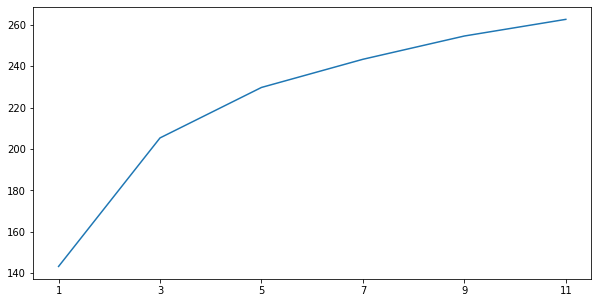

In [ ]:
#실행
plt.figure(figsize=(10,5))
plt.plot(rf_min_samples_leaf, rf_min_leaf_result.loc[:, 'RMSE(val)'])
plt.xticks(rf_min_samples_leaf)

min_samples_leaf는 1로 고정해놓기

rmse_variable_max_f : max_features 변수를 조절, 나머지 HyperParameter는 고정(max_depth = 22, n_estimators = 100, min_sample_split = 2 or 5, min_samples_leaf = 1)

In [ ]:
#실행
def rmse_variable_max_f(_param_list):
  result = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
  
  for i in _param_list : 
    max_dep = 22
    n_est = 100
    min_split = 2
    min_leaf = 1
    max_f = i
    rf = RandomForestRegressor(n_estimators= n_est, min_samples_split= min_split, max_depth = max_dep, 
                               min_samples_leaf = min_leaf, max_features = max_f, random_state=1234)
    rf.fit(train_x, train_y)
    rf_pred_train = rf.predict(train_x)
    rf_pred_val = rf.predict(val_x)
    rf_r2 = rf.score(val_x, val_y)
    mse_rf_train = mean_squared_error(train_y, rf_pred_train)
    rmse_rf_train = mse_rf_train**(0.5)
    mse_rf_val = mean_squared_error(val_y, rf_pred_val)
    rmse_rf_val = mse_rf_val**(0.5)
    mae_rf_train = mean_absolute_error(train_y, rf_pred_train)
    mae_rf_val = mean_absolute_error(val_y, rf_pred_val)
    hyper_params = 'max_features : %s'%(max_f)
    new_row = {'R2' : rf_r2, 'RMSE(train)': rmse_rf_train, 'RMSE(val)': rmse_rf_val, 
             'MAE(train)': mae_rf_train , 'MAE(val)' : mae_rf_val, 'hyper_params': hyper_params}
    result = result.append(new_row, ignore_index = True)  

  return result

In [ ]:
#실행
rf_max_features_results = rmse_variable_max_f(rf_max_features)

In [ ]:
#실행
rf_max_features_results

R2  RMSE(train)   RMSE(val)  MAE(train)   MAE(val)       hyper_params
0  0.817758    80.066705  158.950811   25.255178  40.191741  max_features : 10
1  0.852076    69.633045  143.204750   21.216691  36.385629  max_features : 20
2  0.849925    67.557024  144.242140   20.338472  35.973901  max_features : 30
3  0.855922    66.986894  141.330724   20.133458  35.718408  max_features : 40
4  0.857267    66.635465  140.669754   20.209341  35.740890  max_features : 50
5  0.850818    66.753549  143.812554   19.993565  35.905343  max_features : 60

max_feature = 50으로 고정

([<matplotlib.axis.XTick at 0x7f007bd3e510>,
 <a list of 6 Text major ticklabel objects>)

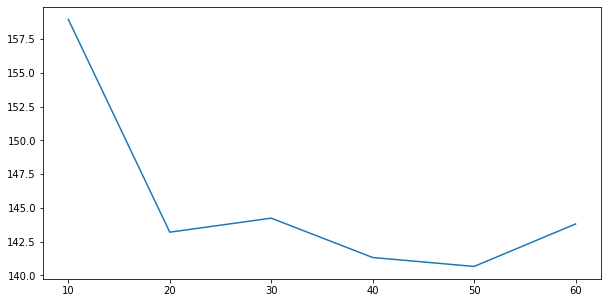

In [ ]:
#실행
plt.figure(figsize=(10,5))
plt.plot(rf_max_features, rf_max_features_results.loc[:, 'RMSE(val)'])
plt.xticks(rf_max_features)

최종 HyperParameter 조합
<br>max_depth = 22, n_estimators = 100, min_samples_split = 2, min_samples_leaf = 1, max_features = 50

In [ ]:
#실행
rf_reg = RandomForestRegressor(max_depth = 22, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=50, random_state=1234)
rf_reg.fit(train_x, train_y)
rf_reg_pred_test = rf_reg.predict(test_x)
mse_rf_reg_test = mean_squared_error(test_y, rf_reg_pred_test)
rf_reg_r2 = r2_score(test_y, rf_reg_pred_test)
mae_rf_reg_test=mean_absolute_error(test_y, rf_reg_pred_test)
print("R2:",rf_reg_r2)
print("RMSE:",mse_rf_reg_test**(0.5))
print("MAE:",mae_rf_reg_test )

R2: 0.8387492867272286
RMSE: 153.06447563227462
MAE: 36.156201087618925


사용자 정의 함수를 토대로 구한 adj_r2_score

In [ ]:
#실행
rf_adj_r2_score = adj_r2_score(test_y, rf_reg_pred_test, test_x)
rf_adj_r2_score

0.8377647596569576

##### **GridSearch**

**max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features** Parameter 조작

In [ ]:
#실행
rf_params = {'max_depth': [16, 18, 20, 22, 24], 'n_estimators': [50, 100, 150], 'min_samples_split' : [2, 5], 'min_samples_leaf' : [1,3], 'max_features' : [10,20,30]}
rf_p = list(product(*rf_params.values()))
rf_p

[(16, 50, 2, 1, 10),
 (16, 50, 2, 1, 20),
 (16, 50, 2, 1, 30),
 (16, 50, 2, 3, 10),
 (16, 50, 2, 3, 20),
 (16, 50, 2, 3, 30),
 (16, 50, 5, 1, 10),
 (16, 50, 5, 1, 20),
 (16, 50, 5, 1, 30),
 (16, 50, 5, 3, 10),
 (16, 50, 5, 3, 20),
 (16, 50, 5, 3, 30),
 (16, 100, 2, 1, 10),
 (16, 100, 2, 1, 20),
 (16, 100, 2, 1, 30),
 (16, 100, 2, 3, 10),
 (16, 100, 2, 3, 20),
 (16, 100, 2, 3, 30),
 (16, 100, 5, 1, 10),
 (16, 100, 5, 1, 20),
 (16, 100, 5, 1, 30),
 (16, 100, 5, 3, 10),
 (16, 100, 5, 3, 20),
 (16, 100, 5, 3, 30),
 (16, 150, 2, 1, 10),
 (16, 150, 2, 1, 20),
 (16, 150, 2, 1, 30),
 (16, 150, 2, 3, 10),
 (16, 150, 2, 3, 20),
 (16, 150, 2, 3, 30),
 (16, 150, 5, 1, 10),
 (16, 150, 5, 1, 20),
 (16, 150, 5, 1, 30),
 (16, 150, 5, 3, 10),
 (16, 150, 5, 3, 20),
 (16, 150, 5, 3, 30),
 (18, 50, 2, 1, 10),
 (18, 50, 2, 1, 20),
 (18, 50, 2, 1, 30),
 (18, 50, 2, 3, 10),
 (18, 50, 2, 3, 20),
 (18, 50, 2, 3, 30),
 (18, 50, 5, 1, 10),
 (18, 50, 5, 1, 20),
 (18, 50, 5, 1, 30),
 (18, 50, 5, 3, 10),
 (18, 50, 

rf_results Dataframe에 조작한 parameter 별 성능 값들을 저장

In [ ]:
#실행
rf_results = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
num=1
for i in rf_p : 
    try :
        max_dep = int(i[0])
    except :
        max_dep = i[0]
    n_est = int(i[1])
    min_split = int(i[2])
    min_leaf = int(i[3])
    max_f = int(i[4])
    rf = RandomForestRegressor(n_estimators= n_est, min_samples_split= min_split, max_depth = max_dep, 
                               min_samples_leaf = min_leaf, max_features = max_f, random_state=1234)
    rf.fit(train_x, train_y)
    rf_pred_train = rf.predict(train_x)
    rf_pred_val = rf.predict(val_x)
    rf_r2 = rf.score(val_x, val_y)
    mse_rf_train = mean_squared_error(train_y, rf_pred_train)
    rmse_rf_train = mse_rf_train**(0.5)
    mse_rf_val = mean_squared_error(val_y, rf_pred_val)
    rmse_rf_val = mse_rf_val**(0.5)
    mae_rf_train = mean_absolute_error(train_y, rf_pred_train)
    mae_rf_val = mean_absolute_error(val_y, rf_pred_val)
    hyper_params = 'n_est : %s,  min_split : %s'%(n_est, min_split)
    new_row = {'R2' : rf_r2, 'RMSE(train)': rmse_rf_train, 'RMSE(val)': rmse_rf_val, 
             'MAE(train)': mae_rf_train , 'MAE(val)' : mae_rf_val, 'hyper_params' : hyper_params}
    rf_results = rf_results.append(new_row, ignore_index = True)
    print(num)
    num+=1
rf_results

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


**시각화** 

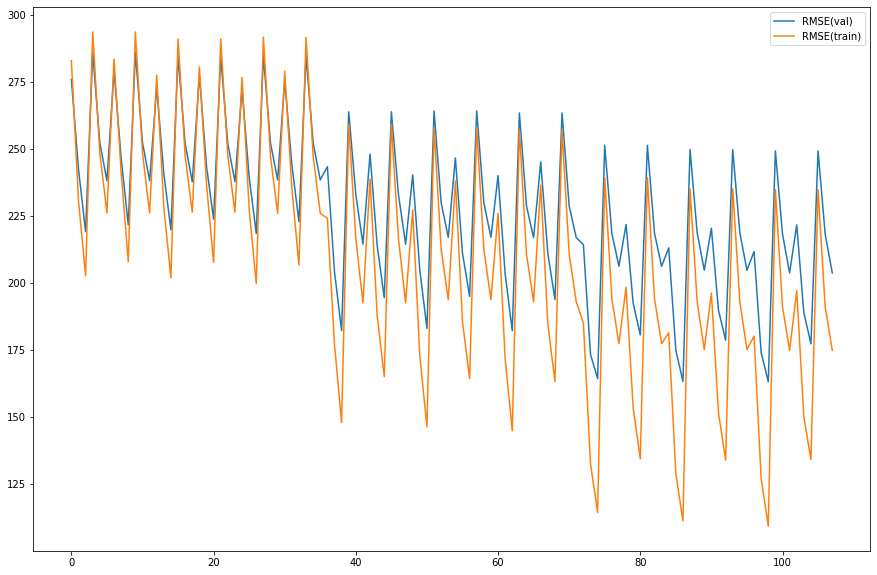

In [ ]:
#실행
rf_results.loc[:,['RMSE(val)', 'RMSE(train)']].plot(figsize=(15,10))

**RMSE(val)**을 기준으로 인덱싱

In [ ]:
#실행
rf_results_sorted = rf_results.sort_values('RMSE(val)').reset_index()

In [ ]:
#실행
rf_results_sorted.head(5)

index        R2  ...   MAE(val)                 hyper_params
0     98  0.808196  ...  47.254266  n_est : 150,  min_split : 2
1     86  0.807803  ...  47.275263  n_est : 100,  min_split : 2
2     74  0.805373  ...  47.832199   n_est : 50,  min_split : 2
3     73  0.783294  ...  49.539320   n_est : 50,  min_split : 2
4     97  0.781794  ...  48.934604  n_est : 150,  min_split : 2

[5 rows x 7 columns]

맨 위에 있는 parameter 조합이 RMSE(validation) value가 제일 최적화 되어 있다. 따라서 해당 Parameter 조합을 사용해서 test를 해볼 예정

해당 Parameter에 대한 조합을 찾기 위한 작업

In [ ]:
#실행
rf_p[98]

(14, 150, 2, 1, 30)

RMSE(val) Value를 기준으로 모델링<br>
'max_depth', 'n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_features'
(max_depth = 14, n_estimators = 150, min_samples_split = 2, min_samples_leaf = 1, max_features = 30)

In [ ]:
#실행
rf_reg = RandomForestRegressor(max_depth = 14, n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=30, random_state=1234)
rf_reg.fit(train_x, train_y)
rf_reg_pred_test = rf_reg.predict(test_x)
mse_rf_reg_test = mean_squared_error(test_y, rf_reg_pred_test)
rf_reg_r2 = r2_score(test_y, rf_reg_pred_test)
mae_rf_reg_test=mean_absolute_error(test_y, rf_reg_pred_test)
print("R2:",rf_reg_r2)
print("RMSE:",mse_rf_reg_test**(0.5))
print("MAE:",mae_rf_reg_test )

R2: 0.7910811494950143
RMSE: 174.22577284028512
MAE: 48.06888379310803


In [ ]:
#실행
rf_reg_adj_r2_score = adj_r2_score(test_y, rf_reg_pred_test, test_x)
rf_reg_adj_r2_score

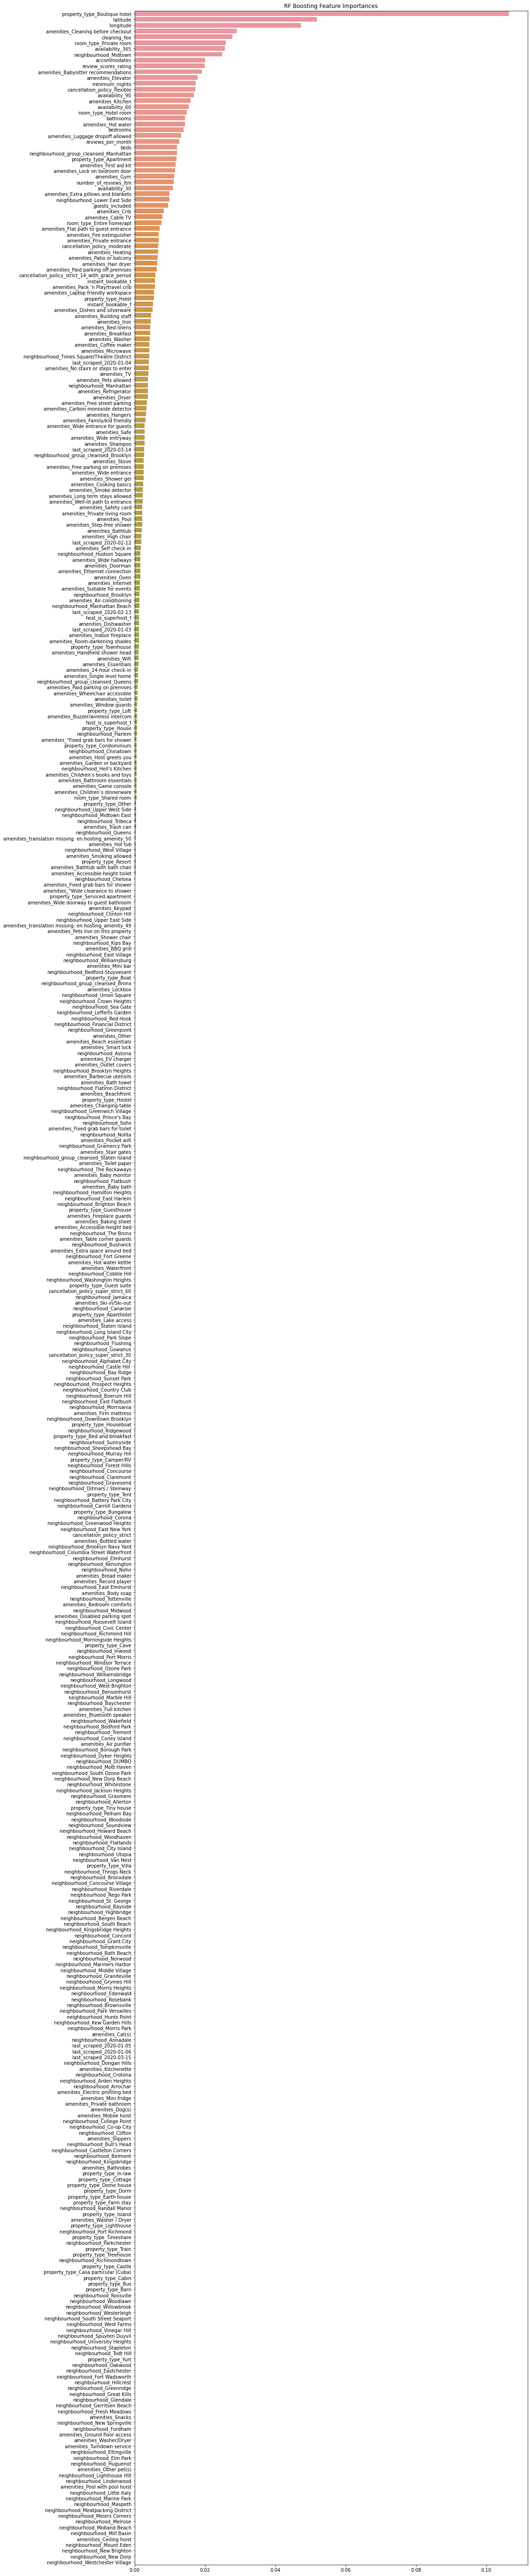

In [ ]:
rf_features = rf.feature_importances_
rf_features_imp = pd.Series(rf_features, index=train_x.columns)
rf_features_imp = rf_features_imp.sort_values(ascending=False)

plt.figure(figsize=(15,100))
plt.title('RF Boosting Feature Importances')
sns.barplot(x=rf_features_imp, y = rf_features_imp.index)
plt.show()

### **(4) Ada Boost**
성능이 상대적으로 안 좋아서 GridSearch만 진행

In [ ]:
#실행
ada_params = {'n_estimators': [25, 50, 100],'learning_rate' : [0.05,0.1,0.3], 'loss' : ['linear', 'square', 'exponential']}
ada_p = list(product(*ada_params.values()))
ada_p

[(25, 0.05, 'linear'),
 (25, 0.05, 'square'),
 (25, 0.05, 'exponential'),
 (25, 0.1, 'linear'),
 (25, 0.1, 'square'),
 (25, 0.1, 'exponential'),
 (25, 0.3, 'linear'),
 (25, 0.3, 'square'),
 (25, 0.3, 'exponential'),
 (50, 0.05, 'linear'),
 (50, 0.05, 'square'),
 (50, 0.05, 'exponential'),
 (50, 0.1, 'linear'),
 (50, 0.1, 'square'),
 (50, 0.1, 'exponential'),
 (50, 0.3, 'linear'),
 (50, 0.3, 'square'),
 (50, 0.3, 'exponential'),
 (100, 0.05, 'linear'),
 (100, 0.05, 'square'),
 (100, 0.05, 'exponential'),
 (100, 0.1, 'linear'),
 (100, 0.1, 'square'),
 (100, 0.1, 'exponential'),
 (100, 0.3, 'linear'),
 (100, 0.3, 'square'),
 (100, 0.3, 'exponential')]

In [ ]:
#실행
ada_results = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
num=1
for i in ada_p : 
  n_est = int(i[0])
  lr = float(i[1])
  los = i[2]
  ada = AdaBoostRegressor(learning_rate= lr, loss= los , n_estimators = n_est, random_state=1234)
  ada.fit(train_x, train_y)
  ada_pred_train = ada.predict(train_x)
  ada_pred_val = ada.predict(val_x)
  ada_r2 = ada.score(val_x, val_y)
  mse_ada_train = mean_squared_error(train_y, ada_pred_train)
  rmse_ada_train = mse_ada_train**(0.5)
  mse_ada_val = mean_squared_error(val_y, ada_pred_val)
  rmse_ada_val = mse_ada_val**(0.5)
  mae_ada_train = mean_absolute_error(train_y, ada_pred_train)
  mae_ada_val = mean_absolute_error(val_y, ada_pred_val)
  hyper_params = 'n_est : %s,  lr : %s, loss : %s'%(n_est, lr, los)
  new_row = {'R2' : ada_r2, 'RMSE(train)': rmse_ada_train, 'RMSE(val)': rmse_ada_val, 
             'MAE(train)': mae_ada_train , 'MAE(val)' : mae_ada_val, 'hyper_params' : hyper_params}
  ada_results = ada_results.append(new_row, ignore_index = True)
  print(num)
  num+=1
ada_results

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


R2  ...                                 hyper_params
0   0.068478  ...        n_est : 25,  lr : 0.05, loss : linear
1   0.009567  ...        n_est : 25,  lr : 0.05, loss : square
2   0.121738  ...   n_est : 25,  lr : 0.05, loss : exponential
3   0.087221  ...         n_est : 25,  lr : 0.1, loss : linear
4  -0.080600  ...         n_est : 25,  lr : 0.1, loss : square
5   0.120881  ...    n_est : 25,  lr : 0.1, loss : exponential
6  -0.081254  ...         n_est : 25,  lr : 0.3, loss : linear
7  -0.765382  ...         n_est : 25,  lr : 0.3, loss : square
8  -0.093428  ...    n_est : 25,  lr : 0.3, loss : exponential
9   0.063692  ...        n_est : 50,  lr : 0.05, loss : linear
10 -0.073673  ...        n_est : 50,  lr : 0.05, loss : square
11  0.109869  ...   n_est : 50,  lr : 0.05, loss : exponential
12 -0.041525  ...         n_est : 50,  lr : 0.1, loss : linear
13 -0.533995  ...         n_est : 50,  lr : 0.1, loss : square
14  0.081101  ...    n_est : 50,  lr : 0.1, loss : exponential
15 -0.081254  ...         n_est : 50,  lr : 0.3, loss : linear
16 -1.272382  ...         n_est : 50,  lr : 0.3, loss : square
17 -0.457120  ...    n_est : 50,  lr : 0.3, loss : exponential
18 -0.053030  ...       n_est : 100,  lr : 0.05, loss : linear
19 -0.500601  ...       n_est : 100,  lr : 0.05, loss : square
20  0.062604  ...  n_est : 100,  lr : 0.05, loss : exponential
21 -0.140300  ...        n_est : 100,  lr : 0.1, loss : linear
22 -2.404226  ...        n_est : 100,  lr : 0.1, loss : square
23 -0.260607  ...   n_est : 100,  lr : 0.1, loss : exponential
24 -0.081254  ...        n_est : 100,  lr : 0.3, loss : linear
25 -1.272382  ...        n_est : 100,  lr : 0.3, loss : square
26 -1.640303  ...   n_est : 100,  lr : 0.3, loss : exponential

[27 rows x 6 columns]

In [ ]:
#실행
ada_results.loc[:,['RMSE(train)', 'RMSE(val)']].plot(figsize=(15,10))

In [ ]:
#실행
ada_results = ada_results.sort_values('RMSE(val)').reset_index()

In [ ]:
#실행
ada_results.head(5)

In [ ]:
#실행
ada = AdaBoostRegressor(learning_rate =  0.05, loss =  'exponential', n_estimators = 25, random_state=1234)

In [ ]:
#실행
ada.fit(train_x, train_y)

# R^2
ada_pred = ada.predict(test_x)                                     
ada_r2 = ada.score(test_x, test_y)
ada_r2

0.09111329828028625

In [ ]:
#실행
#RMSE
mse_ada_test = mean_squared_error(test_y, ada_pred)
rmse_ada_test = mse_ada_test**(0.5)
rmse_ada_test

363.3945924340085

In [ ]:
#실행
#MAE
mae_ada_test = mean_absolute_error(test_y, ada_pred)
mae_ada_test

101.32875131462607

In [ ]:
#실행
ada_adj_r2_score = adj_r2_score(test_y, ada_pred, test_x)
ada_adj_r2_score

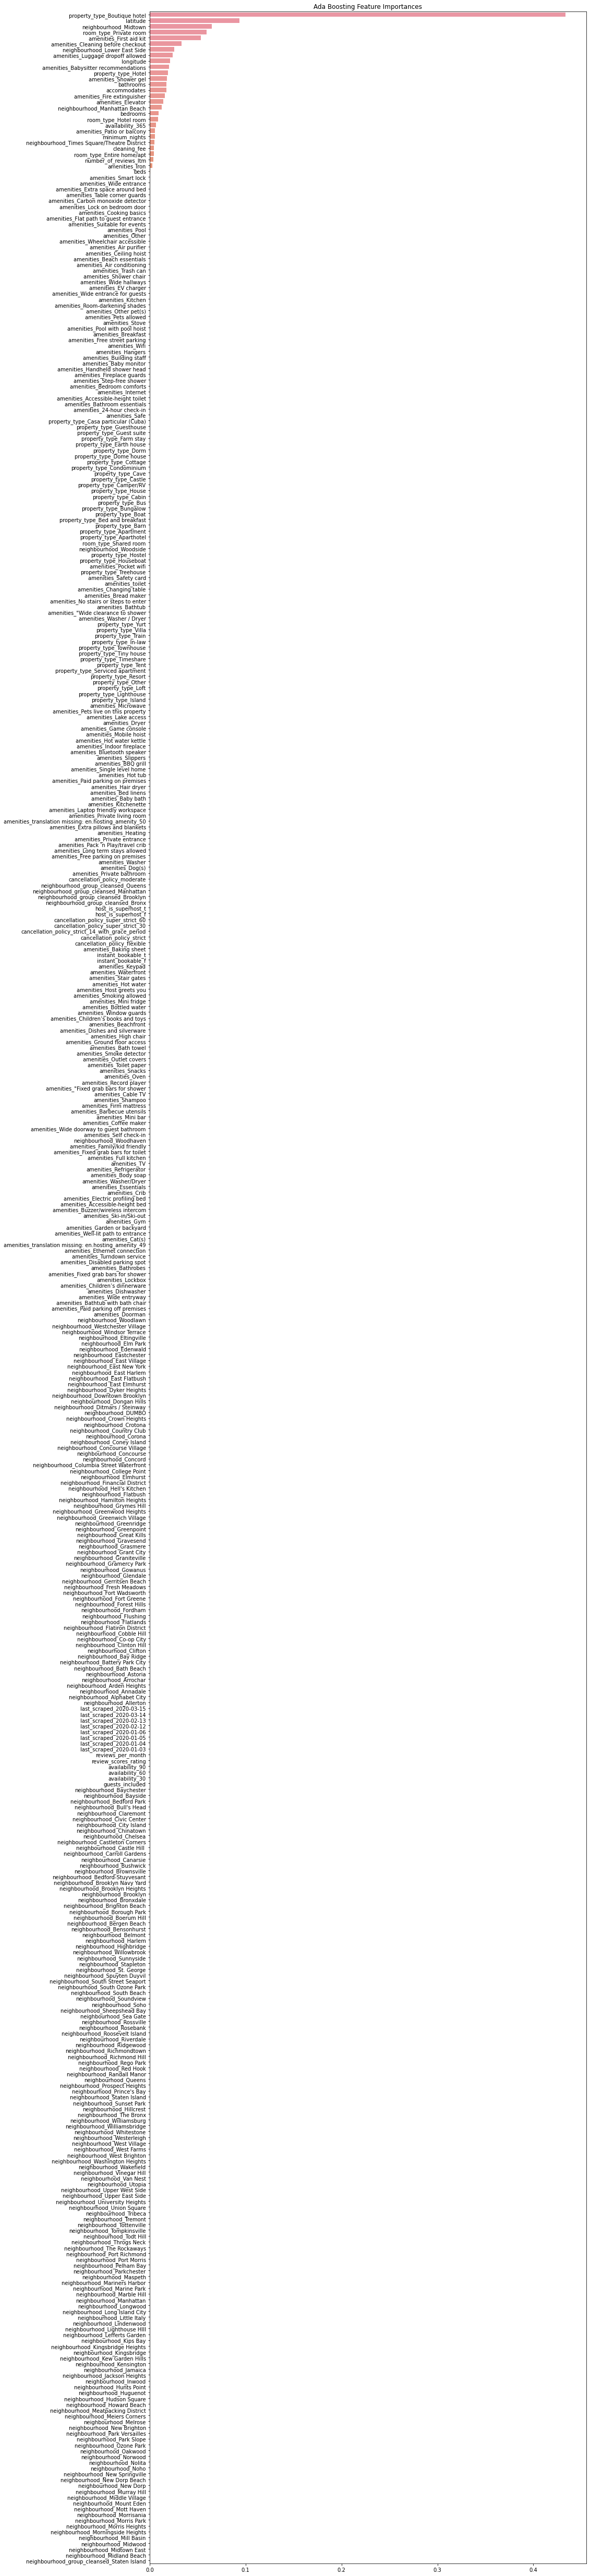

In [ ]:
ada_features = ada.feature_importances_
ada_feature_imp = pd.Series(ada_features, index=train_x.columns)
ada_feature_imp = ada_feature_imp.sort_values(ascending=False)

plt.figure(figsize=(15,90))
plt.title('Ada Boosting Feature Importances')
sns.barplot(x=ada_feature_imp, y = ada_feature_imp.index)
plt.show()

###**(5) Gradient Boosting**

##### **HyperParameter 한 개씩 최적화하는 작업**
learning_rate, n_estimators, max_depth

In [ ]:
#실행
gb_learning_rate_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
gb_n_estimators_list = [600, 650, 700]
gb_max_depth_list = [3,5,7,9,11,13,15]

learning rate에 변화, 나머지 변수는 고정

In [ ]:
#실행
def rmse_variable_lr_gb(_param_list):
  result = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])

  for i in _param_list:
    lr = i
    n_est = 100
    max_d = 5
    gb = GradientBoostingRegressor(learning_rate= lr, max_depth= max_d , n_estimators = n_est, random_state = 1234)
    gb.fit(train_x, train_y)
    gb_pred_train = gb.predict(train_x)
    gb_pred_val = gb.predict(val_x)
    gb_r2 = gb.score(val_x, val_y)
    mse_gb_train = mean_squared_error(train_y, gb_pred_train)
    rmse_gb_train = mse_gb_train**(0.5)
    mse_gb_val = mean_squared_error(val_y, gb_pred_val)
    rmse_gb_val = mse_gb_val**(0.5)
    mae_gb_train = mean_absolute_error(train_y, gb_pred_train)
    mae_gb_val = mean_absolute_error(val_y, gb_pred_val)
    hyper_params = 'lr : %s'%(lr)
    new_row = {'R2' : gb_r2, 'RMSE(train)': rmse_gb_train, 'RMSE(val)': rmse_gb_val, 
             'MAE(train)': mae_gb_train , 'MAE(val)' : mae_gb_val, 'hyper_params' : hyper_params}
    result = result.append(new_row, ignore_index = True)
  return result

In [ ]:
#실행
gb_lr_results = rmse_variable_lr_gb(gb_learning_rate_list)
gb_lr_results

R2  RMSE(train)   RMSE(val)  MAE(train)   MAE(val) hyper_params
0  0.359578   313.264457  297.968964   77.909443  76.265214    lr : 0.01
1  0.565339   251.211672  245.478512   61.171438  61.398629    lr : 0.05
2  0.625969   217.448054  227.715224   57.571186  59.629569     lr : 0.1
3  0.696002   175.894914  205.292750   54.603049  58.346653     lr : 0.2
4  0.718083   146.600306  197.696490   52.149312  58.437355     lr : 0.3
5  0.674016   119.887500  212.586760   50.471688  60.428656     lr : 0.5

([<matplotlib.axis.XTick at 0x7fdf82d82750>,
 <a list of 6 Text major ticklabel objects>)

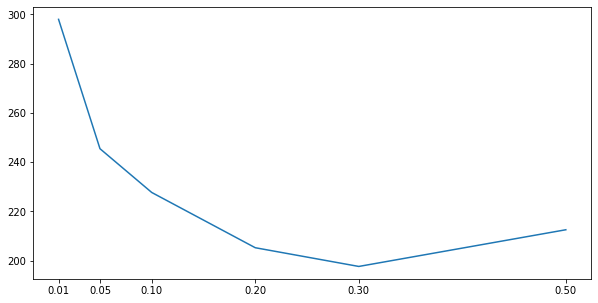

In [ ]:
#실행
plt.figure(figsize=(10,5))
plt.plot(gb_learning_rate_list, gb_lr_results.loc[:, 'RMSE(val)'])
plt.xticks(gb_learning_rate_list)

gradient boosting의 learning rate = 0.3으로 고정

learning rate=0.3, max_d = 5로 고정하고 n_est 변수만 변화를 주기

In [ ]:
#실행
def rmse_variable_n_est_gb(_param_list):
  result = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])

  for i in _param_list:
    lr = 0.3
    n_est = i
    max_d = 5
    gb = GradientBoostingRegressor(learning_rate= lr, max_depth= max_d , n_estimators = n_est, random_state = 1234)
    gb.fit(train_x, train_y)
    gb_pred_train = gb.predict(train_x)
    gb_pred_val = gb.predict(val_x)
    gb_r2 = gb.score(val_x, val_y)
    mse_gb_train = mean_squared_error(train_y, gb_pred_train)
    rmse_gb_train = mse_gb_train**(0.5)
    mse_gb_val = mean_squared_error(val_y, gb_pred_val)
    rmse_gb_val = mse_gb_val**(0.5)
    mae_gb_train = mean_absolute_error(train_y, gb_pred_train)
    mae_gb_val = mean_absolute_error(val_y, gb_pred_val)
    hyper_params = 'n_est : %s'%(n_est)
    new_row = {'R2' : gb_r2, 'RMSE(train)': rmse_gb_train, 'RMSE(val)': rmse_gb_val, 
             'MAE(train)': mae_gb_train , 'MAE(val)' : mae_gb_val, 'hyper_params' : hyper_params}
    result = result.append(new_row, ignore_index = True)
  return result

In [ ]:
#실행
gb_n_est_results = rmse_variable_n_est_gb(gb_n_estimators_list)
gb_n_est_results

R2  RMSE(train)   RMSE(val)  MAE(train)   MAE(val) hyper_params
0  0.813593    57.086442  160.756621   33.741070  49.679506  n_est : 600
1  0.815836    54.280730  159.786584   32.725765  49.120120  n_est : 650
2  0.817296    52.083305  159.152017   31.749775  48.605999  n_est : 700

([<matplotlib.axis.XTick at 0x7fdf8568a6d0>,
 <a list of 3 Text major ticklabel objects>)

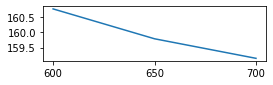

In [ ]:
#실행
plt.figure(figsize=(4,1))
plt.plot(gb_n_estimators_list, gb_n_est_results.loc[:, 'RMSE(val)'])
plt.xticks(gb_n_estimators_list)

차이 줄어 드는 것이 현저히 낮아지는 것이 보임(**서로 간 1, 0.6밖에 차이 안남**)<br> n_estimators는 750 또는 800 선에서 선정하면 좋을 것 같음

n_estimators = 750 or 800, learning_rate = 0.3으로 고정 후 max_d 변수만 변화를 주기

In [ ]:
#실행
def rmse_variable_max_d_gb(_param_list):
  result = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])

  for i in _param_list:
    lr = 0.3
    n_est = 750
    max_d = i
    gb = GradientBoostingRegressor(learning_rate= lr, max_depth= max_d , n_estimators = n_est, random_state = 1234)
    gb.fit(train_x, train_y)
    gb_pred_train = gb.predict(train_x)
    gb_pred_val = gb.predict(val_x)
    gb_r2 = gb.score(val_x, val_y)
    mse_gb_train = mean_squared_error(train_y, gb_pred_train)
    rmse_gb_train = mse_gb_train**(0.5)
    mse_gb_val = mean_squared_error(val_y, gb_pred_val)
    rmse_gb_val = mse_gb_val**(0.5)
    mae_gb_train = mean_absolute_error(train_y, gb_pred_train)
    mae_gb_val = mean_absolute_error(val_y, gb_pred_val)
    hyper_params = 'max_d : %s'%(max_d)
    new_row = {'R2' : gb_r2, 'RMSE(train)': rmse_gb_train, 'RMSE(val)': rmse_gb_val, 
             'MAE(train)': mae_gb_train , 'MAE(val)' : mae_gb_val, 'hyper_params' : hyper_params}
    result = result.append(new_row, ignore_index = True)
  return result

In [ ]:
#실행
gb_max_d_results = rmse_variable_max_d_gb(gb_max_depth_list)
gb_max_d_results

R2  RMSE(train)   RMSE(val)  MAE(train)   MAE(val) hyper_params
0  0.681636   162.822479  210.087254   61.426956  67.971009    max_d : 3
1  0.818274    50.061477  158.725330   30.877174  48.226035    max_d : 5
2  0.835295    17.408382  151.109284   12.053569  34.647301    max_d : 7
3  0.844314     4.090137  146.914054    2.805369  27.889356    max_d : 9
4  0.794802     0.803819  168.664896    0.293645  25.310117   max_d : 11
5  0.789492     0.687678  170.833320    0.016275  24.215489   max_d : 13
6  0.774177     0.687568  176.938510    0.008377  24.426780   max_d : 15

([<matplotlib.axis.XTick at 0x7fdf75f0cc90>,
 <a list of 7 Text major ticklabel objects>)

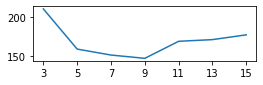

In [ ]:
#실행
plt.figure(figsize=(4,1))
plt.plot(gb_max_depth_list, gb_max_d_results.loc[:, 'RMSE(val)'])
plt.xticks(gb_max_depth_list)

**max_depth=9** 이후부터 overfitting 가능성 존재<br>따라서 max_depth=9로 설정

최적화된 하이퍼 파라미터 조합을 기반으로 모델링 해보기

In [ ]:
#실행
gb = GradientBoostingRegressor(n_estimators=750, learning_rate=0.3, max_depth=9)
gb.fit(train_x, train_y)

# R^2
gb_pred = gb.predict(test_x)                                     
gb_r2 = gb.score(test_x, test_y)
gb_r2

0.8615905578883124

In [ ]:
#실행
#RMSE
mse_gb_test = mean_squared_error(test_y, gb_pred)
rmse_gb_test = mse_gb_test**(0.5)
rmse_gb_test

141.8098654343289

In [ ]:
#실행
#MAE
mae_gb_test = mean_absolute_error(test_y, gb_pred)
mae_gb_test

27.17041191990777

In [ ]:
#실행
#adj_r2_score
gb_adj_r2_score = adj_r2_score(test_y, gb_pred, test_x)
gb_adj_r2_score

##### **GridSearch**

**learning_rate, n_estimators, max_depth** parameter 조작

In [ ]:
#실행
gb_parmas = {'learning_rate': [0.01,0.1, 0.2, 0.3, 0.5], 'n_estimators': [500, 550, 600, 650, 750],'max_depth': [3, 5, 7, 9]}
gb_p = list(product(*gb_parmas.values()))
gb_p

[(0.01, 50, 3),
 (0.01, 50, 5),
 (0.01, 50, 7),
 (0.01, 100, 3),
 (0.01, 100, 5),
 (0.01, 100, 7),
 (0.01, 150, 3),
 (0.01, 150, 5),
 (0.01, 150, 7),
 (0.05, 50, 3),
 (0.05, 50, 5),
 (0.05, 50, 7),
 (0.05, 100, 3),
 (0.05, 100, 5),
 (0.05, 100, 7),
 (0.05, 150, 3),
 (0.05, 150, 5),
 (0.05, 150, 7),
 (0.3, 50, 3),
 (0.3, 50, 5),
 (0.3, 50, 7),
 (0.3, 100, 3),
 (0.3, 100, 5),
 (0.3, 100, 7),
 (0.3, 150, 3),
 (0.3, 150, 5),
 (0.3, 150, 7),
 (0.5, 50, 3),
 (0.5, 50, 5),
 (0.5, 50, 7),
 (0.5, 100, 3),
 (0.5, 100, 5),
 (0.5, 100, 7),
 (0.5, 150, 3),
 (0.5, 150, 5),
 (0.5, 150, 7)]

gb_results Dataframe에 Parameter 별 성능 지표 저장

In [ ]:
#실행
gb_results = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
num=1
for i in gb_p : 
  lr = float(i[0])
  n_est = int(i[1])
  max_d = i[2]
  gb = GradientBoostingRegressor(learning_rate= lr, max_depth= max_d , n_estimators = n_est, random_state = 1234)
  gb.fit(train_x, train_y)
  gb_pred_train = gb.predict(train_x)
  gb_pred_val = gb.predict(val_x)
  gb_r2 = gb.score(val_x, val_y)
  mse_gb_train = mean_squared_error(train_y, gb_pred_train)
  rmse_gb_train = mse_gb_train**(0.5)
  mse_gb_val = mean_squared_error(val_y, gb_pred_val)
  rmse_gb_val = mse_gb_val**(0.5)
  mae_gb_train = mean_absolute_error(train_y, gb_pred_train)
  mae_gb_val = mean_absolute_error(val_y, gb_pred_val)
  hyper_params = 'n_est : %s,  lr : %s, max_depth : %s'%(n_est, lr, max_d)
  new_row = {'R2' : gb_r2, 'RMSE(train)': rmse_gb_train, 'RMSE(val)': rmse_gb_val, 
             'MAE(train)': mae_gb_train , 'MAE(val)' : mae_gb_val, 'hyper_params' : hyper_params}
  gb_results = gb_results.append(new_row, ignore_index = True)
  print(num)
  num+=1
gb_results

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


R2  RMSE(train)  ...   MAE(val)                            hyper_params
0   0.105393   390.354721  ...  91.251552   n_est : 50,  lr : 0.01, max_depth : 3
1   0.232124   353.277522  ...  86.231578   n_est : 50,  lr : 0.01, max_depth : 5
2   0.381756   316.206281  ...  82.098146   n_est : 50,  lr : 0.01, max_depth : 7
3   0.152671   378.203648  ...  83.969225  n_est : 100,  lr : 0.01, max_depth : 3
4   0.359543   313.264457  ...  76.265329  n_est : 100,  lr : 0.01, max_depth : 5
5   0.538851   261.328472  ...  70.029796  n_est : 100,  lr : 0.01, max_depth : 7
6   0.176234   372.149068  ...  79.839792  n_est : 150,  lr : 0.01, max_depth : 3
7   0.421597   294.610477  ...  70.904688  n_est : 150,  lr : 0.01, max_depth : 5
8   0.623869   225.829184  ...  63.308700  n_est : 150,  lr : 0.01, max_depth : 7
9   0.207146   364.764120  ...  75.575387   n_est : 50,  lr : 0.05, max_depth : 3
10  0.475794   277.693386  ...  65.684580   n_est : 50,  lr : 0.05, max_depth : 5
11  0.689820   189.044916  ...  56.631066   n_est : 50,  lr : 0.05, max_depth : 7
12  0.262776   349.317505  ...  72.415301  n_est : 100,  lr : 0.05, max_depth : 3
13  0.565940   251.211672  ...  61.355699  n_est : 100,  lr : 0.05, max_depth : 5
14  0.748974   148.857688  ...  51.468072  n_est : 100,  lr : 0.05, max_depth : 7
15  0.297531   339.301232  ...  71.651463  n_est : 150,  lr : 0.05, max_depth : 3
16  0.603793   233.635964  ...  60.068619  n_est : 150,  lr : 0.05, max_depth : 5
17  0.775540   128.515002  ...  49.629706  n_est : 150,  lr : 0.05, max_depth : 7
18  0.376094   313.600500  ...  73.822965    n_est : 50,  lr : 0.3, max_depth : 3
19  0.638795   198.402356  ...  60.849159    n_est : 50,  lr : 0.3, max_depth : 5
20  0.778112    96.822558  ...  50.257505    n_est : 50,  lr : 0.3, max_depth : 7
21  0.454372   282.616842  ...  72.816301   n_est : 100,  lr : 0.3, max_depth : 3
22  0.713083   146.600306  ...  58.615541   n_est : 100,  lr : 0.3, max_depth : 5
23  0.809817    65.213836  ...  46.968115   n_est : 100,  lr : 0.3, max_depth : 7
24  0.519921   261.595074  ...  72.578821   n_est : 150,  lr : 0.3, max_depth : 3
25  0.750956   122.028211  ...  56.922274   n_est : 150,  lr : 0.3, max_depth : 5
26  0.817617    53.414249  ...  44.952387   n_est : 150,  lr : 0.3, max_depth : 7
27  0.426926   285.724461  ...  75.122805    n_est : 50,  lr : 0.5, max_depth : 3
28  0.657367   160.454310  ...  62.028424    n_est : 50,  lr : 0.5, max_depth : 5
29  0.786604    77.968558  ...  49.286351    n_est : 50,  lr : 0.5, max_depth : 7
30  0.515577   258.575821  ...  74.358716   n_est : 100,  lr : 0.5, max_depth : 3
31  0.682663   119.887500  ...  60.059649   n_est : 100,  lr : 0.5, max_depth : 5
32  0.804600    53.507829  ...  45.786037   n_est : 100,  lr : 0.5, max_depth : 7
33  0.558723   238.296563  ...  73.796058   n_est : 150,  lr : 0.5, max_depth : 3
34  0.704165    97.655232  ...  58.954693   n_est : 150,  lr : 0.5, max_depth : 5
35  0.809980    42.131695  ...  43.479628   n_est : 150,  lr : 0.5, max_depth : 7

[36 rows x 6 columns]

**시각화**

In [ ]:
#실행
gb_results.loc[:,['RMSE(train)', 'RMSE(val)']].plot(figsize=(15,10))

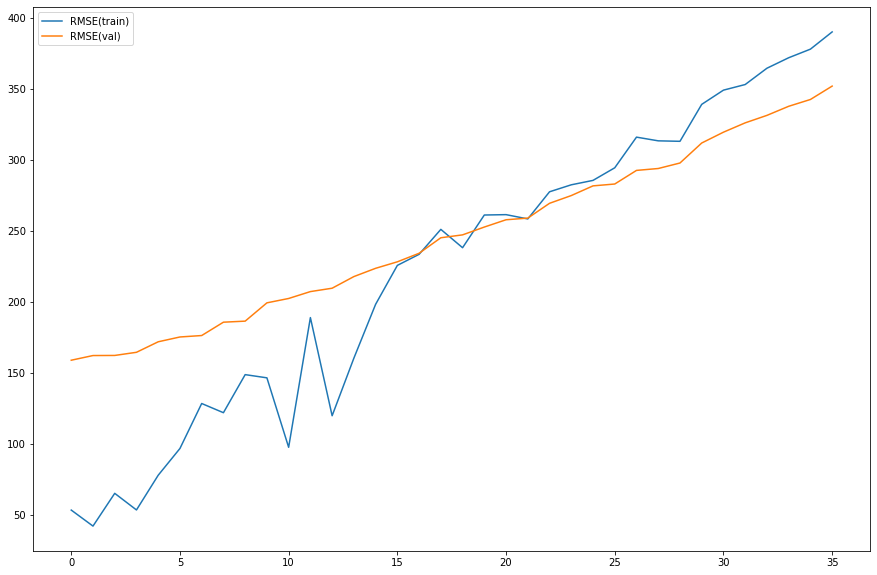

In [ ]:
#실행
gb_results_sorted = gb_results.sort_values('RMSE(val)').reset_index()

In [ ]:
#실행
gb_results_sorted.head(5)

**RMSE(val) Value**기준으로 parameter 설정 및 모델링

In [ ]:
#실행
gb = GradientBoostingRegressor(n_estimators=150, learning_rate=0.3, max_depth=7)
gb.fit(train_x, train_y)

# R^2
gb_pred = gb.predict(test_x)                                     
gb_r2 = gb.score(test_x, test_y)
gb_r2

0.8451835065804448

In [ ]:
#실행
#RMSE
mse_gb_test = mean_squared_error(test_y, gb_pred)
rmse_gb_test = mse_gb_test**(0.5)
rmse_gb_test

149.97960279947168

In [ ]:
#실행
#MAE
mae_gb_test = mean_absolute_error(test_y, gb_pred)
mae_gb_test

45.2650476140532

In [ ]:
#실행
gb_grid_adj_r2_score = adj_r2_score(test_y, gb_pred, test_x)
gb_grid_adj_r2_score

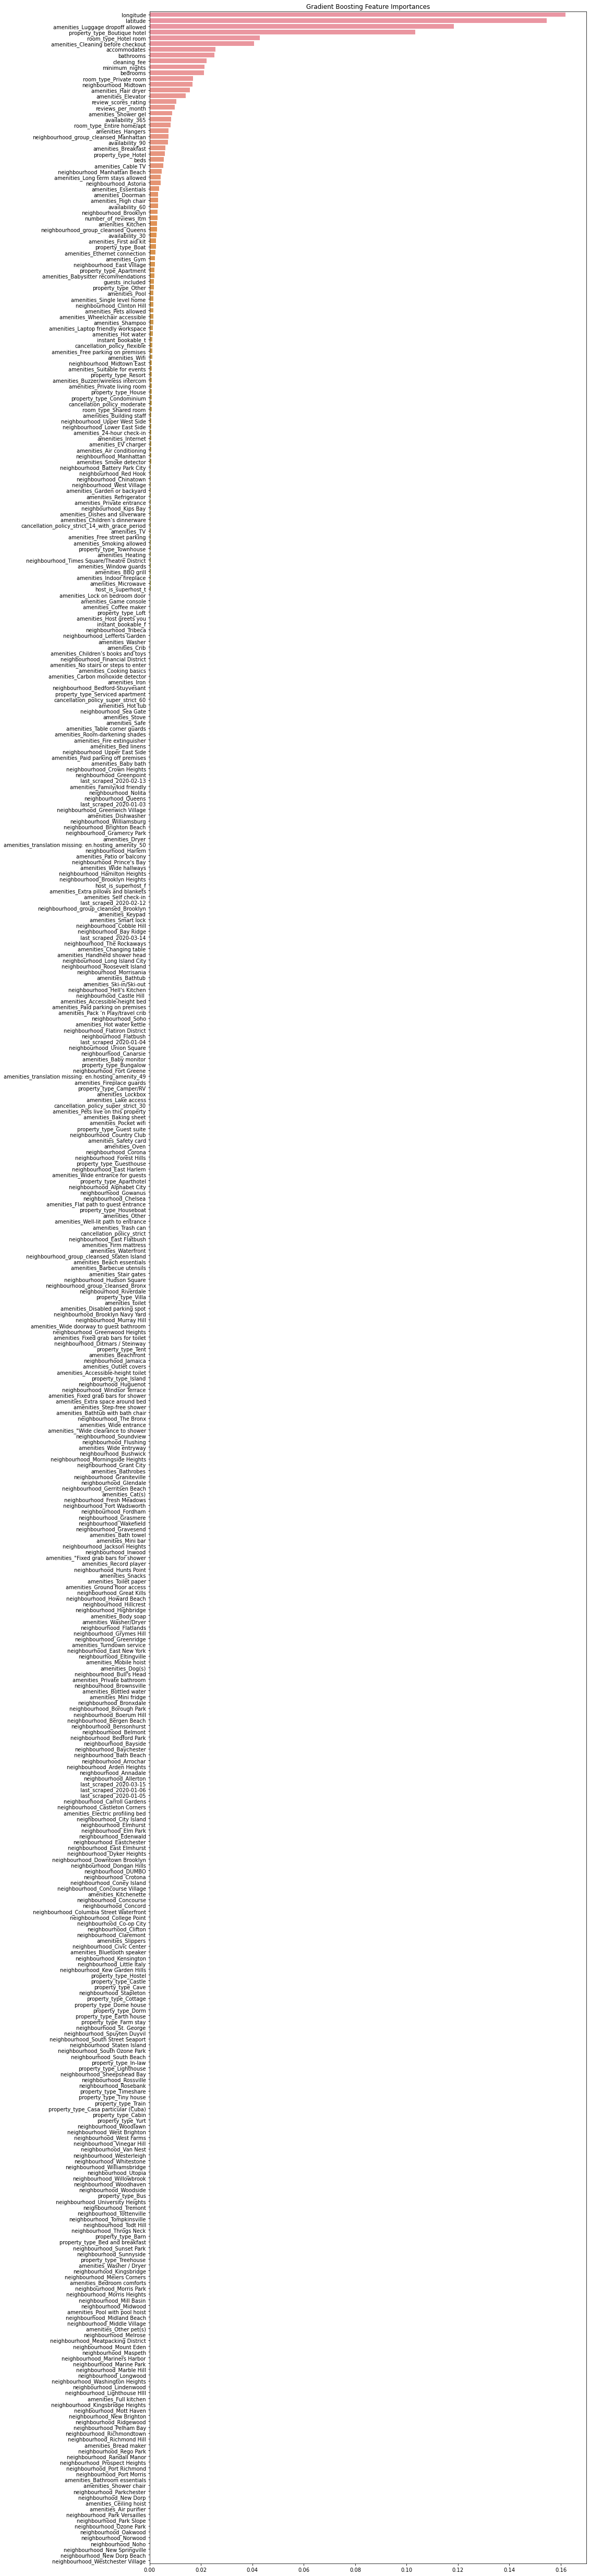

In [ ]:
gb_features = gb.feature_importances_
gb_feature_imp = pd.Series(gb_features, index=train_x.columns)
gb_feature_imp = gb_feature_imp.sort_values(ascending=False)

plt.figure(figsize=(15,90))
plt.title('Gradient Boosting Feature Importances')
sns.barplot(x=gb_feature_imp, y = gb_feature_imp.index)
plt.show()

###**(6) XG-Boost**

##### **hyperparameter 한 개씩 최적화**

In [ ]:
#실행
xgb_n_estimators_list = [900, 950, 1000, 1050]
xgb_max_depth_list = [3, 6, 9, 12, 15]
xgb_min_child_weight_list = [1, 3, 5, 7, 9]
xgb_learning_rate_list = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3]

n_estimator 값만 변화를 주고 나머지 하이퍼 파라미터는 고정

In [ ]:
#실행
def rmse_variable_n_est_xgb(_param_list):
    result = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
    for i in _param_list :
        n_est, max_dep, min_c_w, lr = i, 9, 3, 0.1
        xgb = XGBRegressor(n_estimators=n_est, min_child_weight=min_c_w, max_depth=max_dep, learning_rate=lr, n_jobs=-1,  random_state= 1234, objective = 'reg:squarederror')
        xgb.fit(train_x, train_y)
        xgb_pred_train = xgb.predict(train_x)
        xgb_pred_val = xgb.predict(val_x)
        xgb_r2 = xgb.score(val_x, val_y)
        mse_xgb_train = mean_squared_error(train_y, xgb_pred_train)
        rmse_xgb_train = mse_xgb_train**(0.5)
        mse_xgb_val = mean_squared_error(val_y, xgb_pred_val)
        rmse_xgb_val = mse_xgb_val**(0.5)
        mae_xgb_train = mean_absolute_error(train_y, xgb_pred_train)
        mae_xgb_val = mean_absolute_error(val_y, xgb_pred_val)
        hyper_params = 'n_est : %s'%(n_est)
        new_row = {'R2' : xgb_r2, 'RMSE(train)': rmse_xgb_train, 'RMSE(val)': rmse_xgb_val, 
             'MAE(train)': mae_xgb_train , 'MAE(val)' : mae_xgb_val, 'hyper_params' : hyper_params}
        result = result.append(new_row, ignore_index = True)
  
    return result

In [ ]:
#실행
xgb_n_est_results = rmse_variable_n_est_xgb(xgb_n_estimators_list)
xgb_n_est_results

R2  RMSE(train)   RMSE(val)  MAE(train)   MAE(val)  hyper_params
0  0.852287    22.834509  143.102498   13.388169  32.779843   n_est : 900
1  0.852723    21.594712  142.891208   12.703799  32.396381   n_est : 950
2  0.852916    20.546054  142.797651   12.116828  32.096572  n_est : 1000
3  0.853202    19.595607  142.658735   11.551662  31.803139  n_est : 1050

n_estimator 값이 너무 커질 수 있기 때문에 **n_est=1000으로 설정**

([<matplotlib.axis.XTick at 0x7fc8e023af10>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

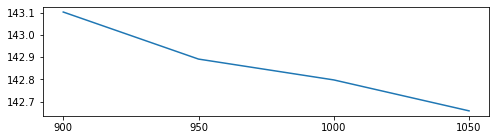

In [ ]:
plt.figure(figsize=(8,2))
plt.plot(xgb_n_estimators_list, xgb_n_est_results.loc[:,'RMSE(val)'])
plt.xticks(xgb_n_estimators_list)

max_depth 값만 변화를 주고 나머지 하이퍼 파라미터는 고정

In [ ]:
#실행
def rmse_variable_max_depth_xgb(_param_list):
    result = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
    for i in _param_list :
        n_est, max_dep, min_c_w, lr = 1000, i, 3, 0.1
        xgb = XGBRegressor(n_estimators=n_est, min_child_weight=min_c_w, max_depth=max_dep, learning_rate=lr, n_jobs=-1,  random_state= 1234, objective = 'reg:squarederror')
        xgb.fit(train_x, train_y)
        xgb_pred_train = xgb.predict(train_x)
        xgb_pred_val = xgb.predict(val_x)
        xgb_r2 = xgb.score(val_x, val_y)
        mse_xgb_train = mean_squared_error(train_y, xgb_pred_train)
        rmse_xgb_train = mse_xgb_train**(0.5)
        mse_xgb_val = mean_squared_error(val_y, xgb_pred_val)
        rmse_xgb_val = mse_xgb_val**(0.5)
        mae_xgb_train = mean_absolute_error(train_y, xgb_pred_train)
        mae_xgb_val = mean_absolute_error(val_y, xgb_pred_val)
        hyper_params = 'max_dep : %s'%(max_dep)
        new_row = {'R2' : xgb_r2, 'RMSE(train)': rmse_xgb_train, 'RMSE(val)': rmse_xgb_val, 
             'MAE(train)': mae_xgb_train , 'MAE(val)' : mae_xgb_val, 'hyper_params' : hyper_params}
        result = result.append(new_row, ignore_index = True)
  
    return result

In [ ]:
#실행
xgb_max_depth_results = rmse_variable_max_depth_xgb(xgb_max_depth_list)
xgb_max_depth_results

R2  RMSE(train)   RMSE(val)  MAE(train)   MAE(val)  hyper_params
0  0.565140   229.537962  245.534541   67.819872  70.043169   max_dep : 3
1  0.835062    68.590705  151.216360   33.534060  46.688917   max_dep : 6
2  0.852916    20.546054  142.797651   12.116828  32.096572   max_dep : 9
3  0.845311     3.856070  146.442593    2.078448  25.726699  max_dep : 12
4  0.846248     0.794273  145.998451    0.209531  24.119813  max_dep : 15

([<matplotlib.axis.XTick at 0x7fc8e09cc520>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

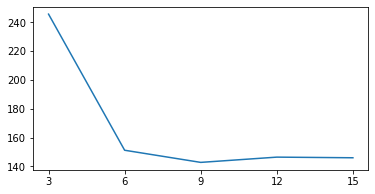

In [ ]:
#실행
plt.figure(figsize=(6,3))
plt.plot(xgb_max_depth_list, xgb_max_depth_results.loc[:,'RMSE(val)'])
plt.xticks(xgb_max_depth_list)

**max_depth = 9** 이후 부터 **overfitting**발생<br>
max_depth = 9로 설정

In [ ]:
#실행
def rmse_variable_min_c_w_xgb(_param_list):
    result = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
    for i in _param_list :
        n_est, max_dep, min_c_w, lr = 1000, 9, i, 0.1
        xgb = XGBRegressor(n_estimators=n_est, min_child_weight=min_c_w, max_depth=max_dep, learning_rate=lr, n_jobs=-1,  random_state= 1234, objective = 'reg:squarederror')
        xgb.fit(train_x, train_y)
        xgb_pred_train = xgb.predict(train_x)
        xgb_pred_val = xgb.predict(val_x)
        xgb_r2 = xgb.score(val_x, val_y)
        mse_xgb_train = mean_squared_error(train_y, xgb_pred_train)
        rmse_xgb_train = mse_xgb_train**(0.5)
        mse_xgb_val = mean_squared_error(val_y, xgb_pred_val)
        rmse_xgb_val = mse_xgb_val**(0.5)
        mae_xgb_train = mean_absolute_error(train_y, xgb_pred_train)
        mae_xgb_val = mean_absolute_error(val_y, xgb_pred_val)
        hyper_params = 'min_c_w : %s'%(min_c_w)
        new_row = {'R2' : xgb_r2, 'RMSE(train)': rmse_xgb_train, 'RMSE(val)': rmse_xgb_val, 
             'MAE(train)': mae_xgb_train , 'MAE(val)' : mae_xgb_val, 'hyper_params' : hyper_params}
        result = result.append(new_row, ignore_index = True)
  
    return result

In [ ]:
#실행
xgb_min_c_w_results = rmse_variable_min_c_w_xgb(xgb_min_child_weight_list)
xgb_min_c_w_results

R2  RMSE(train)   RMSE(val)  MAE(train)   MAE(val) hyper_params
0  0.838063    16.274268  149.834384   10.322276  29.289208  min_c_w : 1
1  0.852916    20.546054  142.797651   12.116828  32.096572  min_c_w : 3
2  0.853798    27.250642  142.368551   14.913016  35.051839  min_c_w : 5
3  0.863572    34.641468  137.527740   18.049836  37.946413  min_c_w : 7
4  0.851714    43.533117  143.379967   21.408872  40.637157  min_c_w : 9

([<matplotlib.axis.XTick at 0x7fc9735d4190>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

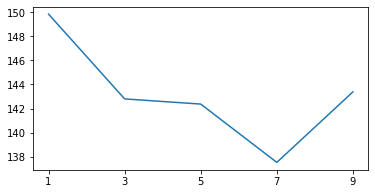

In [ ]:
#실행
plt.figure(figsize=(6,3))
plt.plot(xgb_min_child_weight_list, xgb_min_c_w_results.loc[:,'RMSE(val)'])
plt.xticks(xgb_min_child_weight_list)

**min_child_weight=7**이후로 overfitting 발생<br>
min_child_weight는 7로 설정

In [ ]:
#실행
def rmse_variable_lr_xgb(_param_list):
    result = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
    for i in _param_list :
        n_est, max_dep, min_c_w, lr = 1000, 9, 7, i
        xgb = XGBRegressor(n_estimators=n_est, min_child_weight=min_c_w, max_depth=max_dep, learning_rate=lr, n_jobs=-1,  random_state= 1234, objective = 'reg:squarederror')
        xgb.fit(train_x, train_y)
        xgb_pred_train = xgb.predict(train_x)
        xgb_pred_val = xgb.predict(val_x)
        xgb_r2 = xgb.score(val_x, val_y)
        mse_xgb_train = mean_squared_error(train_y, xgb_pred_train)
        rmse_xgb_train = mse_xgb_train**(0.5)
        mse_xgb_val = mean_squared_error(val_y, xgb_pred_val)
        rmse_xgb_val = mse_xgb_val**(0.5)
        mae_xgb_train = mean_absolute_error(train_y, xgb_pred_train)
        mae_xgb_val = mean_absolute_error(val_y, xgb_pred_val)
        hyper_params = 'lr : %s'%(lr)
        new_row = {'R2' : xgb_r2, 'RMSE(train)': rmse_xgb_train, 'RMSE(val)': rmse_xgb_val, 
             'MAE(train)': mae_xgb_train , 'MAE(val)' : mae_xgb_val, 'hyper_params' : hyper_params}
        result = result.append(new_row, ignore_index = True)
  
    return result

In [ ]:
#실행
xgb_lr_results = rmse_variable_lr_xgb(xgb_learning_rate_list)
xgb_lr_results

R2  RMSE(train)   RMSE(val)  MAE(train)   MAE(val) hyper_params
0  0.768440   135.978739  179.172058   43.268873  49.446843    lr : 0.01
1  0.850900    60.998558  143.772973   27.743832  41.994632    lr : 0.05
2  0.863572    34.641468  137.527740   18.049836  37.946413     lr : 0.1
3  0.864172    23.299899  137.225022   12.918819  36.297450    lr : 0.15
4  0.861092    16.618660  138.772148    9.577023  35.385740     lr : 0.2
5  0.859088     9.555863  139.769458    5.688834  35.289239     lr : 0.3

([<matplotlib.axis.XTick at 0x7fc976d802b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

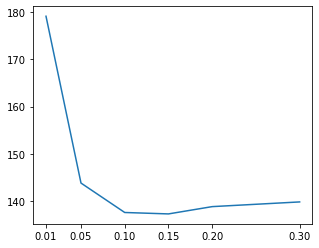

In [ ]:
#실행
plt.figure(figsize=(5,4))
plt.plot(xgb_learning_rate_list, xgb_lr_results.loc[:,'RMSE(val)'])
plt.xticks(xgb_learning_rate_list)

**learning_rate=0.15**이후 overfitting 가능성 존재<br>
learning_rate=0.15로 설정

n_estimator = 1000, max_depth = 9, min_child_weight = 7, learning_rate = 0.15로 최종 Parameter 선정

In [ ]:
#실행
xgb_final = XGBRegressor(n_estimators=1000, min_child_weight=7, max_depth=9, learning_rate=0.15, random_state= 1234, objective='reg:squarederror')
xgb_final.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=9, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=1234,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
#실행
xgb_pred_test = xgb_final.predict(test_x)
xgb_r2 = xgb_final.score(test_x, test_y)
xgb_r2

0.8435577149243938

In [ ]:
#실행
#RMSE_test
mse_xgb_test = mean_squared_error(test_y, xgb_pred_test)
rmse_xgb_test = mse_xgb_test**(0.5)
#MAE_test
mae_xgb_test = mean_absolute_error(test_y, xgb_pred_test)
print(rmse_xgb_test)
print(mae_xgb_test)

150.7650448617476
36.55115375776223


In [ ]:
plt.figure(figsize=(4,1))
plt.plot(gb_max_depth_list, gb_max_d_results.loc[:, 'RMSE(val)'])
plt.xticks(gb_max_depth_list)

#####**GridSearch**
(1) High Learning rate(0.05 ~ 0.3)을 선택하고 해당 value에 맞춰 tree 개수 선정<br>
(2) tree-specific parameter를 수정<br>
-> max_depth, min_child_weight, gamma, subsample, colsample_bytree<br>
(3) regularization parameter<br>
(4) 학습률을 낮추고 다시 (1)~(3) 과정 반복

**n_estimators, max_depth, min_child_weight, learning_rate** parameter 조작

In [ ]:
#실행
xgb_params = {
    'n_estimators' : [50, 100, 150],
    'max_depth' : range(3, 10, 3),
    'min_child_weight' : range(1, 6, 2),
    'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2]
}
xgb_p = list(product(*xgb_params.values()))
xgb_p

[(50, 3, 1, 0.01),
 (50, 3, 1, 0.05),
 (50, 3, 1, 0.1),
 (50, 3, 1, 0.15),
 (50, 3, 1, 0.2),
 (50, 3, 3, 0.01),
 (50, 3, 3, 0.05),
 (50, 3, 3, 0.1),
 (50, 3, 3, 0.15),
 (50, 3, 3, 0.2),
 (50, 3, 5, 0.01),
 (50, 3, 5, 0.05),
 (50, 3, 5, 0.1),
 (50, 3, 5, 0.15),
 (50, 3, 5, 0.2),
 (50, 6, 1, 0.01),
 (50, 6, 1, 0.05),
 (50, 6, 1, 0.1),
 (50, 6, 1, 0.15),
 (50, 6, 1, 0.2),
 (50, 6, 3, 0.01),
 (50, 6, 3, 0.05),
 (50, 6, 3, 0.1),
 (50, 6, 3, 0.15),
 (50, 6, 3, 0.2),
 (50, 6, 5, 0.01),
 (50, 6, 5, 0.05),
 (50, 6, 5, 0.1),
 (50, 6, 5, 0.15),
 (50, 6, 5, 0.2),
 (50, 9, 1, 0.01),
 (50, 9, 1, 0.05),
 (50, 9, 1, 0.1),
 (50, 9, 1, 0.15),
 (50, 9, 1, 0.2),
 (50, 9, 3, 0.01),
 (50, 9, 3, 0.05),
 (50, 9, 3, 0.1),
 (50, 9, 3, 0.15),
 (50, 9, 3, 0.2),
 (50, 9, 5, 0.01),
 (50, 9, 5, 0.05),
 (50, 9, 5, 0.1),
 (50, 9, 5, 0.15),
 (50, 9, 5, 0.2),
 (100, 3, 1, 0.01),
 (100, 3, 1, 0.05),
 (100, 3, 1, 0.1),
 (100, 3, 1, 0.15),
 (100, 3, 1, 0.2),
 (100, 3, 3, 0.01),
 (100, 3, 3, 0.05),
 (100, 3, 3, 0.1),
 (100,

results에 성능 지표 저장

In [ ]:
#실행
results = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
for i in xgb_p :
  n_est, max_dep, min_c_w, lr = i[0], i[1], i[2], i[3]
  n_est, min_c_w, max_dep = int(n_est), int(min_c_w), int(max_dep)
  xgb = XGBRegressor(n_estimators=n_est, min_child_weight=min_c_w, max_depth=max_dep, learning_rate=lr, n_jobs=-1,  random_state= 1234, objective = 'reg:squarederror')
  xgb.fit(train_x, train_y)
  xgb_pred_train = xgb.predict(train_x)
  xgb_pred_val = xgb.predict(val_x)
  xgb_r2 = xgb.score(val_x, val_y)
  mse_xgb_train = mean_squared_error(train_y, xgb_pred_train)
  rmse_xgb_train = mse_xgb_train**(0.5)
  mse_xgb_val = mean_squared_error(val_y, xgb_pred_val)
  rmse_xgb_val = mse_xgb_val**(0.5)
  mae_xgb_train = mean_absolute_error(train_y, xgb_pred_train)
  mae_xgb_val = mean_absolute_error(val_y, xgb_pred_val)
  hyper_params = 'n_est : %s, min_c_w : %s, max_d : %s, lr : %s'%(n_est, min_c_w, max_dep, lr)
  new_row = {'R2' : xgb_r2, 'RMSE(train)': rmse_xgb_train, 'RMSE(val)': rmse_xgb_val, 
             'MAE(train)': mae_xgb_train , 'MAE(val)' : mae_xgb_val, 'hyper_params' : hyper_params}
  results = results.append(new_row, ignore_index = True)
  print(i)

results

(50, 3, 1, 0.01)
(50, 3, 1, 0.05)
(50, 3, 1, 0.1)
(50, 3, 1, 0.15)
(50, 3, 1, 0.2)
(50, 3, 3, 0.01)
(50, 3, 3, 0.05)
(50, 3, 3, 0.1)
(50, 3, 3, 0.15)
(50, 3, 3, 0.2)
(50, 3, 5, 0.01)
(50, 3, 5, 0.05)
(50, 3, 5, 0.1)
(50, 3, 5, 0.15)
(50, 3, 5, 0.2)
(50, 6, 1, 0.01)
(50, 6, 1, 0.05)
(50, 6, 1, 0.1)
(50, 6, 1, 0.15)
(50, 6, 1, 0.2)
(50, 6, 3, 0.01)
(50, 6, 3, 0.05)
(50, 6, 3, 0.1)
(50, 6, 3, 0.15)
(50, 6, 3, 0.2)
(50, 6, 5, 0.01)
(50, 6, 5, 0.05)
(50, 6, 5, 0.1)
(50, 6, 5, 0.15)
(50, 6, 5, 0.2)
(50, 9, 1, 0.01)
(50, 9, 1, 0.05)
(50, 9, 1, 0.1)
(50, 9, 1, 0.15)
(50, 9, 1, 0.2)
(50, 9, 3, 0.01)
(50, 9, 3, 0.05)
(50, 9, 3, 0.1)
(50, 9, 3, 0.15)
(50, 9, 3, 0.2)
(50, 9, 5, 0.01)
(50, 9, 5, 0.05)
(50, 9, 5, 0.1)
(50, 9, 5, 0.15)
(50, 9, 5, 0.2)
(100, 3, 1, 0.01)
(100, 3, 1, 0.05)
(100, 3, 1, 0.1)
(100, 3, 1, 0.15)
(100, 3, 1, 0.2)
(100, 3, 3, 0.01)
(100, 3, 3, 0.05)
(100, 3, 3, 0.1)
(100, 3, 3, 0.15)
(100, 3, 3, 0.2)
(100, 3, 5, 0.01)
(100, 3, 5, 0.05)
(100, 3, 5, 0.1)
(100, 3, 5, 0.15)
(100, 

R2  ...                                    hyper_params
0    0.039557  ...   n_est : 50, min_c_w : 1, max_d : 3, lr : 0.01
1    0.199798  ...   n_est : 50, min_c_w : 1, max_d : 3, lr : 0.05
2    0.254925  ...    n_est : 50, min_c_w : 1, max_d : 3, lr : 0.1
3    0.295662  ...   n_est : 50, min_c_w : 1, max_d : 3, lr : 0.15
4    0.314564  ...    n_est : 50, min_c_w : 1, max_d : 3, lr : 0.2
..        ...  ...                                             ...
130  0.622511  ...  n_est : 150, min_c_w : 5, max_d : 9, lr : 0.01
131  0.767640  ...  n_est : 150, min_c_w : 5, max_d : 9, lr : 0.05
132  0.807911  ...   n_est : 150, min_c_w : 5, max_d : 9, lr : 0.1
133  0.811697  ...  n_est : 150, min_c_w : 5, max_d : 9, lr : 0.15
134  0.821360  ...   n_est : 150, min_c_w : 5, max_d : 9, lr : 0.2

[135 rows x 6 columns]

In [ ]:
results.loc[:,['RMSE(val), RMSE(train)']].plot(figsize=(15,10))

**RMSE(val)**을 기준으로 인덱싱 및 시각화

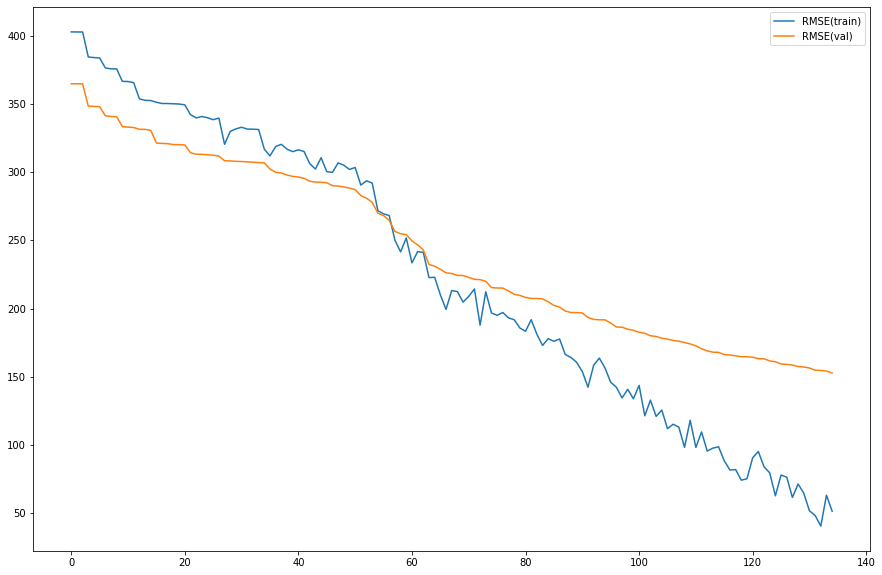

In [ ]:
#실행
xgb_results = results.sort_values('RMSE(val)').reset_index()

In [ ]:
#실행
xgb_results.head(5)

**RMSE(val)**을 기준으로 parameter 설정 후 모델링

In [ ]:
#실행
xgb_final = XGBRegressor(n_estimators=500, min_child_weight=3, max_depth=9, learning_rate=0.2, random_state= 1234, objective = 'reg:squarederror')
xgb_final.fit(train_x, train_y)

XGBRegressor(learning_rate=0.2, max_depth=9, min_child_weight=3,
             n_estimators=500, objective='reg:squarederror', random_state=1234)

In [ ]:
#실행
xgb_pred_test = xgb_final.predict(test_x)
r2 = xgb_final.score(test_x, test_y)
r2

0.8413311239415124

In [ ]:
#실행
#RMSE_test
mse_xgb_test = mean_squared_error(test_y, xgb_pred_test)
rmse_xgb_test = mse_xgb_test**(0.5)
#MAE_test
mae_xgb_test = mean_absolute_error(test_y, xgb_pred_test)
print(rmse_xgb_test)
print(mae_xgb_test)

151.834148608343
34.29060475633007


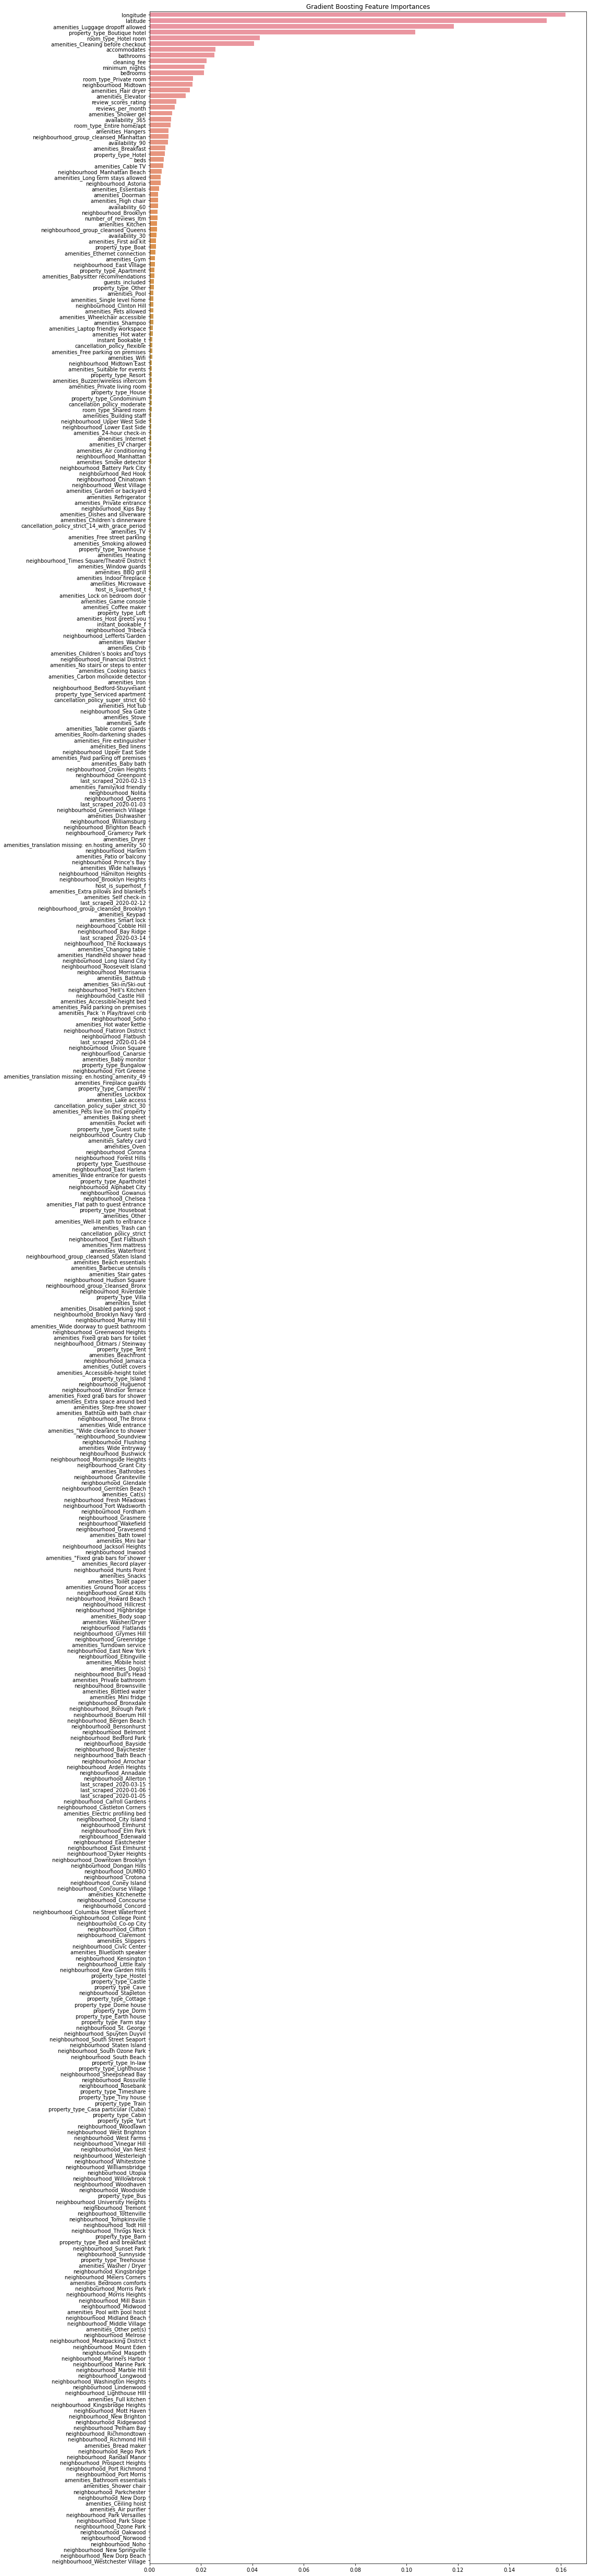

In [ ]:
gb_features = gb.feature_importances_
gb_feature_imp = pd.Series(gb_features, index=train_x.columns)
gb_feature_imp = gb_feature_imp.sort_values(ascending=False)

plt.figure(figsize=(15,90))
plt.title('Gradient Boosting Feature Importances')
sns.barplot(x=gb_feature_imp, y = gb_feature_imp.index)
plt.show()